In [1]:
# Deep Learning Libraries
# !pip install 'torch==2.0.1+cu117' -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import collections # A module providing alternative data structures like named tuples, defaultdict, Counter, etc., compared to built-in Python containers.
import random

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn

# File and System Interaction
import glob
import os
from pathlib import Path
import shutil

# Scientific Computing and Math
import scipy
from scipy.signal import tukey # A function from SciPy used to generate a Tukey window for signal processing.
from scipy.io import loadmat # A function from SciPy used for reading MATLAB data files.
import scipy.io as sio # The SciPy I/O module providing functions for working with different file formats.
import math
import cmath

# # Google Colab and Mount Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Date and Time Handling
import time
import datetime

# Linear Algebra
from torch import linalg as LA

In [ ]:
torch.cuda.is_available()

In [ ]:
from py_scripts import convmc, dataset_processing, inference, logs_and_results, training

In [2]:
# Get scripts from github

# Download it from GitHub
try:
  from py_scripts import convmc, dataset_processing, inference, logs_and_results, training
except:
  # Clone github to access data
  !git clone https://github.com/TalhaAhmed2000/convmc-net.git
  !mv convmc-net/python_scripts py_scripts
  from py_scripts import convmc, dataset_processing, inference, logs_and_results, training

Cloning into 'convmc-net'...
remote: Enumerating objects: 25882, done.
remote: Counting objects: 100% (381/381), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 25882 (delta 257), reused 202 (delta 135), pack-reused 25501
Receiving objects: 100% (25882/25882), 310.22 MiB | 2.16 MiB/s, done.
Resolving deltas: 100% (6331/6331), done.
Checking out files: 100% (25281/25281), done.
[INFO] Cloning the repository and importing convmc & dataset_preprocessing script...


fatal: destination path 'convmc-net' already exists and is not an empty directory.
mv: cannot stat 'convmc-net/python_scripts': No such file or directory


In [ ]:
# !rm -r convmc-net
# !rm -r py_scripts

## Dataset.py

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug  3 13:29:11 2018

@author: Yi Zhang
"""



class Dataset:
    def __init__(self,folder=None,shuffle=None,prefix=None,shownum=10):
        self._folder=None
        if not folder is None:
            self._folder=folder
            self._flist=os.listdir(folder)
        if not prefix is None:
            tmp=[]
            for s in self._flist:
                if s.startswith(prefix):
                    tmp.append(s)
            self._flist=tmp
        self._flist.sort()
        if not shuffle is None:
            random.shuffle(self._flist,shuffle)
            print(self._flist[0:shownum])

    def getnpz(self,fileind,arrind,folder=None):
        if folder is None:
            folder=self._folder
            flist=self._flist
        else:
            flist=os.listdir(folder)
        data=np.load(folder+flist[fileind],mmap_mode='r+')
        dlist=[]
        l=0
        for x in data:
            if l in arrind:
                dlist.append(data[x])
            l=l+1
        return dlist

    def getmat(self,fileind,arrind,folder=None):
        if folder is None:
            folder=self._folder
            flist=self._flist
        else:
            flist=os.listdir(folder)
        data=loadmat(folder+flist[fileind])
        dlist=[]
        for x in arrind:
            dlist.append(data[x])
        return dlist


class Converter:
    def __init__(self):
        """
        Preprocessing:
        1.concat: inv=False, concatenate real and imaginary parts in axis=-1
            inv=True, depart two parts in -1 axis into real and imaginary parts
        2.ch2: inv=False, concatenate real and imaginary parts in a new axis=0
            inv=True, depart two parts in 1 axis into real and imaginary parts
        3.stack: inv=False, stack real and imaginary parts in axis=-1
            inv=True, depart two parts in -1 axis into real and imaginary parts
        3.None: pass
        """
        # self.pre={'concat':self.concat,'ch2':self.ch2,'stack':self.stack}

    def np2torch(self,xnp,formlist):
        dlist=[]
        for i,x in enumerate(xnp):
            # if ('pre' in formlist[i]) and (formlist[i]['pre'] in self.pre):
            #     x=self.pre[formlist[i]['pre']](x,inv=False)
            x=x.reshape(formlist[i]['shape'])
            x=torch.tensor(x,dtype=torch.float32)
            dlist.append(x)
        return dlist

    def torch2np(self,xtorch,formlist):
        dlist=[]
        for i,x in enumerate(xtorch):
            if torch.cuda.is_available():
                x=x.cpu().detach().numpy()
            else:
                x=x.detach().numpy()
            # if ('pre' in formlist[i]) and (formlist[i]['pre'] in self.pre):
                # print([formlist[i]['pre']])
                # print(self.pre)
                # x=self.pre[formlist[i]['pre']](x,inv=False)
            # x=x.reshape(formlist[i]['shape'])
            dlist.append(x)
        return dlist

    # def stack(self,x,inv):
        # if not inv:
            # #not inv, np2torch
            # x=np.swapaxes(x,0,-1)
            # xr=x.real
            # xi=x.imag
            # size=list(x.shape)
            # size[0]*=2
            # size=tuple(size)
            # z=np.zeros(size)
            # z[0::2]=xr
            # z[1::2]=xi
            # z=np.swapaxes(z,0,-1)
        # else:
            #inv, torch2np
            # #size=[B,C,H,W,(T)],numpy
            # x=np.swapaxes(x,0,-1)
            # xr=x[0::2]
            # xi=x[1::2]
            # z=xr+1j*xi
            # z=np.swapaxes(z,0,-1)

        return x

    # def concat(self,x,inv):
        # if not inv:
            #not inv, np2torch
            # z=np.concatenate((x.real,x.imag),axis=-1)
        # else:
            #inv, torch2np
            #size=[B,C,H,W,(T)],numpy
            # x=np.swapaxes(x,0,-1)
            # n=x.shape[0]
            # nh=int(n/2)
            # xr=x[0:nh]
            # xi=x[nh:n]
            # z=xr+1j*xi
            # z=np.swapaxes(z,0,-1)

        return z

    def ch2(self,x,inv):
        pass


## Player.py

In [4]:
# Player.py

# -*- coding: utf-8 -*-
"""
Created on Thu Aug  2 15:43:10 2018

@author: Yi Zhang
"""

# import numpy as np
# import matplotlib.pyplot as plt
# import torch

minDBdf=-50
class Player:
    def __init__(self,Tpause=None):
        if Tpause==None:
            self.Tpause=0.1
        else:
            self.Tpause=Tpause
        self.fig=None
        self.ax={1:None,2:None,3:None,4:None,5:None,6:None}
        self.axnum=0

    def plotmat(self,mvlist,note=None,tit=None,supt=None,
                cmap='gray',ion=True,minDB=None):
        """
        input:matrix dimension
        """
        if minDB is None:
            minDB=minDBdf

        if ion:
            plt.ion()

        # print('In function plotmat')
        subp={1:[1,1],2:[1,2],3:[1,3],4:[2,2],5:[2,3],6:[2,3],9:[3,3],12:[4,3]}
        # print('len(mvlist)',len(mvlist))
        p1,p2=subp[len(mvlist)]
        # print('p1,p2',p1,p2)
        if p1*p2!=self.axnum or self.fig is None or not(plt.fignum_exists(self.fig.number)):
            'in this if statement'
            self.fig,(self.ax)=plt.subplots(p1,p2)
            self.axnum=p1*p2
            if self.axnum==1:
                self.ax=np.array([self.ax])
            self.ax=self.ax.reshape([-1])

        for i in range(len(mvlist)):
            US=mvlist[i]
            # print('i of mvlist',i)
            if US is None:
                continue
            if US.dtype is torch.float32:
                US=US.detach().numpy()
                # 'in this if statement 2'
            # print ('US.shape',US.shape)
            US=np.abs(US) #.reshape([-1,mvlist[i].shape[-1]])
            # US = np.transpose(US, (1, 2, 0))
            if np.sum(np.abs(US))!=0:
                US=US/np.max(US)
            if note=='db':
                US[US<10**(minDB/20)]=10**(minDB/20)
                US=20*np.log10(US)
            vmin,vmax=[minDB,0] if note=='db' else [0,1]
            self.ax[i].clear()
            self.ax[i].imshow(US)
            if not(tit is None):
                self.ax[i].set_title(tit[i])
        if not(supt is None):
            self.fig.suptitle(supt)
        if ion:
            plt.pause(self.Tpause)
        return self.fig

    def play(self,mvlist,note=None,tit=None,supt=None,cmap='gray',minDB=None):
        """
        input:movie dimension
        """
        if minDB is None:
            minDB=minDBdf

        subp={1:[1,1],2:[1,2],3:[1,3],4:[2,2],5:[2,3],6:[2,3],9:[3,3]}
        p1,p2=subp[len(mvlist)]
        T=mvlist[0].shape[-1]
        fig,ax=plt.subplots(p1,p2)
        if p1*p2==1:
            ax=np.array([ax])
        ax=ax.reshape([-1])

        plt.ion()

        for i in range(len(mvlist)):
            US=mvlist[i]
            if US is None:
                continue
            if US.dtype is torch.float32:
                US=US.detach().numpy().squeeze()

            US=np.abs(US)
            if np.sum(np.abs(US))!=0:
                US=US/np.max(US)
            if note=='db':
                US[US<10**(minDB/20)]=10**(minDB/20)
                US=20*np.log10(US)
            mvlist[i]=US

        for t in range(T):
            for i in range(len(mvlist)):
                if mvlist[i] is None:
                    continue
                vmin,vmax=[minDB,0] if note=='db' else [0,1]
                ax[i].clear()
                ax[i].imshow(mvlist[i][:,:,t],cmap=cmap,aspect='auto',
                             vmin=vmin,vmax=vmax)
                if not(tit is None):
                    ax[i].set_title(tit[i])
            if supt==None:
                supt=''
            fig.suptitle('%dth Frame,'%(t+1)+supt)
            plt.pause(self.Tpause)


#### DataSet_Unfolded for Real World Sensing Data.py

In [5]:
# Setting up some global variables

ROOT = '/home/gcf/Desktop/Talha_Nehal Sproj/Tahir Sproj Stuff/SPROJ_ConvMC_Net/Sensor_Data'
TRY = '1st try'
SESSION = 'Session 1'

#### Model path of loading

Testing Training Loop

In [6]:
# Get parameters
def get_default_param(hyper_param_net, gpu = True):
    params_net = {}
    if hyper_param_net['Model'] == 'ADMM-Net':
        params_net['layers'] = 5

        params_net['initial_neta'] = 1.81    # fixed
        params_net['initial_lamda1'] = 0.051 # fixed
        params_net['initial_lamda2'] = 0.049 # fixed
        params_net['initial_v'] = 0

        params_net['initial_S'] = 0.05001 #fixed

        params_net['initial_P'] = 0.2401 #fixed

        params_net['initial_rho'] = 0.1001

        params_net['coef_gamma'] = 0.4001

        params_net['CalInGPU'] = gpu #whether to calculate in GPU
        params_net['size1'] = 49
        params_net['size2'] = 60

    else:
        params_net['layers'] = 5 #1 #2 #3 #4 #5 #6 #7 #8 #9 #10
        params_net['kernel'] = [(3, 1)] * 3 + [(3, 1)] * 7
        params_net['initial_mu_inverse'] = 0.0

        params_net['initial_y1']= 0.8

        params_net['coef_mu_inverse'] = 0.36

        params_net['CalInGPU'] = gpu # whether to calculate in GPU
        params_net['kernel'] = params_net['kernel'][0:params_net['layers']]
        params_net['size1'] = 49
        params_net['size2'] = 60

    return params_net

Project Name: 1st try 2023-09-09 03:37:32 ConvMC-Net Sampling Rate: 10.0% and Noise Variance 0.0
Configuring Network...

Instantiating Model...

Model Instantiated...

Parameters = 
{'layers': 5, 'kernel': [(3, 1), (3, 1), (3, 1), (3, 1), (3, 1)], 'initial_mu_inverse': 0.0, 'initial_y1': 0.8, 'coef_mu_inverse': 0.36, 'CalInGPU': True, 'size1': 49, 'size2': 60}

Loading Data phase...
----------------
loading train set 0
loading validation set 0
Finished loading.

Adjusting learning rate of group 0 to 1.2000e-02.
Epoch: 1, 2023-09-09 03:37:33, 

Epoch: 2, 2023-09-09 03:37:39, 

Epoch: 3, 2023-09-09 03:37:43, 

Epoch: 4, 2023-09-09 03:37:47, 

Epoch: 5, 2023-09-09 03:37:51, 

Loading and calculating training batches...
Training time is 3.536109
Loading and calculating validation batches...
Test time is 0.562517
Saving Whole Model at Epochs: [5/40]
Saving Model Dict at Epochs: [5/40]
Epoch [5/40], Lossmean:1.11551e-05, Validation lossmean:9.64616e-06
loss_lowrank_mean 1.1155147839758684e-0

Epoch: 2, 2023-09-09 03:40:23, 

Epoch: 3, 2023-09-09 03:40:28, 

Epoch: 4, 2023-09-09 03:40:32, 

Epoch: 5, 2023-09-09 03:40:36, 

Loading and calculating training batches...
Training time is 3.573298
Loading and calculating validation batches...
Test time is 0.567304
Saving Whole Model at Epochs: [5/40]
Saving Model Dict at Epochs: [5/40]
Epoch [5/40], Lossmean:1.46329e-04, Validation lossmean:1.34735e-04
loss_lowrank_mean 0.00014632934169640067
loss_val_lowrank_mean 0.00013473459849217974
mu_inverse: [ 0.065  0.236  0.069 -0.109  0.2  ]
torch.mean(y1) 0.7713988
y1: [[0.778 0.782 0.812 ... 0.791 0.855 0.672]
 [0.843 0.788 0.958 ... 0.702 0.628 0.647]
 [0.815 0.871 0.788 ... 0.791 0.718 0.779]
 ...
 [0.644 0.69  0.79  ... 0.823 0.752 0.727]
 [0.851 0.85  0.705 ... 0.686 0.894 0.608]
 [0.792 0.811 0.884 ... 0.88  0.77  0.735]]
exp_L: [0.186 0.201 0.186 0.17  0.198]
saved at [epoch5/40]
Epoch: 6, 2023-09-09 03:40:40, 

Epoch: 7, 2023-09-09 03:40:44, 

Epoch: 8, 2023-09-09 03:40:48, 

Ep

Training time is 3.593929
Loading and calculating validation batches...
Test time is 0.568823
Saving Whole Model at Epochs: [5/40]
Saving Model Dict at Epochs: [5/40]
Epoch [5/40], Lossmean:4.40866e-04, Validation lossmean:3.23310e-04
loss_lowrank_mean 0.00044086610640079013
loss_val_lowrank_mean 0.0003233095304655281
mu_inverse: [-0.07  -0.028  0.017 -0.17   0.214]
torch.mean(y1) 0.7245469
y1: [[0.678 0.835 0.611 ... 0.678 0.709 0.791]
 [0.829 0.681 0.672 ... 0.8   0.75  0.776]
 [0.647 0.667 0.744 ... 0.782 0.625 0.697]
 ...
 [0.655 0.783 0.705 ... 0.718 0.771 0.667]
 [0.714 0.696 0.74  ... 0.716 0.762 0.689]
 [0.722 0.783 0.703 ... 0.652 0.76  0.669]]
exp_L: [0.174 0.177 0.182 0.165 0.199]
saved at [epoch5/40]
Epoch: 6, 2023-09-09 03:43:28, 

Epoch: 7, 2023-09-09 03:43:32, 

Epoch: 8, 2023-09-09 03:43:36, 

Epoch: 9, 2023-09-09 03:43:40, 

Epoch: 10, 2023-09-09 03:43:44, 

Loading and calculating training batches...
Training time is 3.593333
Loading and calculating validation batches

/home/gcf/Desktop/Talha_Nehal Sproj/Tahir Sproj Stuff/SPROJ_ConvMC_Net/py_scripts/logs_and_results.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (8, 6), dpi = 100)


Epoch: 27, 2023-09-09 03:44:56, 

Epoch: 28, 2023-09-09 03:45:00, 

Epoch: 29, 2023-09-09 03:45:04, 

Epoch: 30, 2023-09-09 03:45:08, 

Loading and calculating training batches...
Training time is 3.583860
Loading and calculating validation batches...
Test time is 0.569108
Saving Whole Model at Epochs: [30/40]
Saving Model Dict at Epochs: [30/40]
Epoch [30/40], Lossmean:1.06933e-04, Validation lossmean:1.09110e-04
loss_lowrank_mean 0.00010693273764900369
loss_val_lowrank_mean 0.00010911048245950096
mu_inverse: [ 7.133e-05 -3.519e-01 -1.144e-01 -2.188e-01  3.311e-01]
torch.mean(y1) 0.7024331
y1: [[0.655 0.901 0.495 ... 0.729 0.683 0.785]
 [0.83  0.647 0.618 ... 0.831 0.685 0.736]
 [0.652 0.676 0.751 ... 0.789 0.627 0.585]
 ...
 [0.61  0.858 0.701 ... 0.653 0.711 0.745]
 [0.684 0.733 0.679 ... 0.698 0.748 0.718]
 [0.783 0.787 0.725 ... 0.636 0.757 0.718]]
exp_L: [0.18  0.149 0.17  0.16  0.21 ]
saved at [epoch30/40]
Epoch: 31, 2023-09-09 03:45:12, 

Epoch: 32, 2023-09-09 03:45:16, 

Epoch

Training time is 3.606257
Loading and calculating validation batches...
Test time is 0.573494
Saving Whole Model at Epochs: [30/40]
Saving Model Dict at Epochs: [30/40]
Epoch [30/40], Lossmean:2.31903e-04, Validation lossmean:2.63142e-04
loss_lowrank_mean 0.00023190307827462676
loss_val_lowrank_mean 0.000263142153605312
mu_inverse: [-0.042  0.125  0.082 -0.118  0.451]
torch.mean(y1) 0.60778457
y1: [[0.567 0.609 0.39  ... 0.58  0.617 0.494]
 [0.551 0.621 0.593 ... 0.562 0.649 0.535]
 [0.567 0.613 0.613 ... 0.647 0.602 0.583]
 ...
 [0.575 0.664 0.628 ... 0.457 0.592 0.613]
 [0.579 0.618 0.636 ... 0.591 0.618 0.687]
 [0.514 0.542 0.586 ... 0.64  0.499 0.591]]
exp_L: [0.176 0.191 0.187 0.169 0.22 ]
saved at [epoch30/40]
Epoch: 31, 2023-09-09 03:48:00, 

Epoch: 32, 2023-09-09 03:48:04, 

Epoch: 33, 2023-09-09 03:48:08, 

Epoch: 34, 2023-09-09 03:48:12, 

Epoch: 35, 2023-09-09 03:48:17, 

Loading and calculating training batches...
Training time is 3.617661
Loading and calculating validation

Epoch: 32, 2023-09-09 03:50:50, 

Epoch: 33, 2023-09-09 03:50:54, 

Epoch: 34, 2023-09-09 03:50:59, 

Epoch: 35, 2023-09-09 03:51:03, 

Loading and calculating training batches...
Training time is 3.560092
Loading and calculating validation batches...
Test time is 0.564304
Saving Whole Model at Epochs: [35/40]
Saving Model Dict at Epochs: [35/40]
Epoch [35/40], Lossmean:1.43969e-05, Validation lossmean:1.60971e-05
loss_lowrank_mean 1.4396933360600884e-05
loss_val_lowrank_mean 1.6097149698837523e-05
mu_inverse: [ 0.422  0.32   0.11  -0.302 -0.68 ]
torch.mean(y1) 0.666522
y1: [[1.088 0.761 0.629 ... 0.648 0.557 0.783]
 [0.725 0.788 0.739 ... 0.61  0.64  0.864]
 [0.716 0.653 0.56  ... 0.637 0.756 0.705]
 ...
 [0.671 0.683 0.621 ... 0.597 0.741 0.606]
 [0.499 0.577 0.717 ... 0.638 0.855 0.663]
 [0.169 0.687 0.774 ... 0.547 0.67  0.665]]
exp_L: [0.217 0.209 0.19  0.153 0.121]
saved at [epoch35/40]
Epoch: 36, 2023-09-09 03:51:07, 

Epoch: 37, 2023-09-09 03:51:11, 

Epoch: 38, 2023-09-09 03:5

Training time is 3.783552
Loading and calculating validation batches...
Test time is 0.576296
Saving Whole Model at Epochs: [35/40]
Saving Model Dict at Epochs: [35/40]
Epoch [35/40], Lossmean:6.05476e-05, Validation lossmean:7.21816e-05
loss_lowrank_mean 6.054755175455284e-05
loss_val_lowrank_mean 7.218164351155899e-05
mu_inverse: [ 0.29   0.102  0.127  0.247 -0.016]
torch.mean(y1) 0.6880476
y1: [[0.706 0.84  0.931 ... 0.785 0.765 0.786]
 [0.726 0.633 0.856 ... 0.74  0.811 0.622]
 [0.658 0.738 0.551 ... 0.548 0.687 0.728]
 ...
 [0.722 0.716 0.89  ... 0.586 0.618 0.654]
 [0.667 0.869 0.65  ... 0.643 0.714 0.557]
 [0.763 0.521 0.622 ... 0.815 0.774 0.789]]
exp_L: [0.206 0.189 0.191 0.202 0.179]
saved at [epoch35/40]
Epoch: 36, 2023-09-09 03:54:00, 

Epoch: 37, 2023-09-09 03:54:04, 

Epoch: 38, 2023-09-09 03:54:09, 

Epoch: 39, 2023-09-09 03:54:13, 

Epoch: 40, 2023-09-09 03:54:17, 

Loading and calculating training batches...
Training time is 3.801334
Loading and calculating validation 

Epoch: 37, 2023-09-09 03:57:00, 

Epoch: 38, 2023-09-09 03:57:04, 

Epoch: 39, 2023-09-09 03:57:09, 

Epoch: 40, 2023-09-09 03:57:13, 

Loading and calculating training batches...
Training time is 3.786457
Loading and calculating validation batches...
Test time is 0.570133
Saving Whole Model at Epochs: [40/40]
Saving Model Dict at Epochs: [40/40]
Epoch [40/40], Lossmean:1.25196e-04, Validation lossmean:1.47263e-04
loss_lowrank_mean 0.00012519570078438846
loss_val_lowrank_mean 0.0001472631221772377
mu_inverse: [ 0.179  0.079  0.017  0.498 -0.152]
torch.mean(y1) 0.7742234
y1: [[0.723 0.889 0.6   ... 0.615 0.827 0.656]
 [0.765 0.823 0.754 ... 0.953 0.795 0.819]
 [0.729 0.803 0.841 ... 0.742 0.78  0.821]
 ...
 [0.709 0.727 0.738 ... 0.794 0.754 0.61 ]
 [0.691 0.664 0.799 ... 0.78  0.698 0.688]
 [0.779 0.815 0.848 ... 0.679 0.772 0.807]]
exp_L: [0.196 0.187 0.182 0.224 0.166]
saved at [epoch40/40]

min Loss = 1.3784e-04
Project Name: 1st try 2023-09-09 03:57:18 ConvMC-Net Sampling Rate: 30.

Training time is 3.591353
Loading and calculating validation batches...
Test time is 0.571709
Saving Whole Model at Epochs: [40/40]
Saving Model Dict at Epochs: [40/40]
Epoch [40/40], Lossmean:1.33407e-04, Validation lossmean:1.39744e-04
loss_lowrank_mean 0.00013340661231723061
loss_val_lowrank_mean 0.00013974415496169755
mu_inverse: [ 0.09   0.067  0.178 -0.01   0.032]
torch.mean(y1) 0.7836919
y1: [[0.812 0.884 0.681 ... 0.822 0.811 0.754]
 [0.772 0.949 0.73  ... 0.783 0.709 0.614]
 [0.68  0.838 0.825 ... 0.731 0.804 0.453]
 ...
 [0.793 0.879 0.758 ... 0.762 0.895 0.631]
 [0.663 0.8   0.848 ... 0.91  0.833 0.822]
 [0.704 0.819 0.758 ... 0.702 0.795 0.734]]
exp_L: [0.188 0.186 0.196 0.179 0.183]
saved at [epoch40/40]

min Loss = 1.3974e-04
Project Name: 1st try 2023-09-09 04:00:09 ConvMC-Net Sampling Rate: 50.0% and Noise Variance 0.0
Configuring Network...

Instantiating Model...

Model Instantiated...

Parameters = 
{'layers': 5, 'kernel': [(3, 1), (3, 1), (3, 1), (3, 1), (3, 1)], 'i

Finished loading.

Adjusting learning rate of group 0 to 1.2000e-02.
Epoch: 1, 2023-09-09 04:02:55, 

Epoch: 2, 2023-09-09 04:02:59, 

Epoch: 3, 2023-09-09 04:03:03, 

Epoch: 4, 2023-09-09 04:03:07, 

Epoch: 5, 2023-09-09 04:03:11, 

Loading and calculating training batches...
Training time is 3.588220
Loading and calculating validation batches...
Test time is 0.570715
Saving Whole Model at Epochs: [5/40]
Saving Model Dict at Epochs: [5/40]
Epoch [5/40], Lossmean:1.29040e-04, Validation lossmean:1.07901e-04
loss_lowrank_mean 0.00012903964009638002
loss_val_lowrank_mean 0.00010790120423360564
mu_inverse: [0.212 0.075 0.115 0.01  0.108]
torch.mean(y1) 0.745649
y1: [[0.684 0.735 0.738 ... 0.724 0.772 0.897]
 [0.722 0.804 0.766 ... 0.795 0.534 0.644]
 [0.727 0.658 0.656 ... 0.696 0.77  0.597]
 ...
 [0.786 0.821 0.774 ... 0.601 0.729 0.682]
 [0.568 0.626 0.777 ... 0.73  0.772 0.895]
 [0.654 0.885 0.9   ... 0.741 0.735 0.701]]
exp_L: [0.199 0.187 0.19  0.181 0.19 ]
saved at [epoch5/40]
Epoch

Epoch: 5, 2023-09-09 04:05:59, 

Loading and calculating training batches...
Training time is 3.607805
Loading and calculating validation batches...
Test time is 0.570779
Saving Whole Model at Epochs: [5/40]
Saving Model Dict at Epochs: [5/40]
Epoch [5/40], Lossmean:3.66324e-04, Validation lossmean:3.44569e-04
loss_lowrank_mean 0.0003663239202069235
loss_val_lowrank_mean 0.00034456939187400756
mu_inverse: [-0.073  0.1   -0.264 -0.215  0.305]
torch.mean(y1) 0.7916638
y1: [[0.848 0.796 0.668 ... 0.937 0.715 0.856]
 [0.908 0.8   0.857 ... 0.785 0.687 0.877]
 [0.761 0.817 0.727 ... 0.822 0.914 0.77 ]
 ...
 [0.638 0.733 0.783 ... 0.725 0.887 0.8  ]
 [0.701 0.795 0.644 ... 0.712 0.671 0.92 ]
 [0.732 0.735 0.772 ... 0.866 0.873 0.698]]
exp_L: [0.173 0.189 0.156 0.161 0.207]
saved at [epoch5/40]
Epoch: 6, 2023-09-09 04:06:03, 

Epoch: 7, 2023-09-09 04:06:07, 

Epoch: 8, 2023-09-09 04:06:11, 

Epoch: 9, 2023-09-09 04:06:15, 

Epoch: 10, 2023-09-09 04:06:20, 

Loading and calculating training ba

Test time is 0.574642
Saving Whole Model at Epochs: [5/40]
Saving Model Dict at Epochs: [5/40]
Epoch [5/40], Lossmean:1.08103e-03, Validation lossmean:1.08285e-03
loss_lowrank_mean 0.0010810310200031381
loss_val_lowrank_mean 0.0010828483012600748
mu_inverse: [-0.161  0.203 -0.256  0.128  0.199]
torch.mean(y1) 0.79292023
y1: [[0.87  0.779 0.844 ... 0.777 0.698 0.727]
 [0.88  0.746 0.699 ... 0.747 0.763 0.847]
 [0.88  0.743 0.809 ... 0.816 0.709 0.885]
 ...
 [0.747 0.848 0.796 ... 0.784 0.962 0.7  ]
 [0.825 0.811 0.744 ... 0.782 0.858 0.736]
 [0.699 0.849 0.728 ... 0.723 0.69  0.796]]
exp_L: [0.166 0.198 0.157 0.192 0.198]
saved at [epoch5/40]
Epoch: 6, 2023-09-09 04:08:57, 

Epoch: 7, 2023-09-09 04:09:01, 

Epoch: 8, 2023-09-09 04:09:05, 

Epoch: 9, 2023-09-09 04:09:09, 

Epoch: 10, 2023-09-09 04:09:14, 

Loading and calculating training batches...
Training time is 3.594468
Loading and calculating validation batches...
Test time is 0.569147
Saving Whole Model at Epochs: [10/40]
Saving M

Epoch: 7, 2023-09-09 04:11:48, 

Epoch: 8, 2023-09-09 04:11:53, 

Epoch: 9, 2023-09-09 04:11:57, 

Epoch: 10, 2023-09-09 04:12:01, 

Loading and calculating training batches...
Training time is 3.555835
Loading and calculating validation batches...
Test time is 0.569262
Saving Whole Model at Epochs: [10/40]
Saving Model Dict at Epochs: [10/40]
Epoch [10/40], Lossmean:3.45146e-05, Validation lossmean:3.78772e-05
loss_lowrank_mean 3.4514575459638764e-05
loss_val_lowrank_mean 3.7877202914541266e-05
mu_inverse: [ 0.139  0.102  0.123 -0.219 -0.146]
torch.mean(y1) 0.7805335
y1: [[0.679 0.585 0.714 ... 0.879 0.75  0.741]
 [0.677 0.837 0.875 ... 0.868 0.887 0.781]
 [0.772 0.884 0.844 ... 0.938 0.641 0.8  ]
 ...
 [0.866 0.809 0.688 ... 0.812 0.879 0.715]
 [0.746 0.673 0.892 ... 0.695 0.812 0.771]
 [0.756 0.871 0.863 ... 0.81  0.91  0.813]]
exp_L: [0.192 0.189 0.191 0.16  0.167]
saved at [epoch10/40]
Epoch: 11, 2023-09-09 04:12:05, 

Epoch: 12, 2023-09-09 04:12:09, 

Epoch: 13, 2023-09-09 04:12:

Training time is 3.605572
Loading and calculating validation batches...
Test time is 0.572173
Saving Whole Model at Epochs: [10/40]
Saving Model Dict at Epochs: [10/40]
Epoch [10/40], Lossmean:9.22644e-05, Validation lossmean:1.03453e-04
loss_lowrank_mean 9.226439246958761e-05
loss_val_lowrank_mean 0.00010345281599952346
mu_inverse: [0.079 0.285 0.087 0.021 0.115]
torch.mean(y1) 0.7912078
y1: [[0.719 0.773 0.737 ... 0.967 0.839 0.666]
 [0.826 0.759 0.691 ... 0.712 0.79  0.779]
 [0.789 0.88  0.837 ... 0.691 0.81  0.795]
 ...
 [0.888 0.814 0.789 ... 0.828 0.766 0.854]
 [0.858 0.93  0.848 ... 1.036 0.853 0.756]
 [0.808 0.685 0.727 ... 0.989 0.836 0.737]]
exp_L: [0.187 0.205 0.188 0.182 0.19 ]
saved at [epoch10/40]
Epoch: 11, 2023-09-09 04:14:52, 

Epoch: 12, 2023-09-09 04:14:56, 

Epoch: 13, 2023-09-09 04:15:00, 

Epoch: 14, 2023-09-09 04:15:04, 

Epoch: 15, 2023-09-09 04:15:08, 

Loading and calculating training batches...
Training time is 3.594730
Loading and calculating validation batc

Epoch: 12, 2023-09-09 04:17:44, 

Epoch: 13, 2023-09-09 04:17:48, 

Epoch: 14, 2023-09-09 04:17:53, 

Epoch: 15, 2023-09-09 04:17:57, 

Loading and calculating training batches...
Training time is 3.782846
Loading and calculating validation batches...
Test time is 0.570052
Saving Whole Model at Epochs: [15/40]
Saving Model Dict at Epochs: [15/40]
Epoch [15/40], Lossmean:1.37074e-04, Validation lossmean:1.29773e-04
loss_lowrank_mean 0.00013707433086892706
loss_val_lowrank_mean 0.00012977275283072444
mu_inverse: [ 0.059  0.076  0.116  0.413 -0.12 ]
torch.mean(y1) 0.8058433
y1: [[0.776 0.908 0.882 ... 0.886 0.83  0.903]
 [0.768 0.662 0.935 ... 0.975 0.749 1.025]
 [0.888 0.849 0.778 ... 0.854 0.926 0.851]
 ...
 [0.809 0.717 0.801 ... 0.849 0.763 0.684]
 [0.706 0.849 0.674 ... 0.756 0.953 0.814]
 [0.817 0.587 0.895 ... 0.741 0.679 0.852]]
exp_L: [0.185 0.187 0.19  0.217 0.169]
saved at [epoch15/40]
Epoch: 16, 2023-09-09 04:18:01, 

Epoch: 17, 2023-09-09 04:18:06, 

Epoch: 18, 2023-09-09 04:

Training time is 3.761566
Loading and calculating validation batches...
Test time is 0.573552
Saving Whole Model at Epochs: [15/40]
Saving Model Dict at Epochs: [15/40]
Epoch [15/40], Lossmean:2.16061e-04, Validation lossmean:2.30840e-04
loss_lowrank_mean 0.00021606143654935296
loss_val_lowrank_mean 0.0002308402005891206
mu_inverse: [ 0.079  0.259 -0.008  0.169  0.286]
torch.mean(y1) 0.81240535
y1: [[0.928 0.842 0.778 ... 0.829 0.76  0.753]
 [0.85  0.937 0.74  ... 0.712 1.252 0.763]
 [0.93  0.822 0.8   ... 0.77  0.728 0.745]
 ...
 [0.726 0.776 0.835 ... 0.841 0.986 1.132]
 [0.713 0.807 0.675 ... 0.977 0.851 0.806]
 [1.002 0.814 0.804 ... 0.714 0.712 0.802]]
exp_L: [0.187 0.203 0.179 0.195 0.206]
saved at [epoch15/40]
Epoch: 16, 2023-09-09 04:20:50, 

Epoch: 17, 2023-09-09 04:20:55, 

Epoch: 18, 2023-09-09 04:20:59, 

Epoch: 19, 2023-09-09 04:21:03, 

Epoch: 20, 2023-09-09 04:21:08, 

Loading and calculating training batches...
Training time is 3.797789
Loading and calculating validatio

Epoch: 17, 2023-09-09 04:23:43, 

Epoch: 18, 2023-09-09 04:23:48, 

Epoch: 19, 2023-09-09 04:23:52, 

Epoch: 20, 2023-09-09 04:23:56, 

Loading and calculating training batches...
Training time is 3.763367
Loading and calculating validation batches...
Test time is 0.567713
Saving Whole Model at Epochs: [20/40]
Saving Model Dict at Epochs: [20/40]
Epoch [20/40], Lossmean:5.47393e-05, Validation lossmean:5.57412e-05
loss_lowrank_mean 5.4739340571359206e-05
loss_val_lowrank_mean 5.574118912430576e-05
mu_inverse: [-0.437 -0.175  0.098  0.051  0.297]
torch.mean(y1) 0.8093534
y1: [[0.682 0.752 0.837 ... 0.856 0.967 0.65 ]
 [1.166 0.875 0.741 ... 0.698 0.736 1.06 ]
 [0.758 0.731 0.921 ... 0.885 0.576 0.884]
 ...
 [0.757 0.841 0.996 ... 0.961 0.98  0.904]
 [0.885 1.06  0.897 ... 0.814 0.675 0.902]
 [0.931 0.386 0.889 ... 0.802 0.776 0.684]]
exp_L: [0.141 0.164 0.189 0.185 0.207]
saved at [epoch20/40]
Epoch: 21, 2023-09-09 04:24:01, 

Epoch: 22, 2023-09-09 04:24:05, 

Epoch: 23, 2023-09-09 04:2

Training time is 3.621352
Loading and calculating validation batches...
Test time is 0.572414
Saving Whole Model at Epochs: [20/40]
Saving Model Dict at Epochs: [20/40]
Epoch [20/40], Lossmean:9.75998e-05, Validation lossmean:8.76375e-05
loss_lowrank_mean 9.759979358477722e-05
loss_val_lowrank_mean 8.763747312995667e-05
mu_inverse: [-0.229  0.095  0.289  0.299  0.196]
torch.mean(y1) 0.85380644
y1: [[0.796 1.023 0.988 ... 0.842 0.879 0.865]
 [0.88  1.025 0.89  ... 0.784 0.929 0.858]
 [0.968 0.972 0.581 ... 0.871 0.861 1.023]
 ...
 [1.021 0.758 0.751 ... 0.686 0.726 0.778]
 [0.902 0.913 0.966 ... 0.875 0.89  0.807]
 [0.677 0.819 0.803 ... 0.931 0.624 0.789]]
exp_L: [0.159 0.189 0.206 0.207 0.198]
saved at [epoch20/40]
Epoch: 21, 2023-09-09 04:26:48, 

Epoch: 22, 2023-09-09 04:26:52, 

Epoch: 23, 2023-09-09 04:26:57, 

Epoch: 24, 2023-09-09 04:27:01, 

Epoch: 25, 2023-09-09 04:27:05, 

Loading and calculating training batches...
Training time is 3.594391
Loading and calculating validation

Epoch: 22, 2023-09-09 04:29:41, 

Epoch: 23, 2023-09-09 04:29:45, 

Epoch: 24, 2023-09-09 04:29:49, 

Epoch: 25, 2023-09-09 04:29:53, 

Loading and calculating training batches...
Training time is 3.571312
Loading and calculating validation batches...
Test time is 0.568541
Saving Whole Model at Epochs: [25/40]
Saving Model Dict at Epochs: [25/40]
Epoch [25/40], Lossmean:1.38466e-04, Validation lossmean:1.48698e-04
loss_lowrank_mean 0.00013846557186298014
loss_val_lowrank_mean 0.00014869809996632873
mu_inverse: [0.179 0.039 0.131 0.158 0.001]
torch.mean(y1) 0.79712987
y1: [[0.942 0.784 1.075 ... 0.587 0.56  0.757]
 [0.864 0.661 0.791 ... 0.723 0.843 0.927]
 [0.751 0.863 0.816 ... 0.566 0.713 0.838]
 ...
 [0.811 0.668 0.647 ... 0.79  0.775 0.924]
 [1.069 0.757 0.731 ... 0.742 0.805 0.878]
 [0.384 0.855 0.778 ... 0.86  0.665 0.835]]
exp_L: [0.196 0.184 0.192 0.194 0.18 ]
saved at [epoch25/40]
Epoch: 26, 2023-09-09 04:29:58, 

Epoch: 27, 2023-09-09 04:30:02, 

Epoch: 28, 2023-09-09 04:30:0

Training time is 3.775940
Loading and calculating validation batches...
Test time is 0.569931
Saving Whole Model at Epochs: [25/40]
Saving Model Dict at Epochs: [25/40]
Epoch [25/40], Lossmean:1.70235e-04, Validation lossmean:1.61993e-04
loss_lowrank_mean 0.00017023459472056857
loss_val_lowrank_mean 0.000161993127917145
mu_inverse: [-0.099  0.08  -0.237  0.1    0.858]
torch.mean(y1) 0.7360382
y1: [[0.626 0.607 0.69  ... 0.694 0.609 0.824]
 [1.299 0.618 0.891 ... 0.845 0.56  0.681]
 [0.841 0.822 0.693 ... 0.617 0.727 0.604]
 ...
 [0.878 0.752 0.789 ... 0.357 0.673 0.919]
 [0.674 0.76  0.654 ... 0.607 0.894 0.675]
 [0.762 0.667 0.837 ... 1.036 0.575 0.895]]
exp_L: [0.171 0.187 0.159 0.189 0.253]
saved at [epoch25/40]
Epoch: 26, 2023-09-09 04:32:48, 

Epoch: 27, 2023-09-09 04:32:52, 

Epoch: 28, 2023-09-09 04:32:56, 

Epoch: 29, 2023-09-09 04:33:01, 

Epoch: 30, 2023-09-09 04:33:05, 

Loading and calculating training batches...
Training time is 3.589049
Loading and calculating validation 

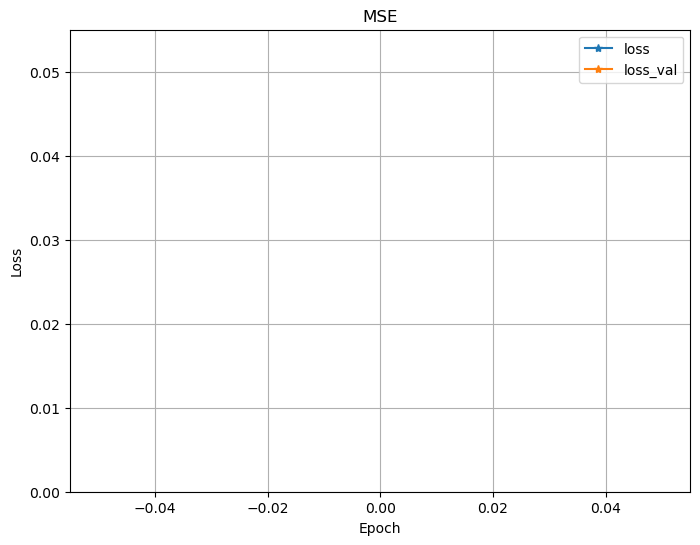

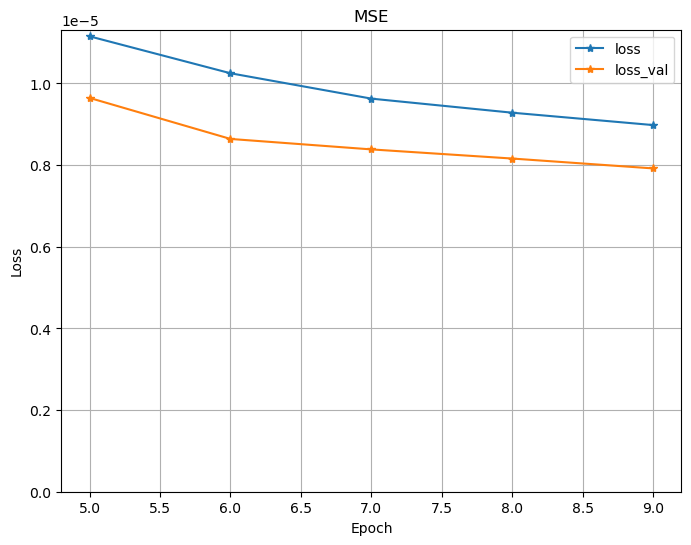

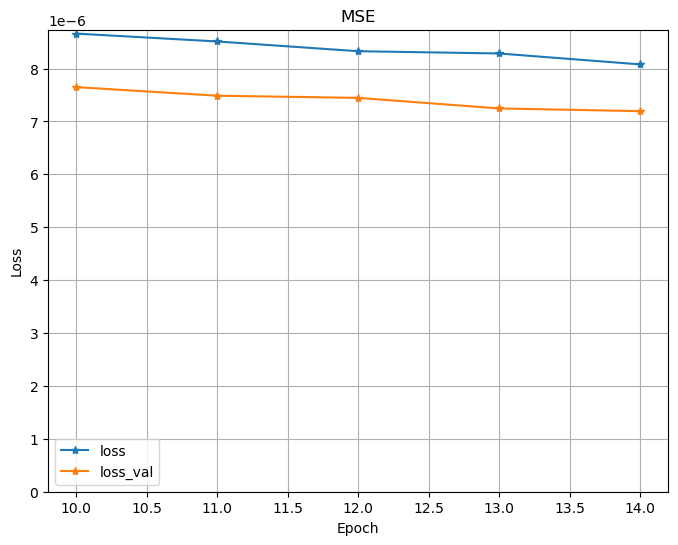

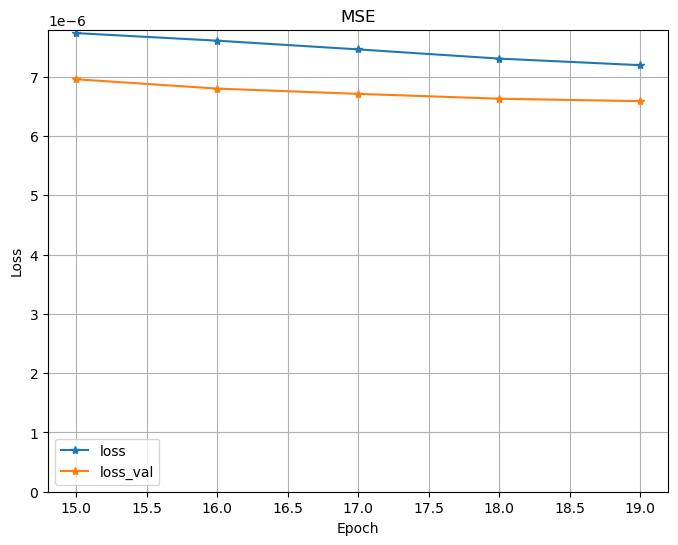

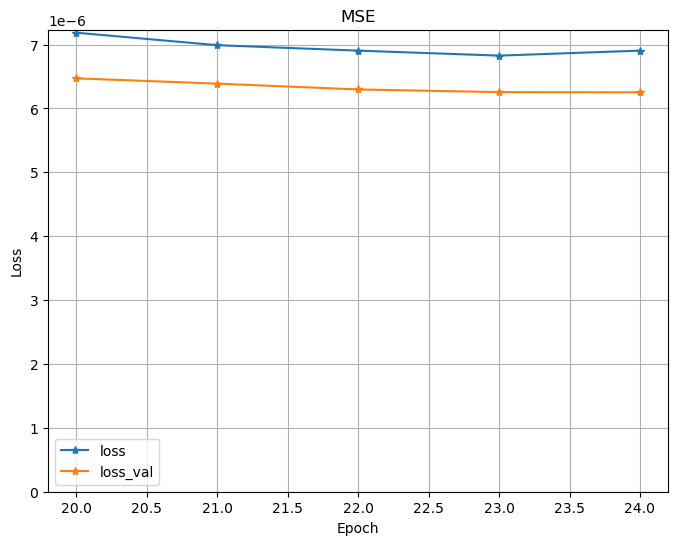

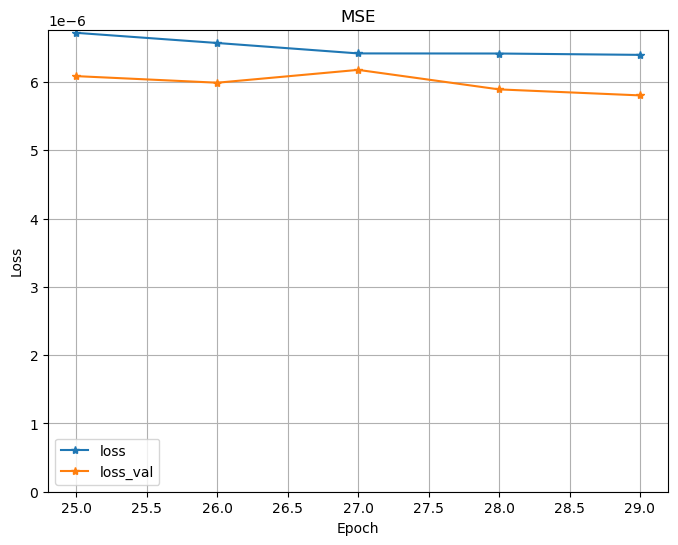

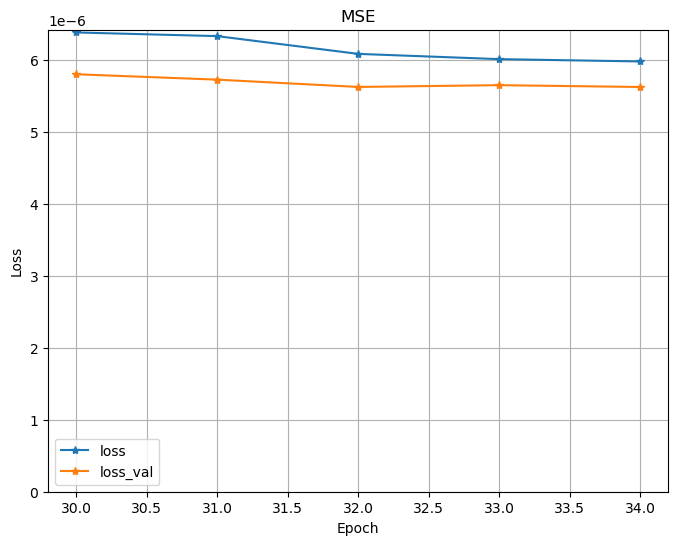

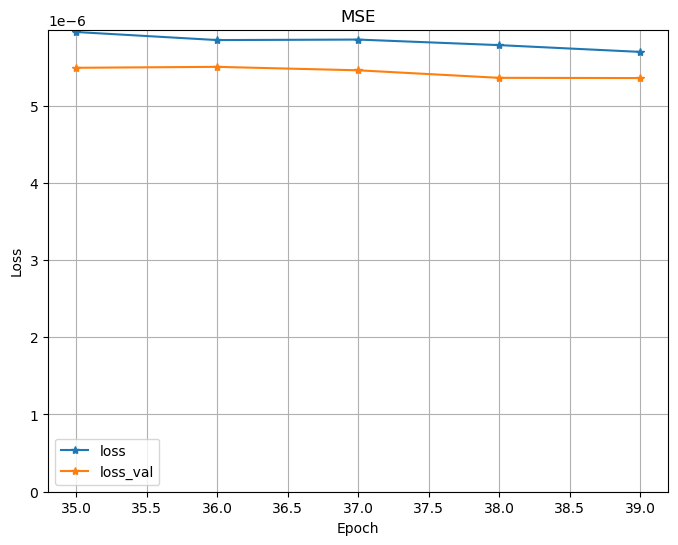

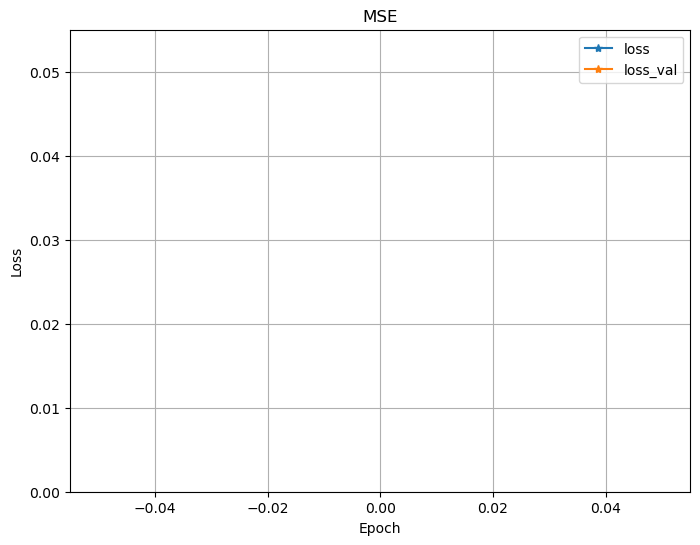

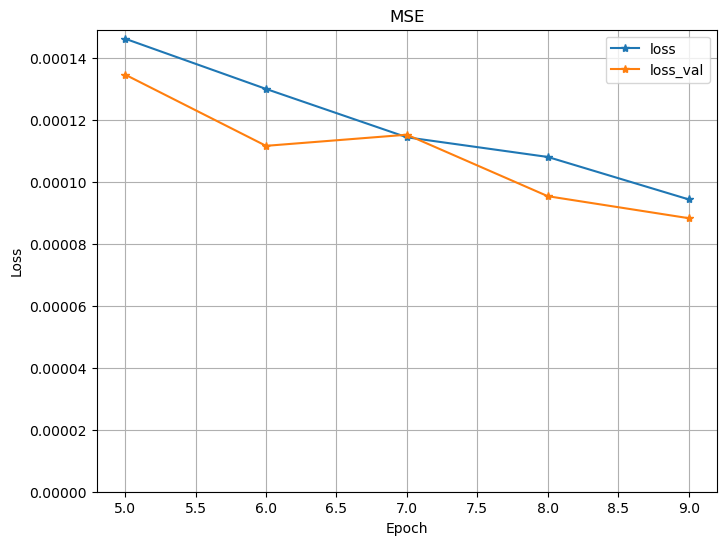

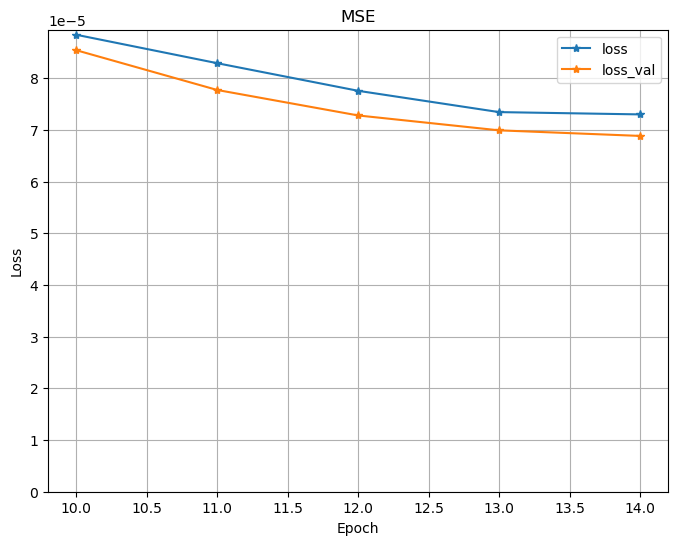

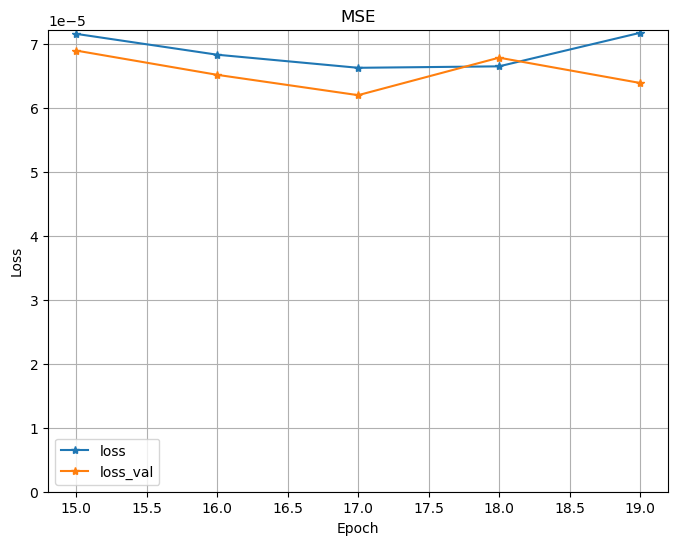

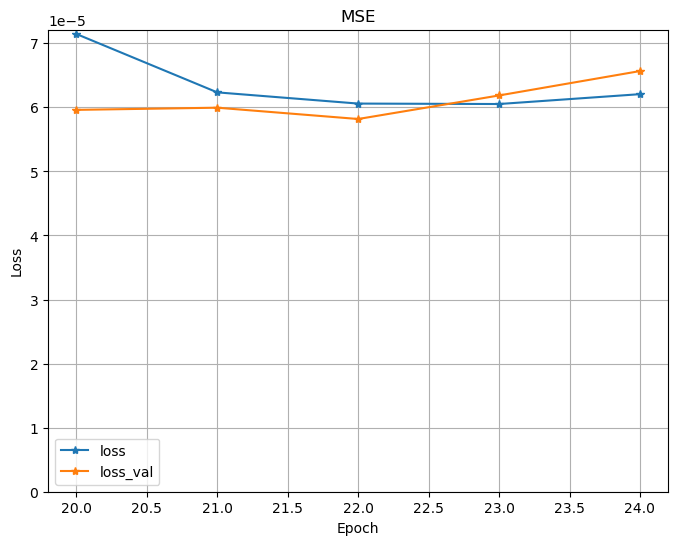

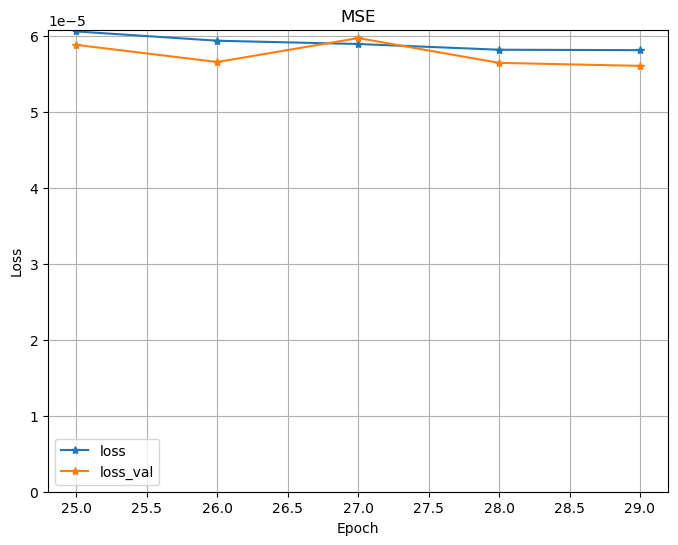

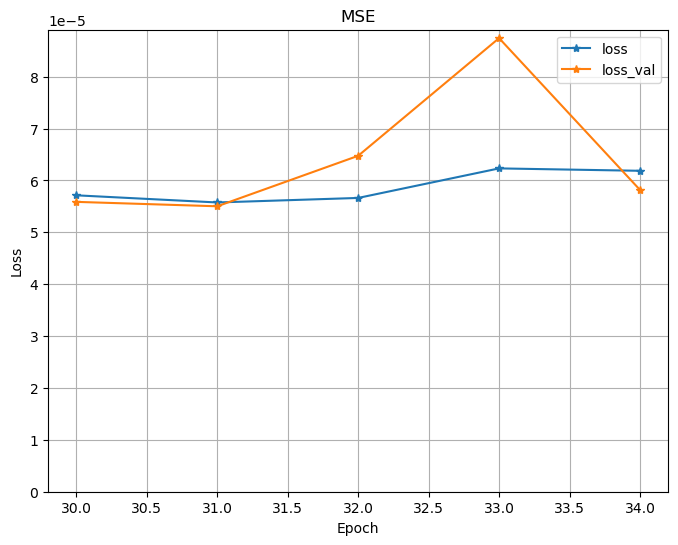

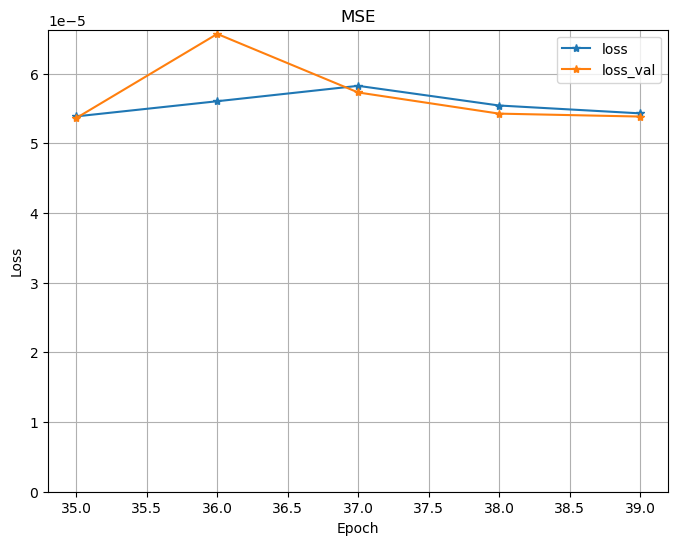

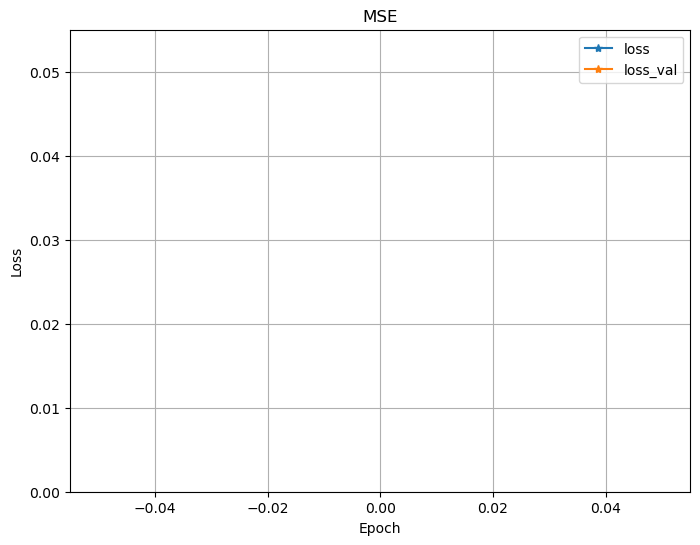

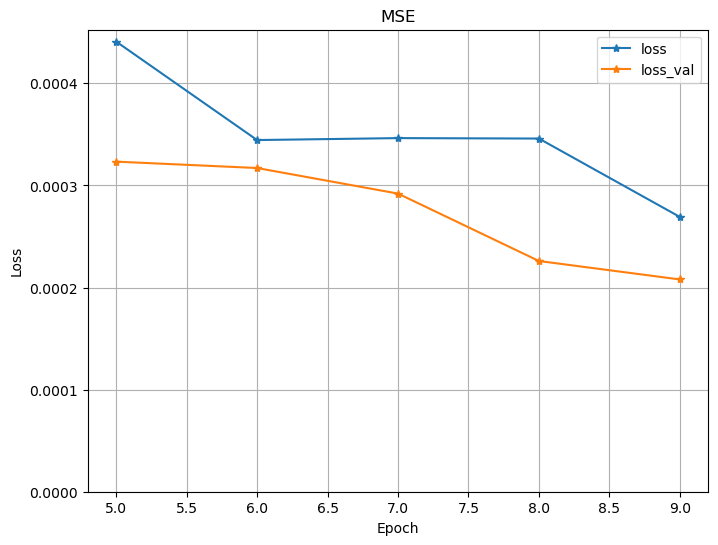

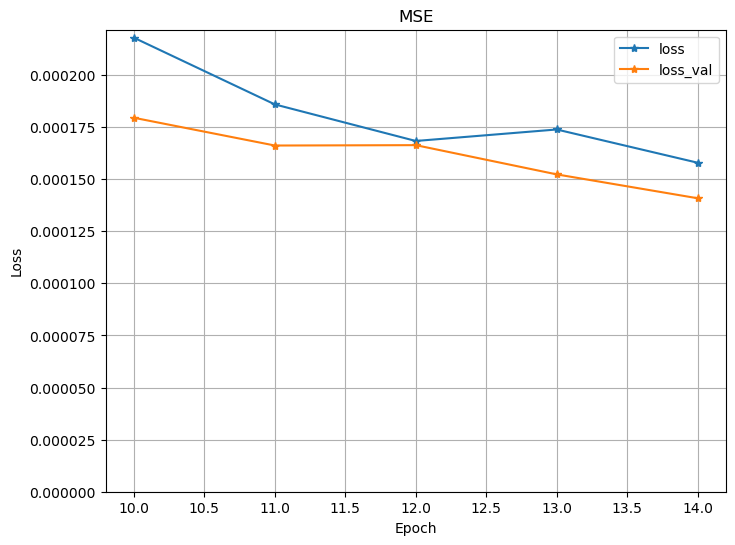

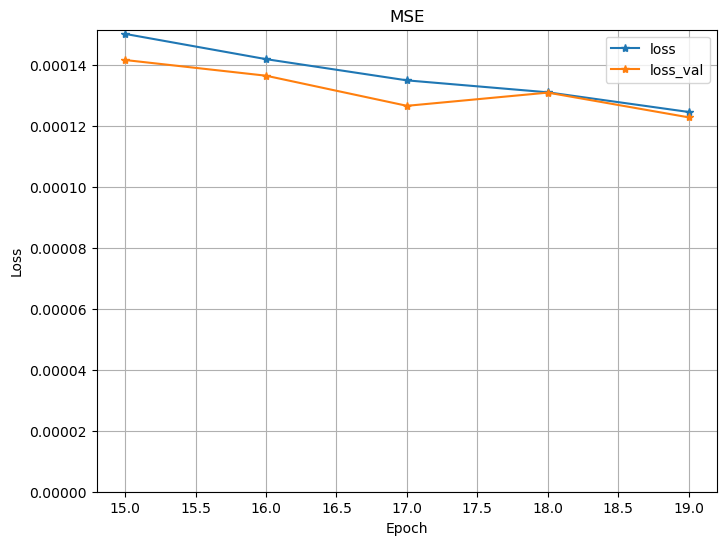

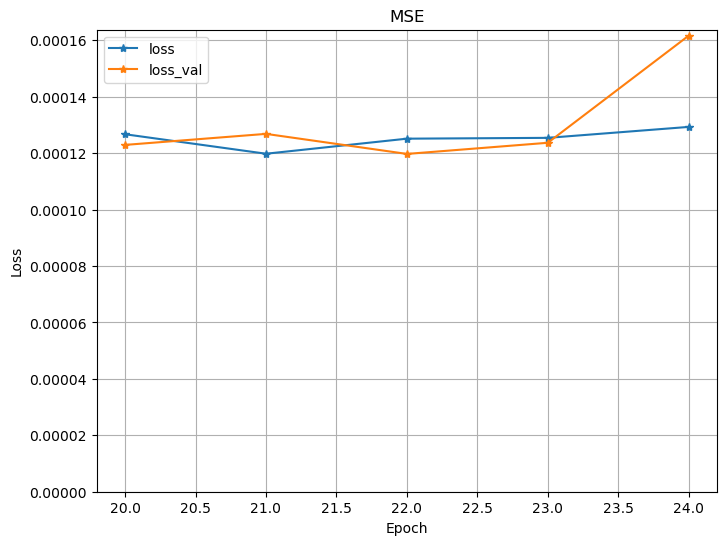

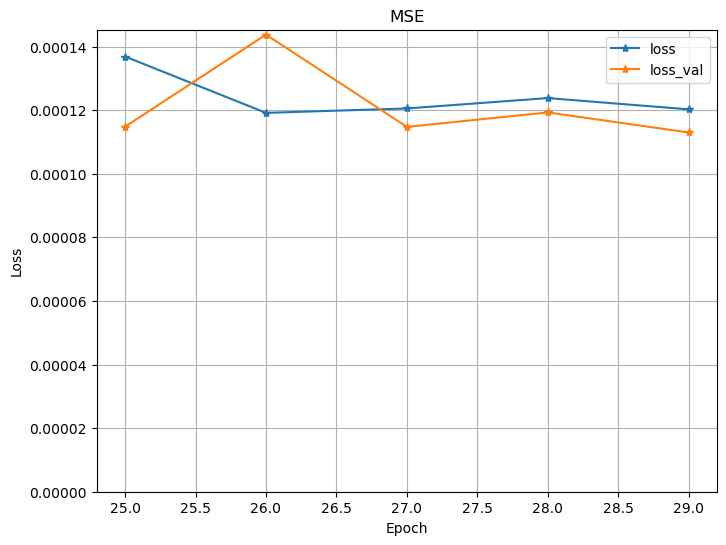

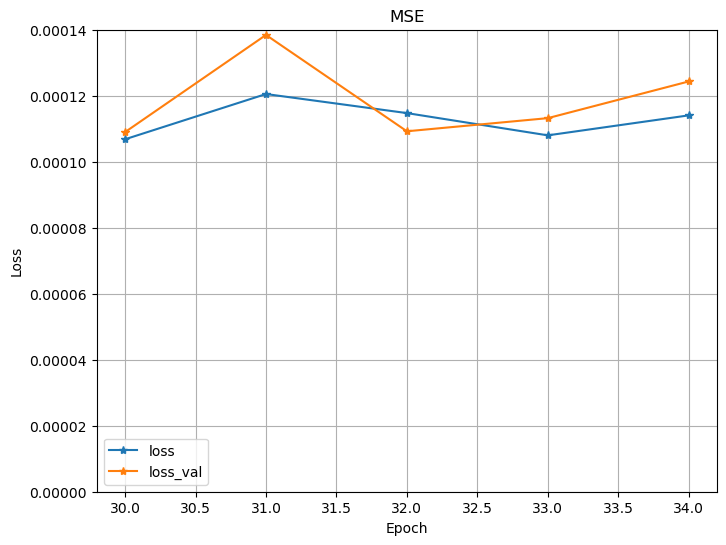

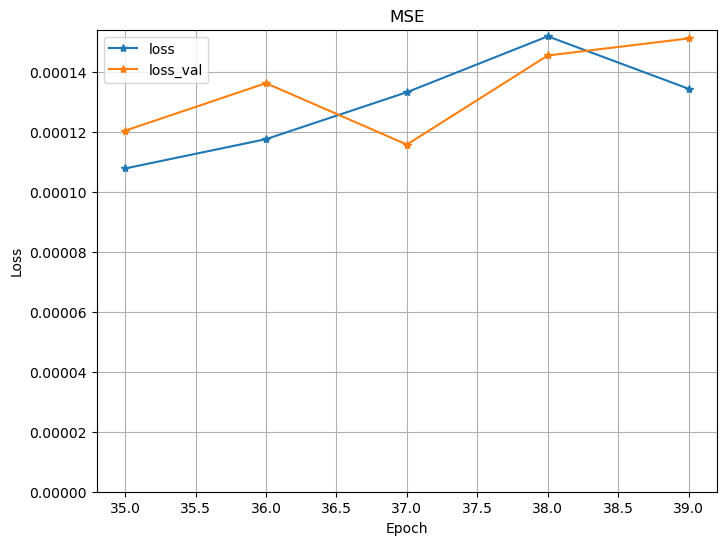

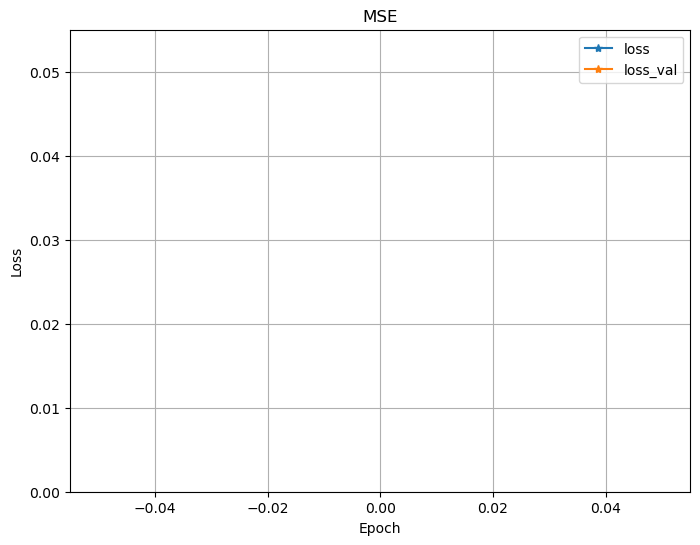

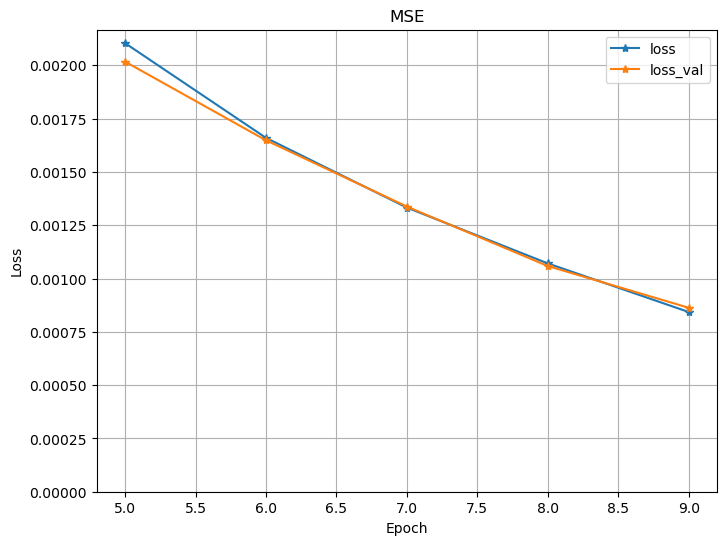

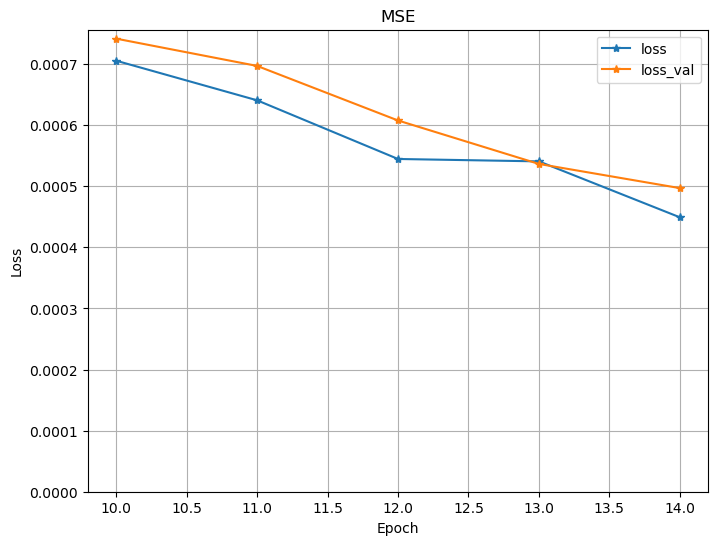

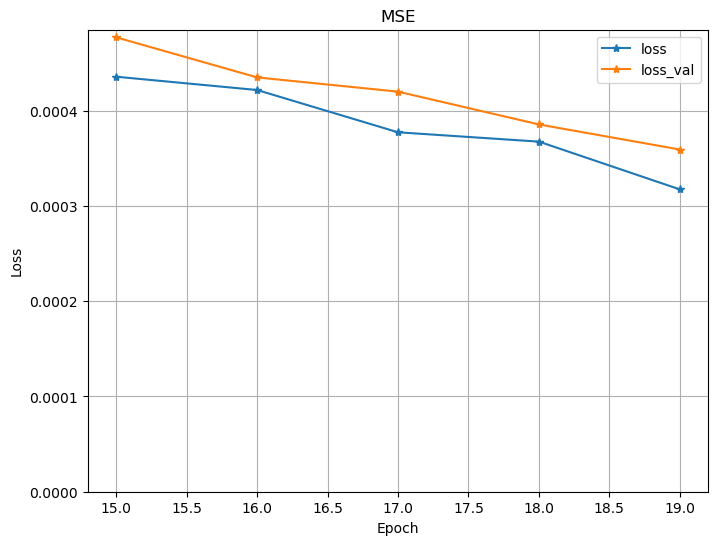

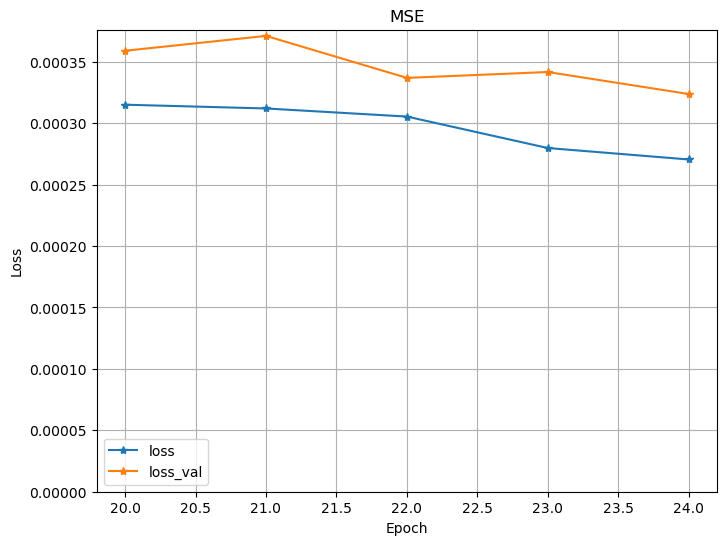

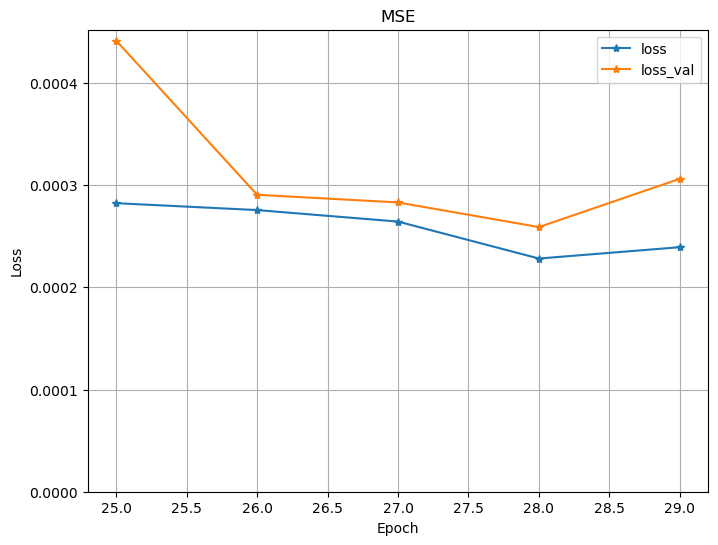

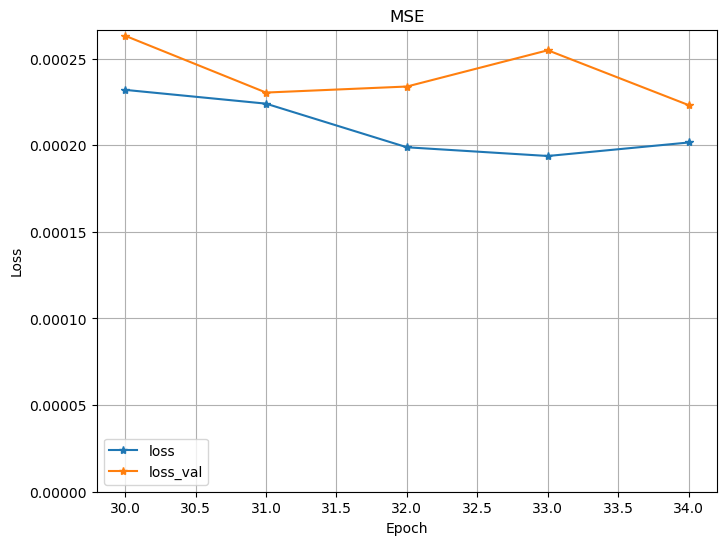

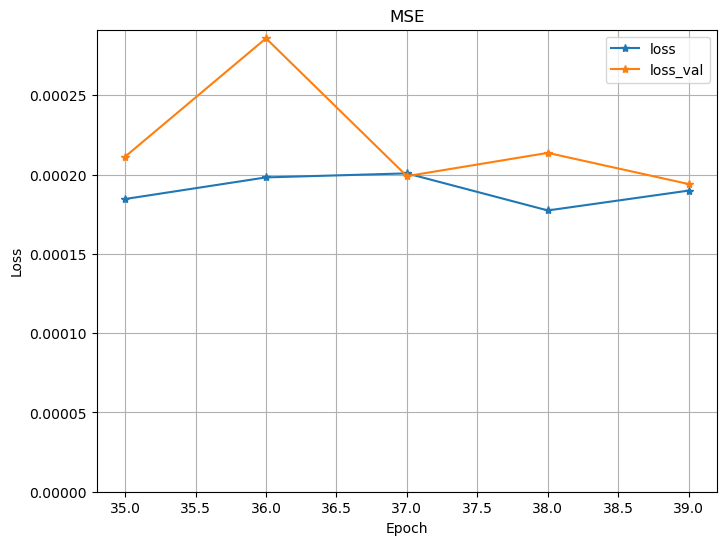

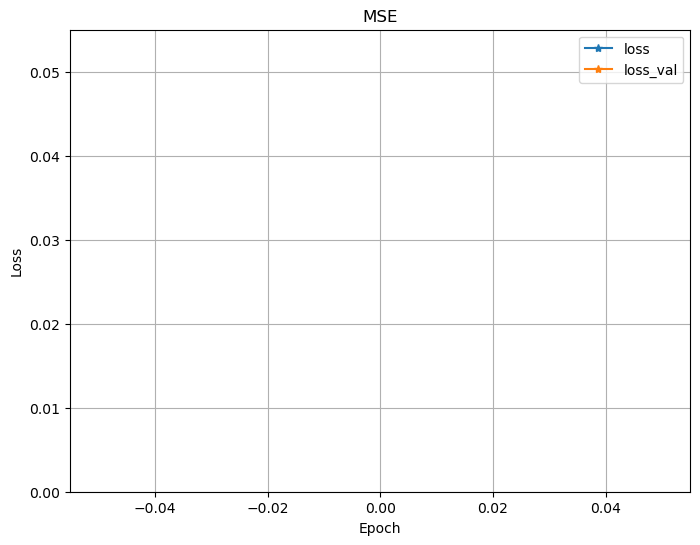

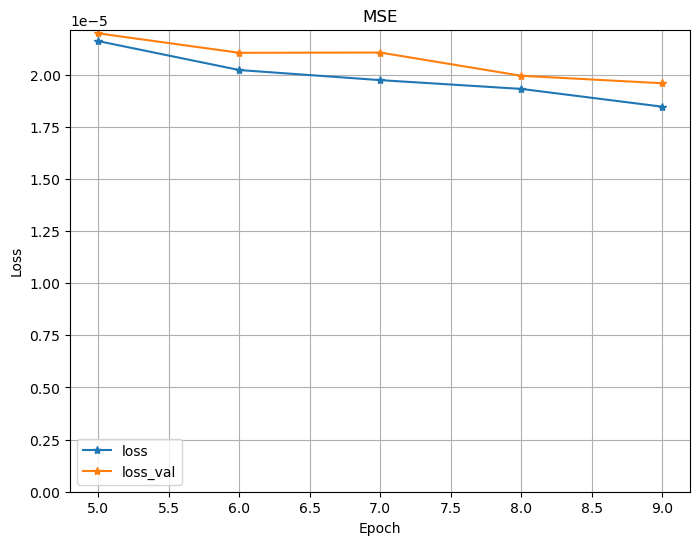

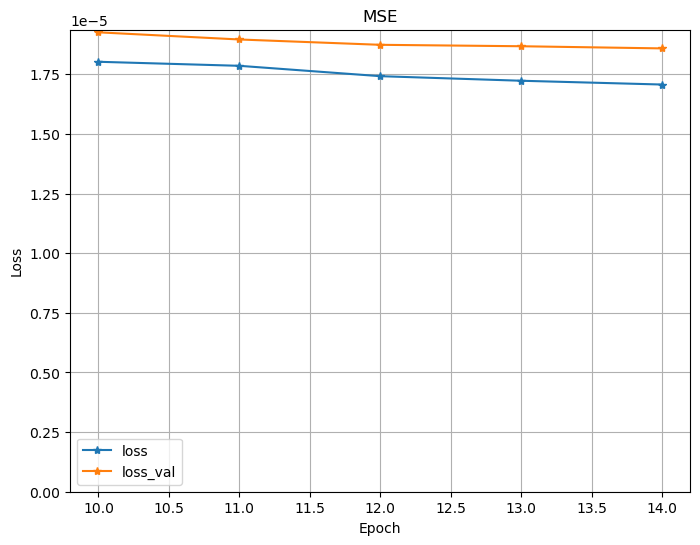

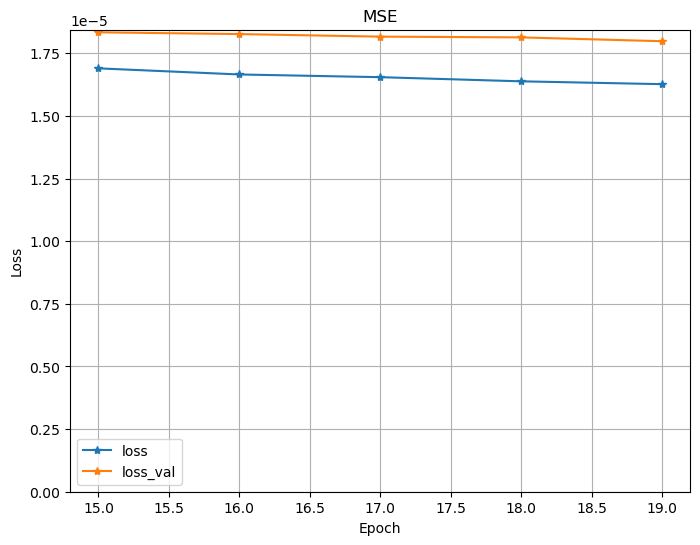

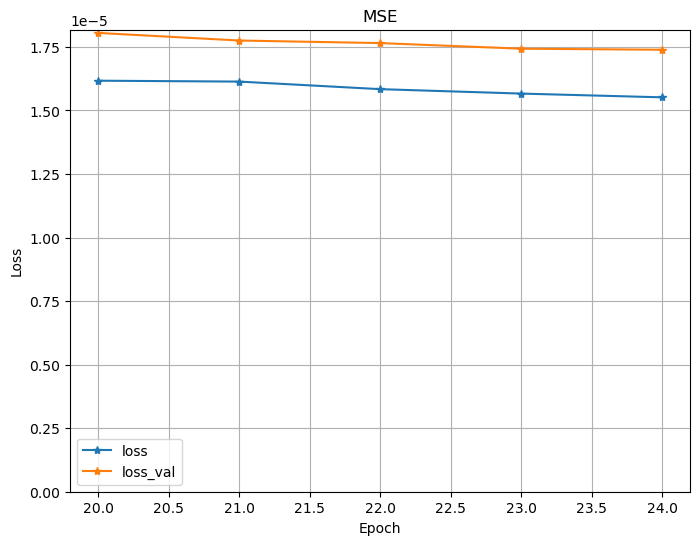

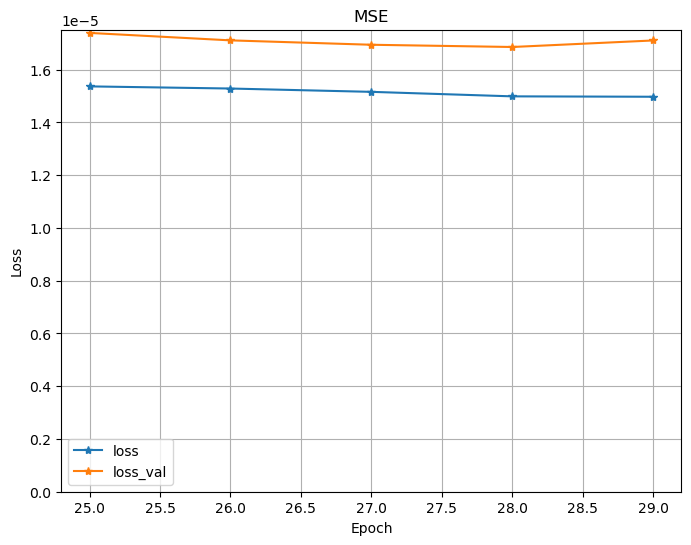

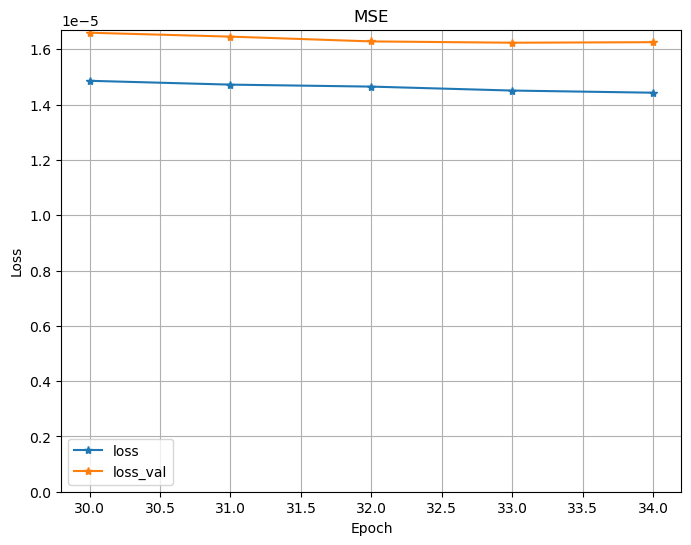

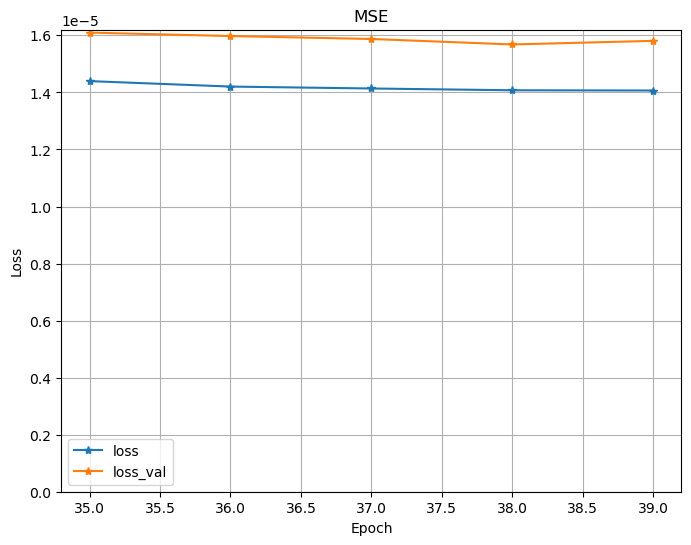

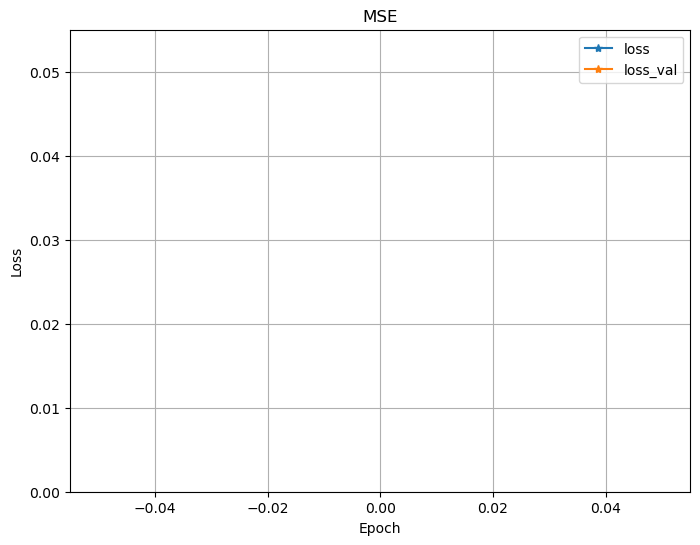

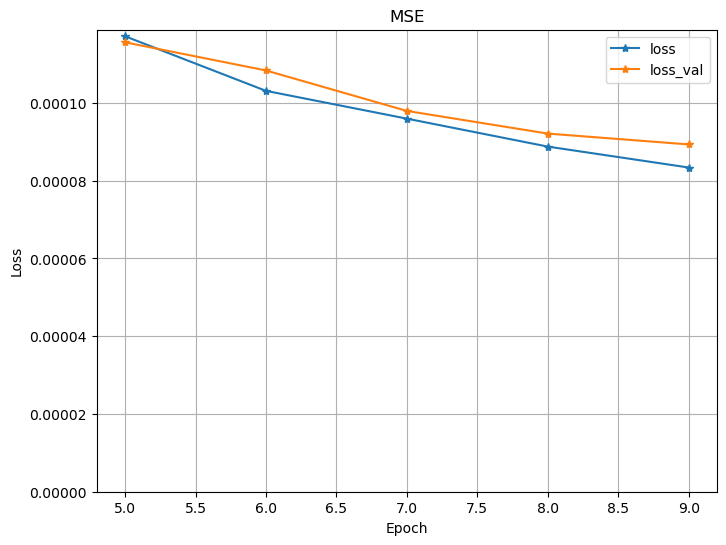

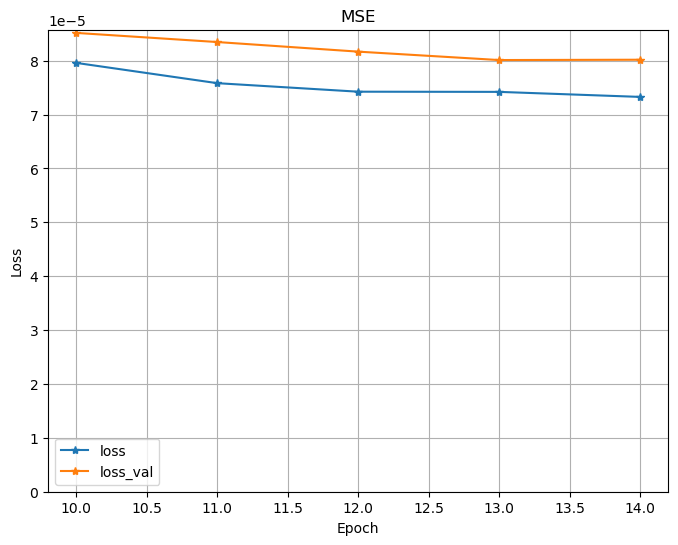

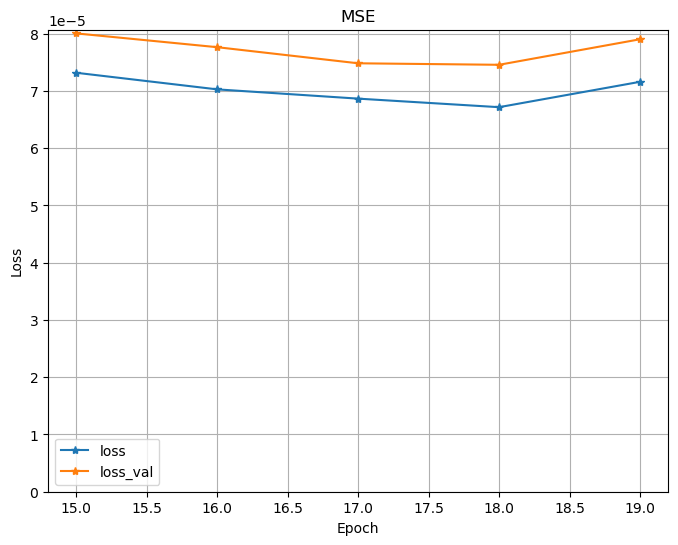

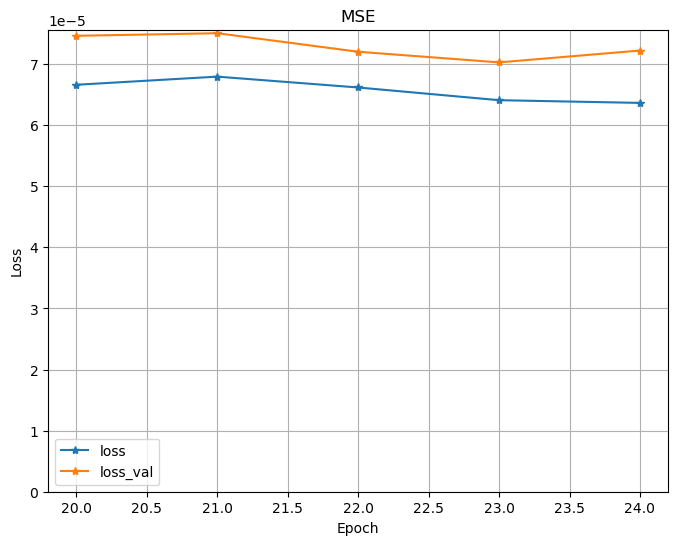

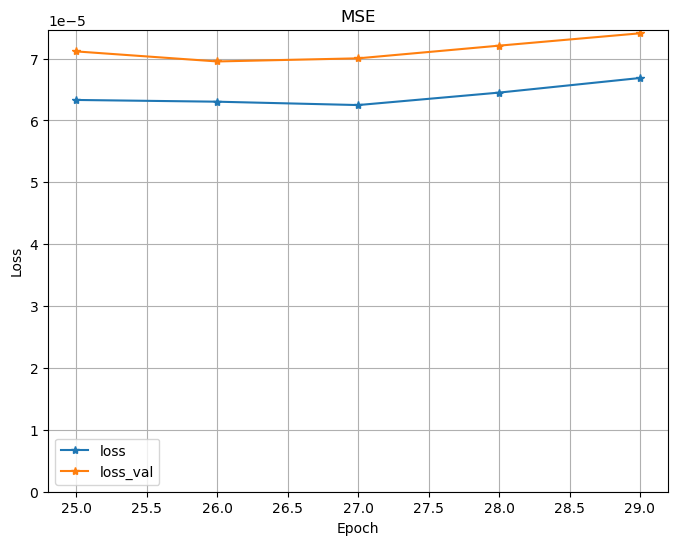

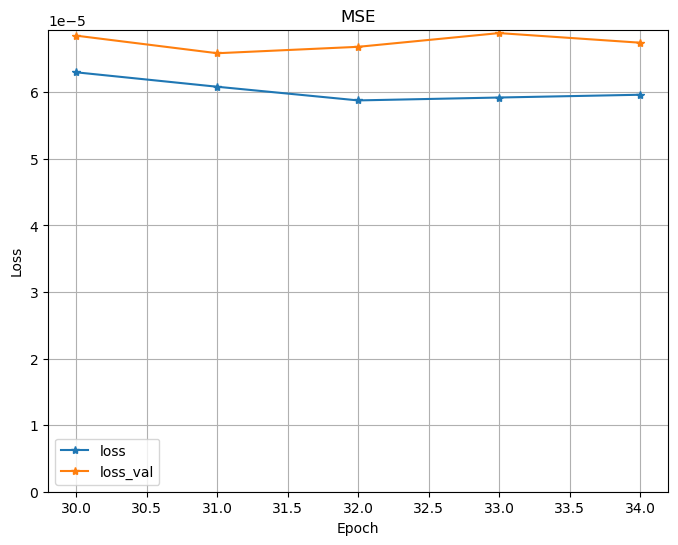

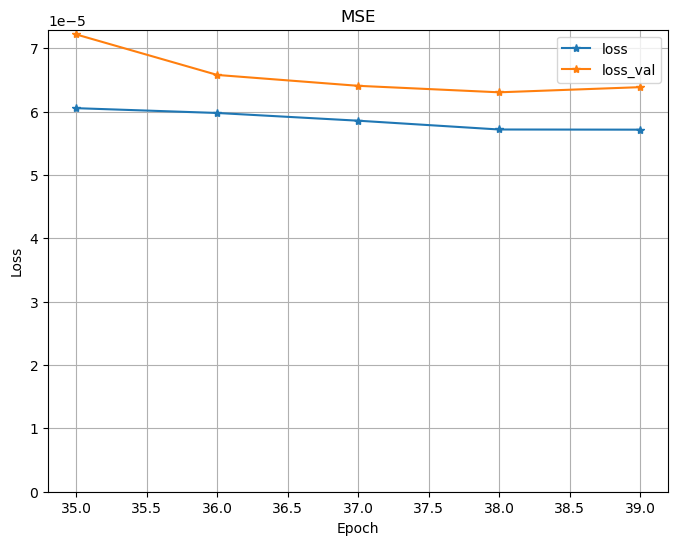

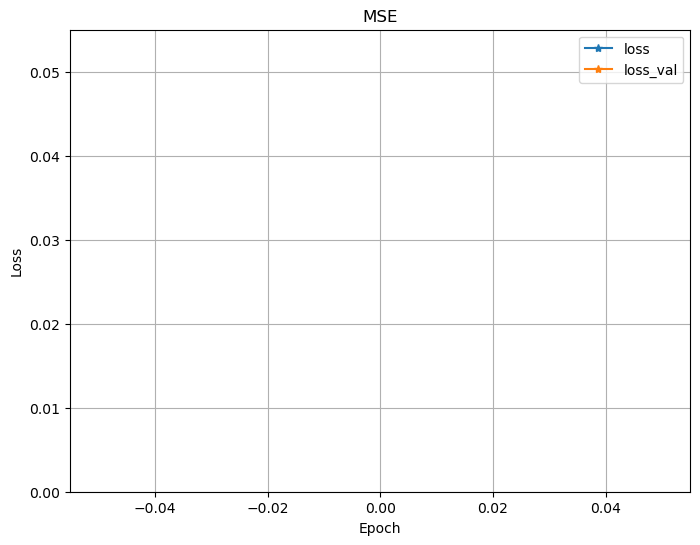

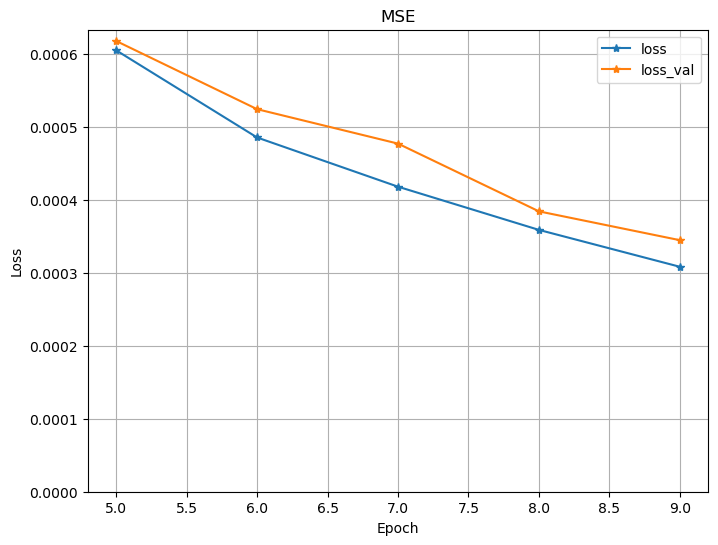

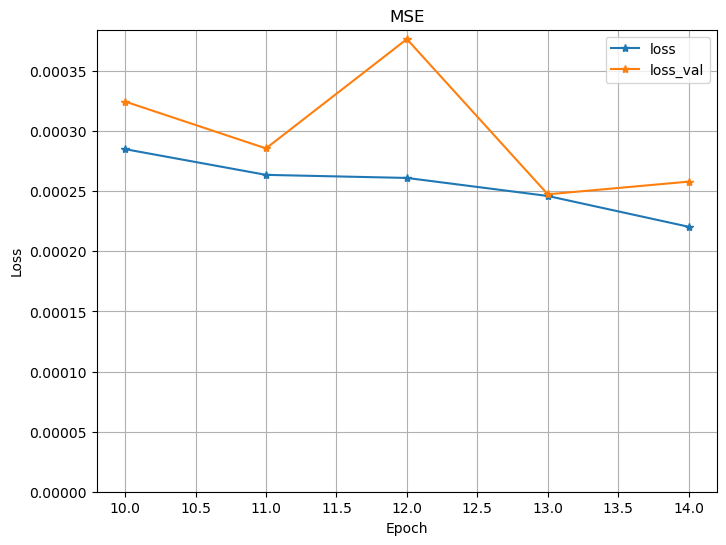

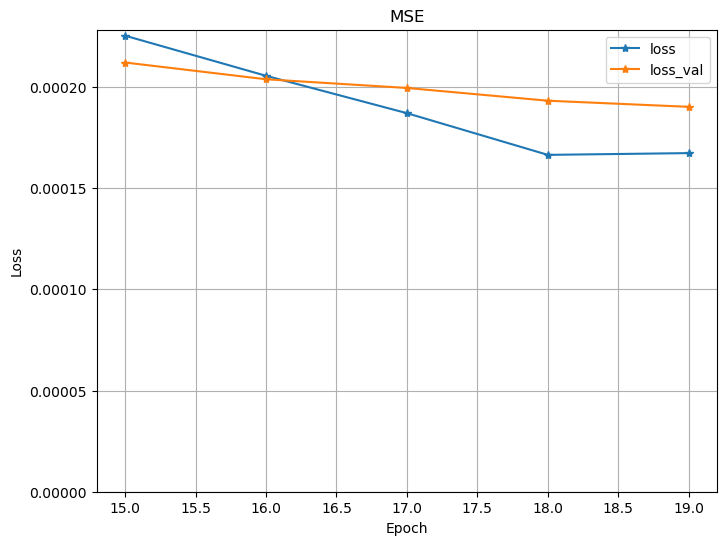

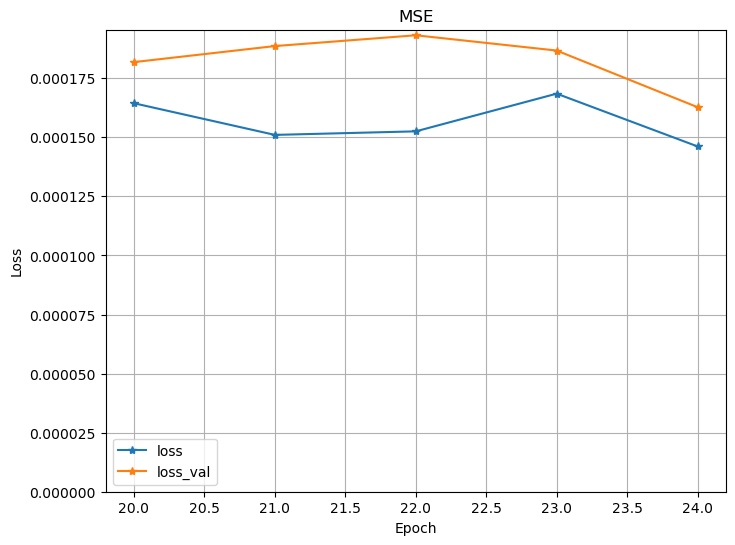

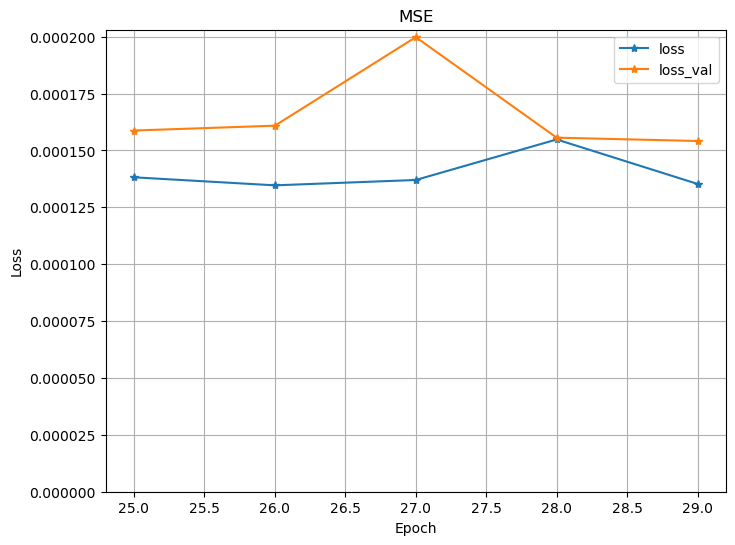

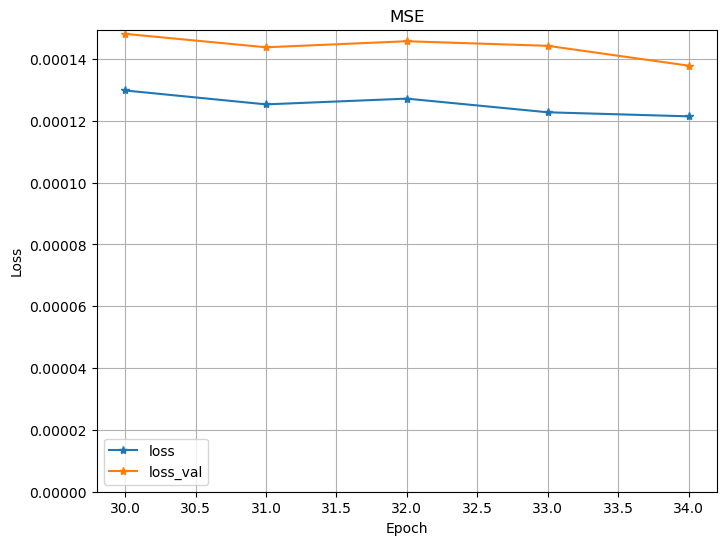

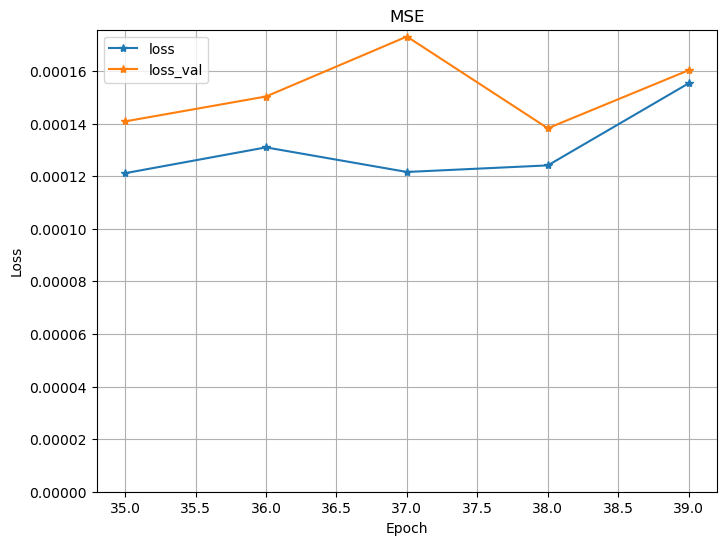

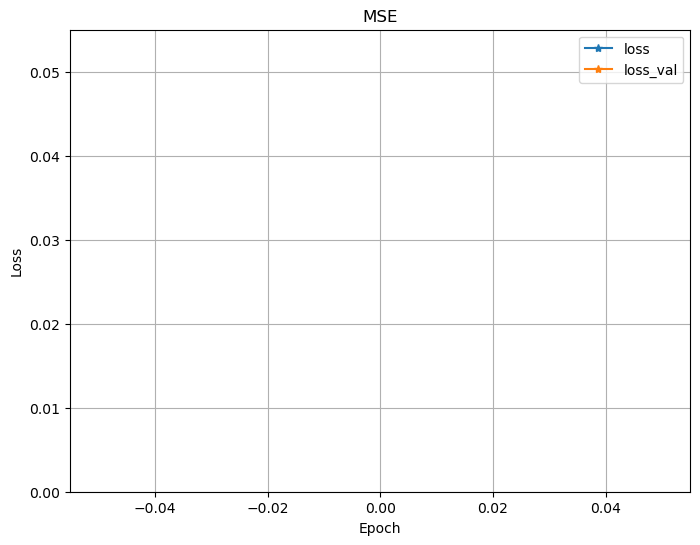

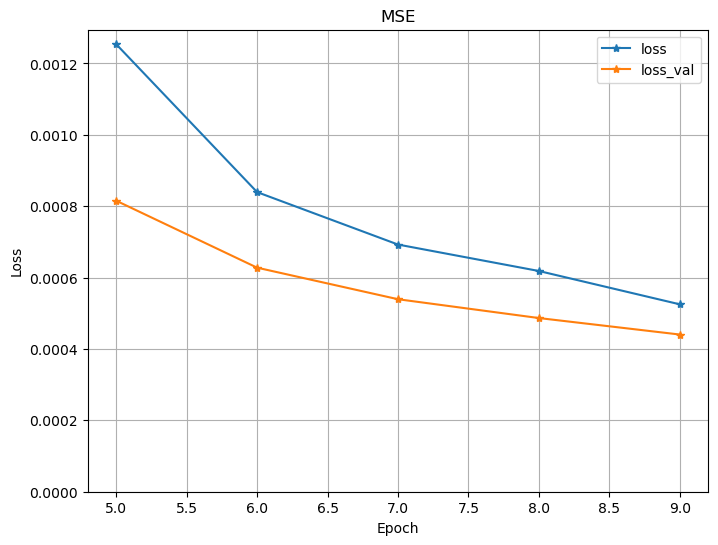

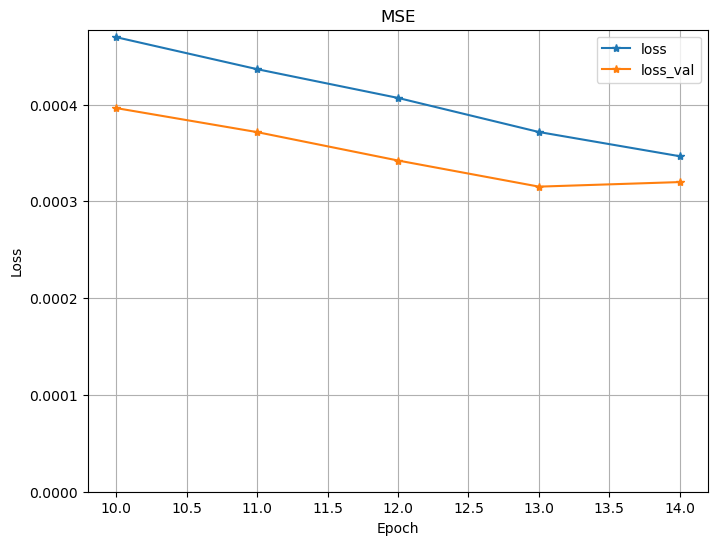

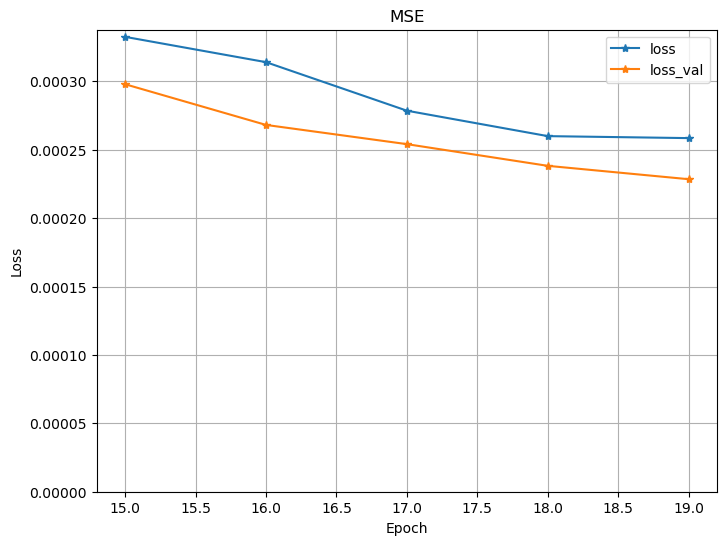

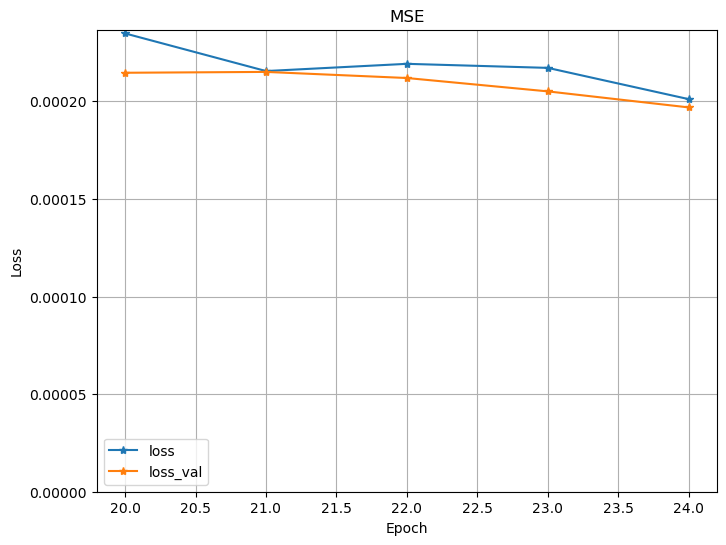

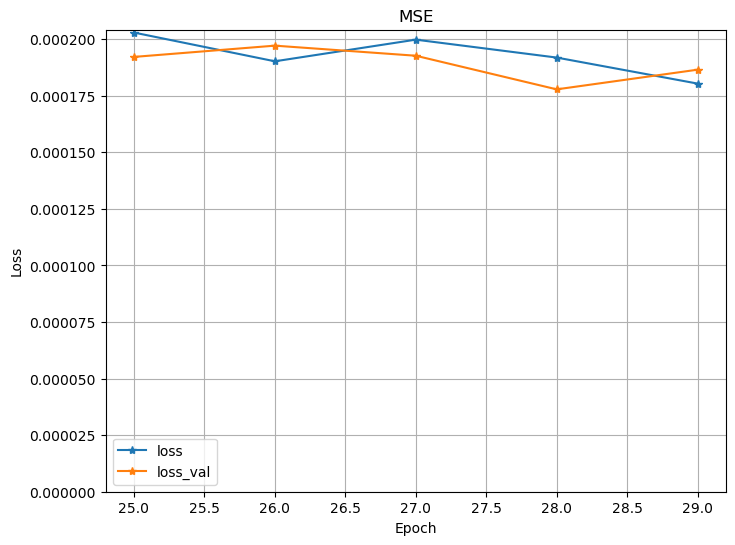

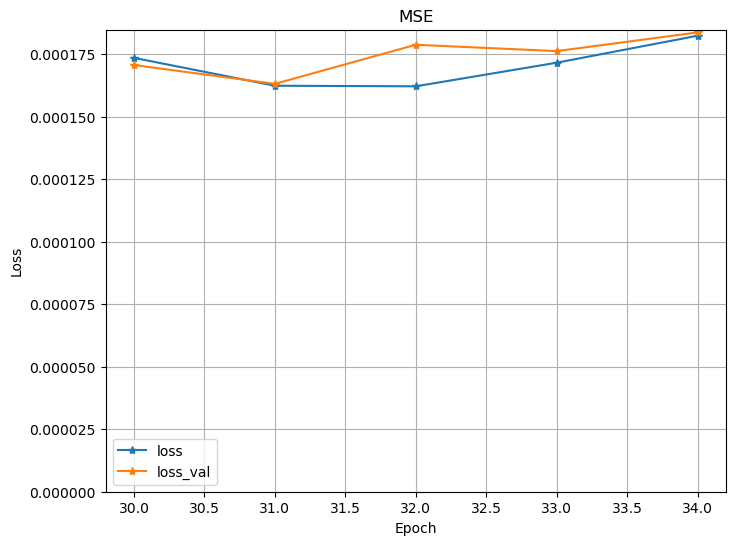

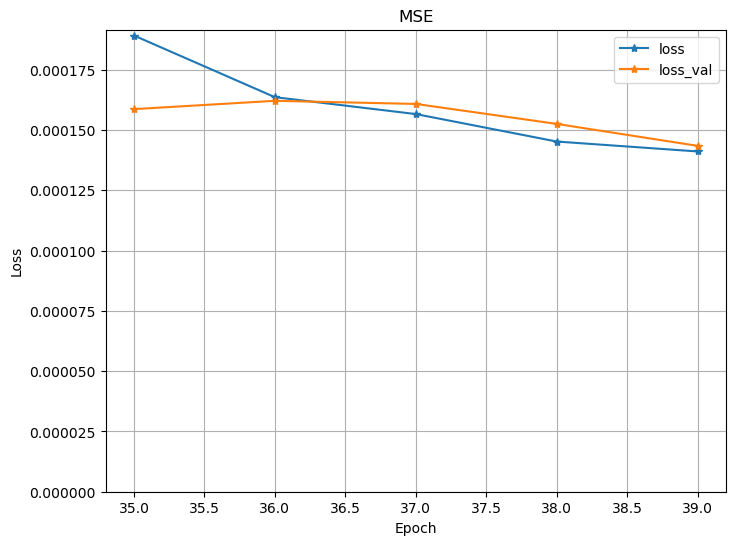

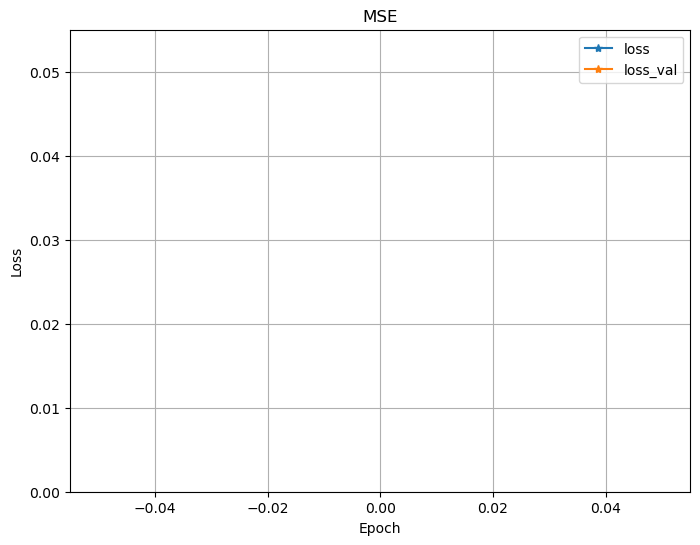

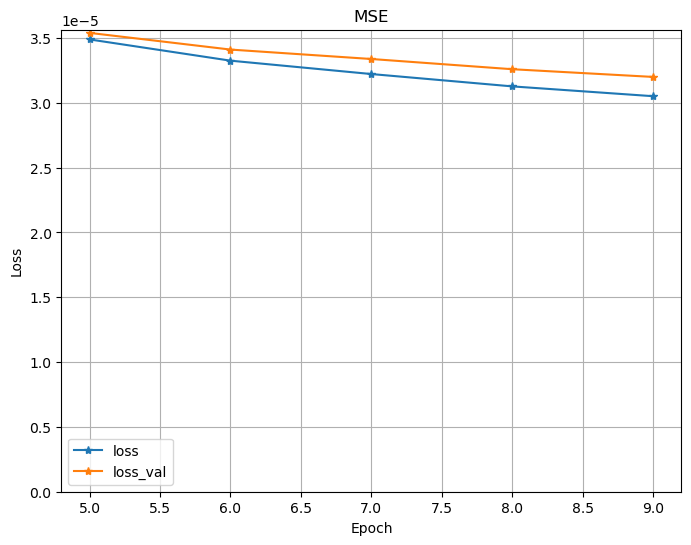

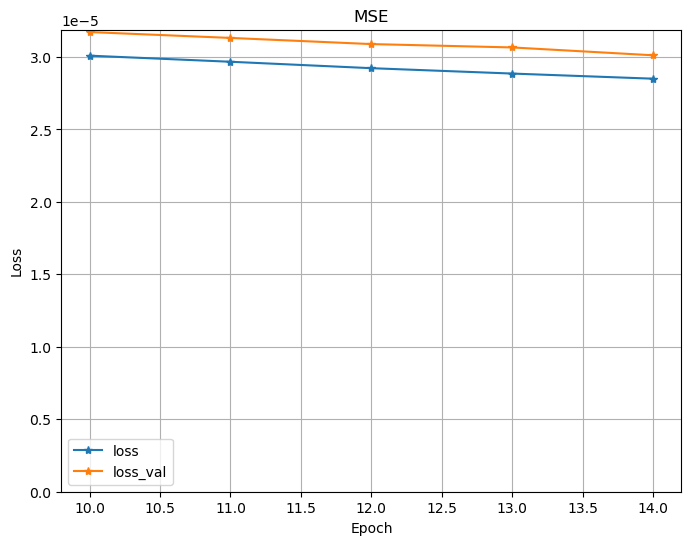

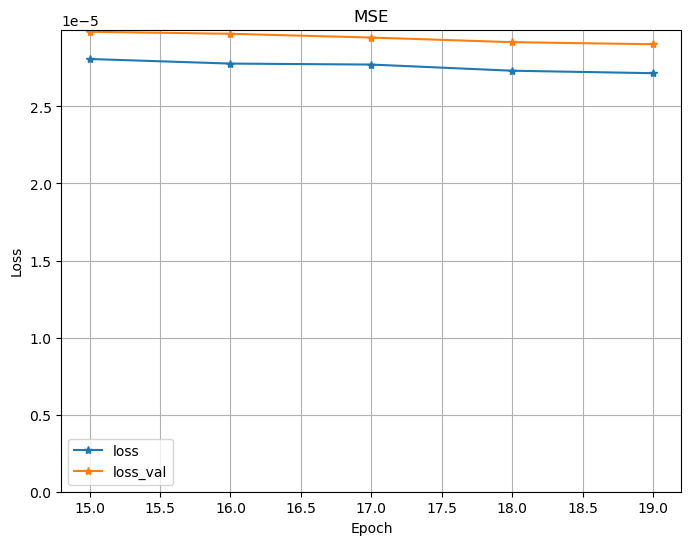

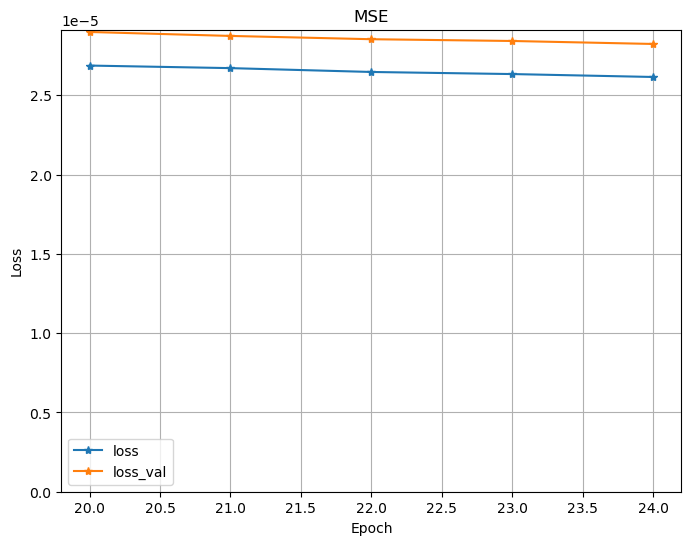

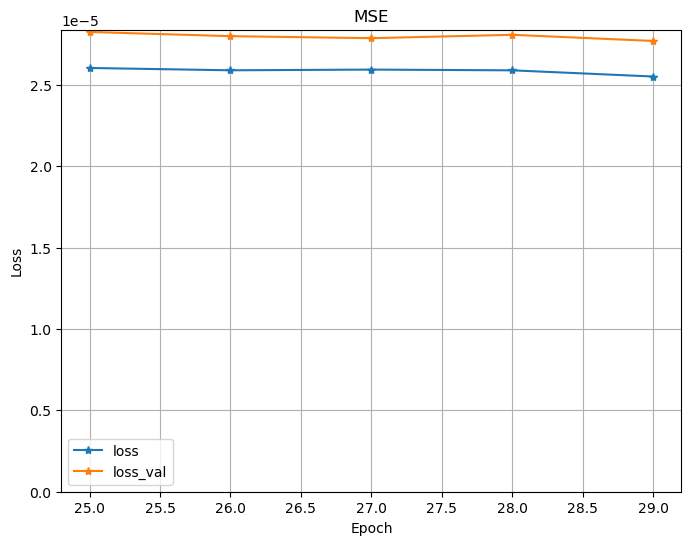

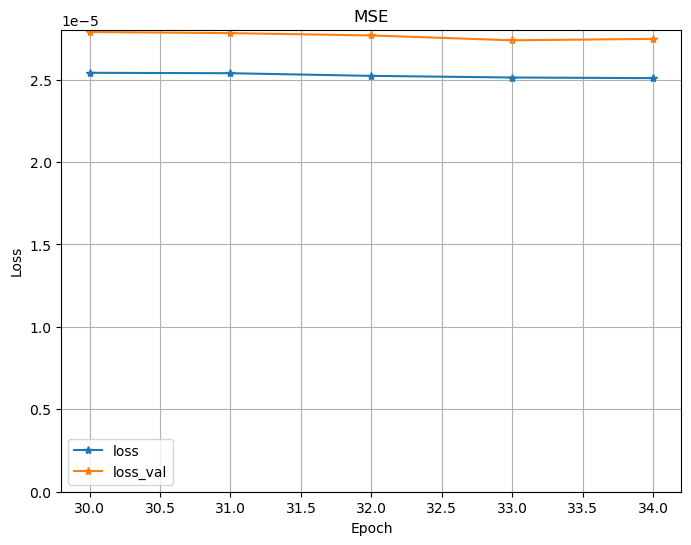

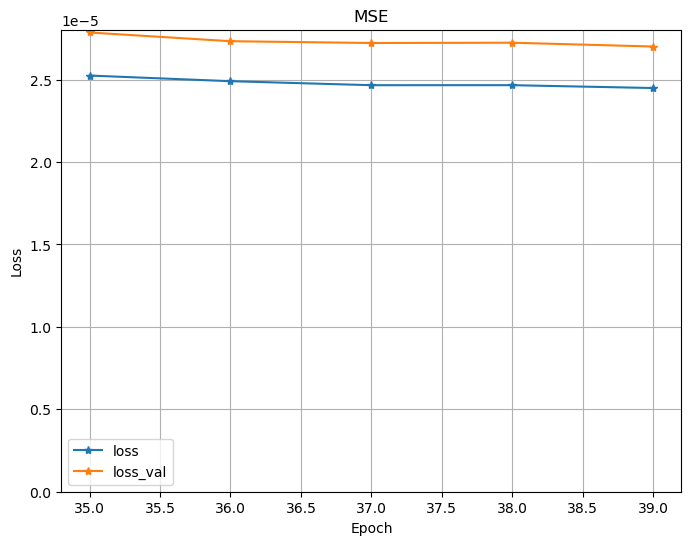

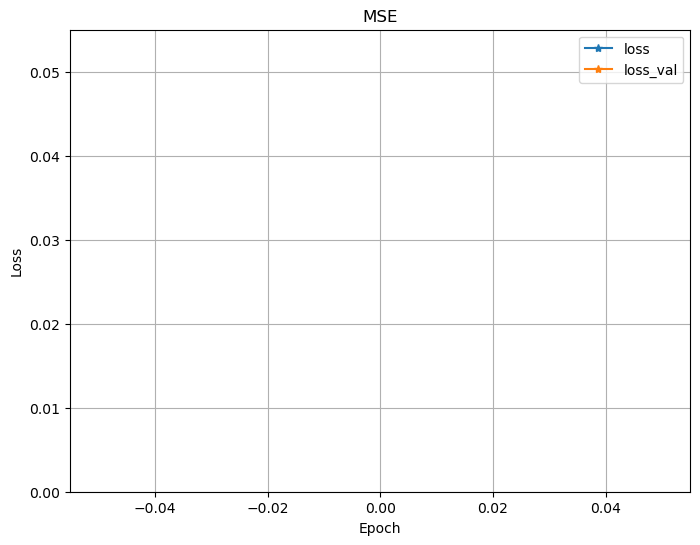

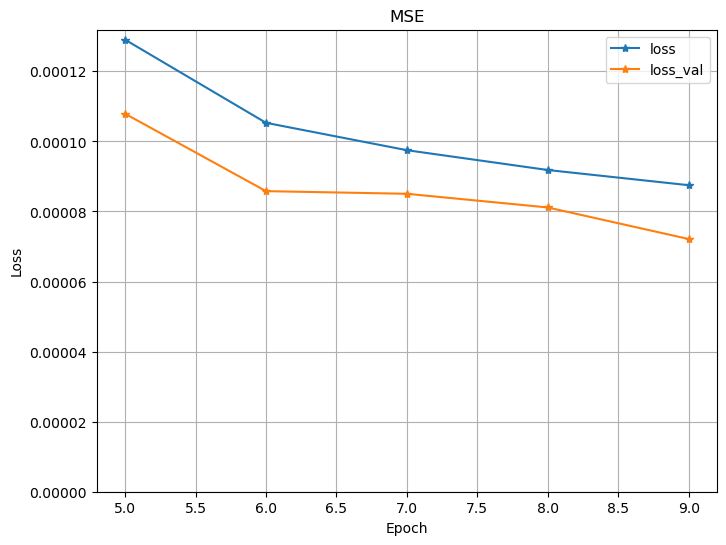

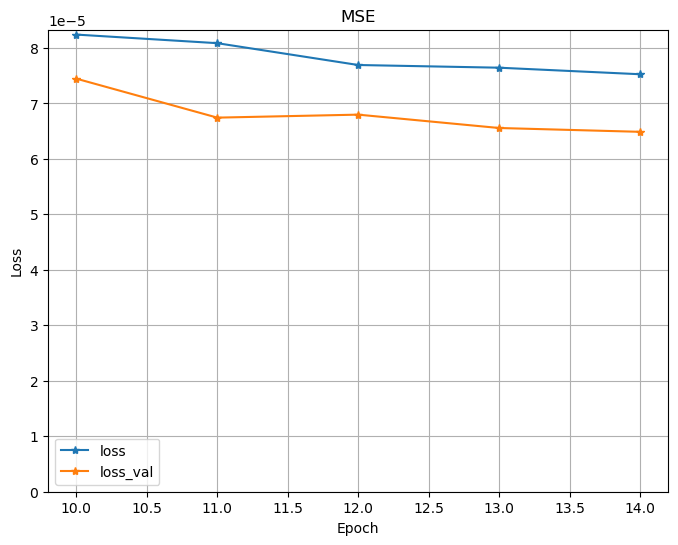

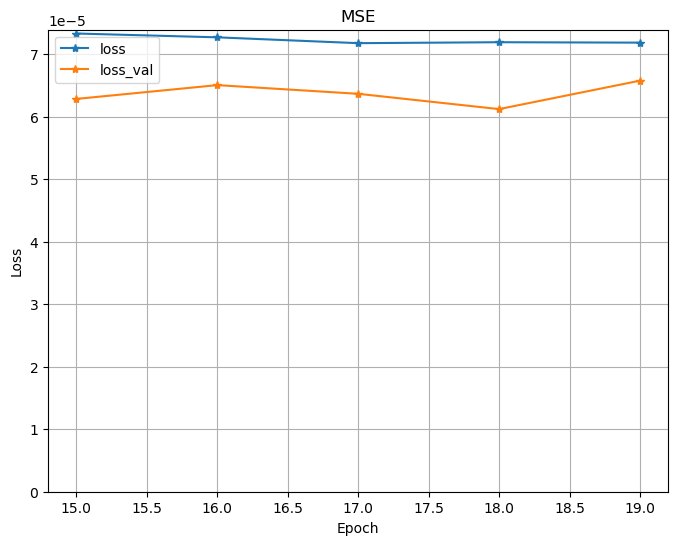

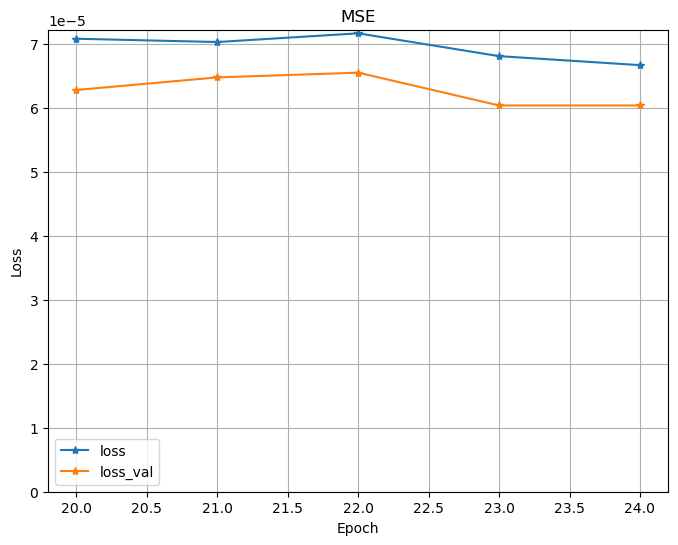

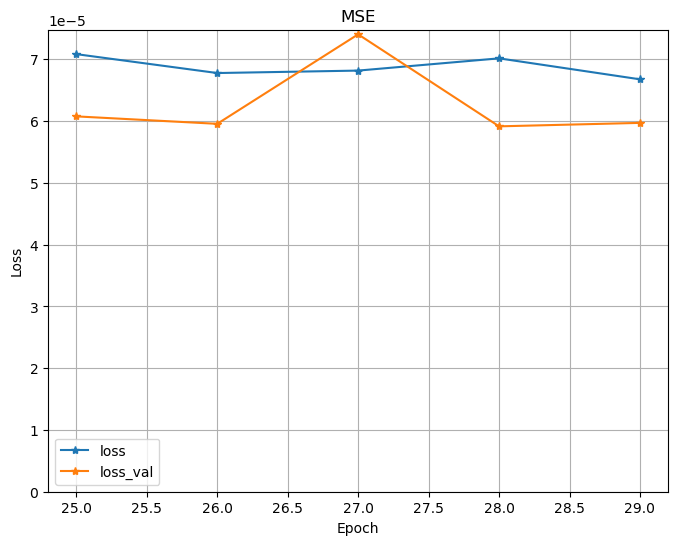

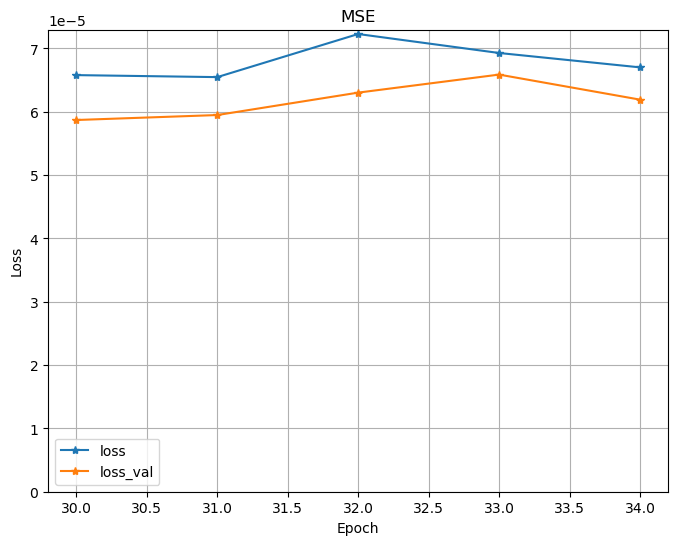

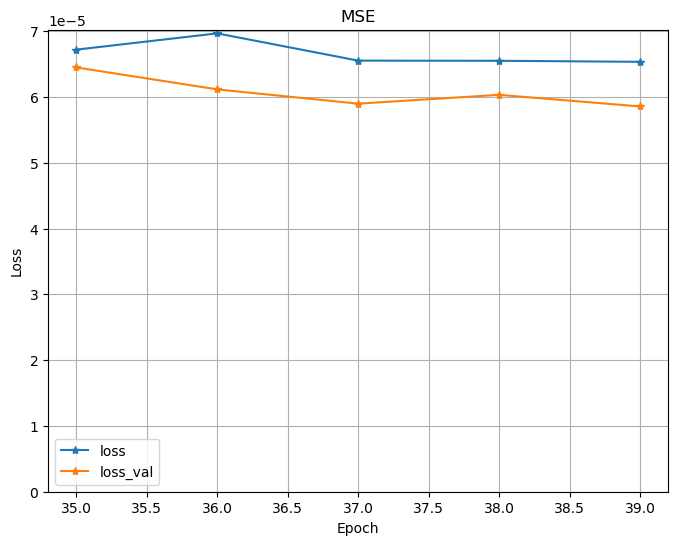

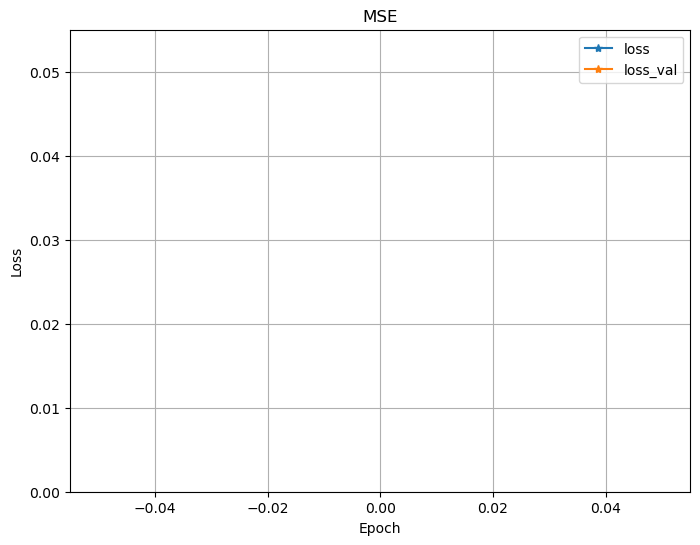

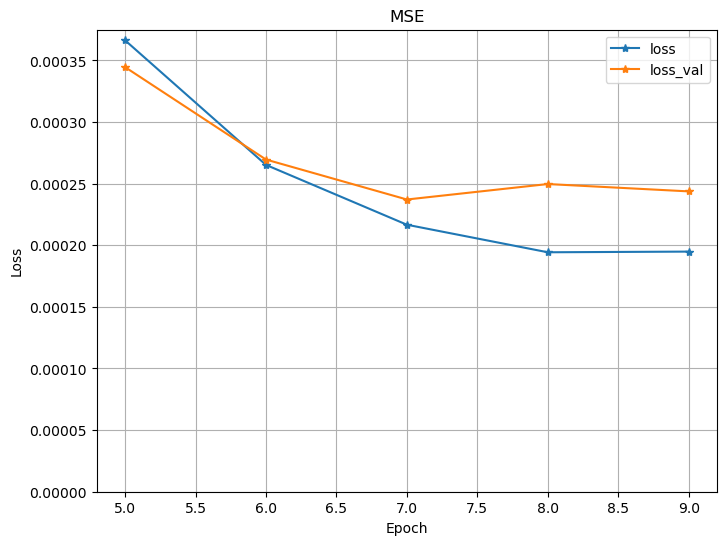

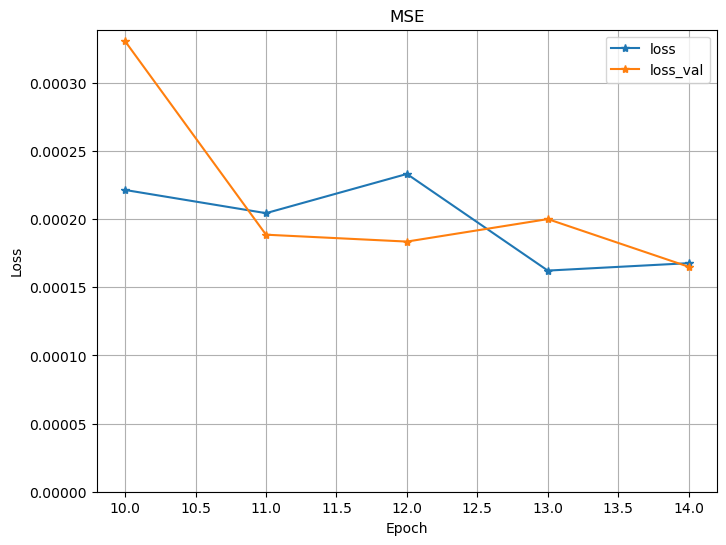

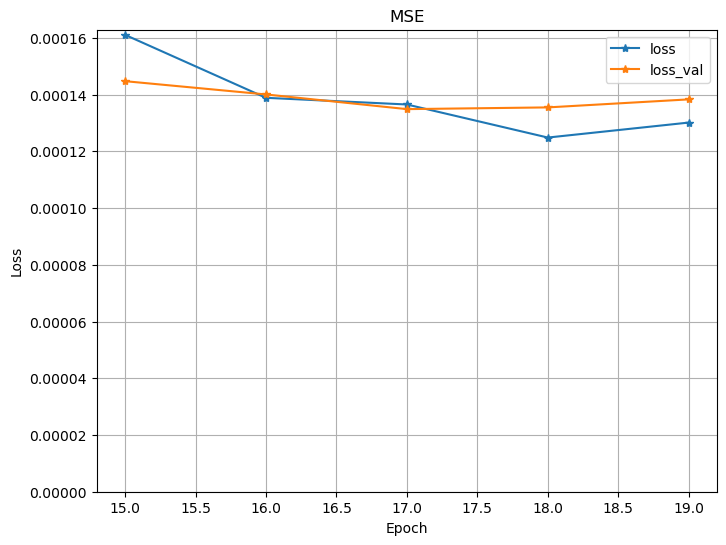

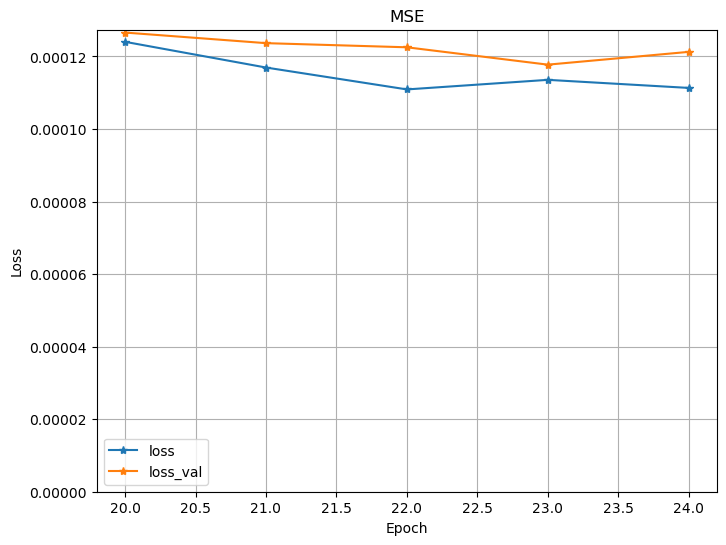

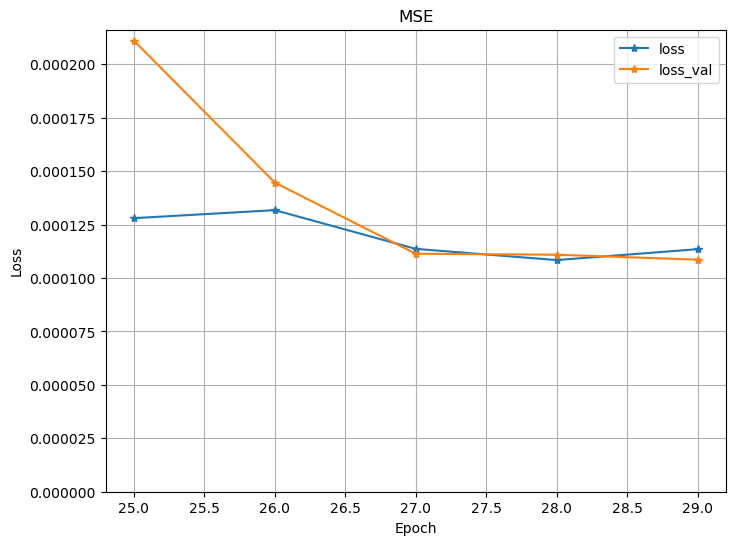

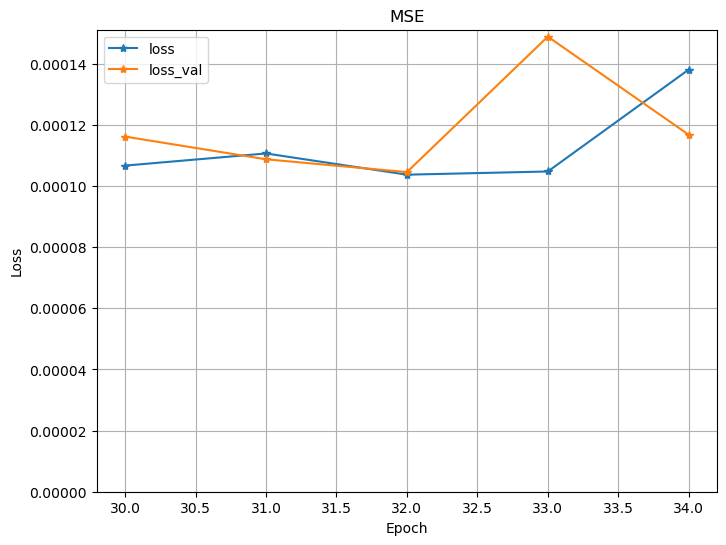

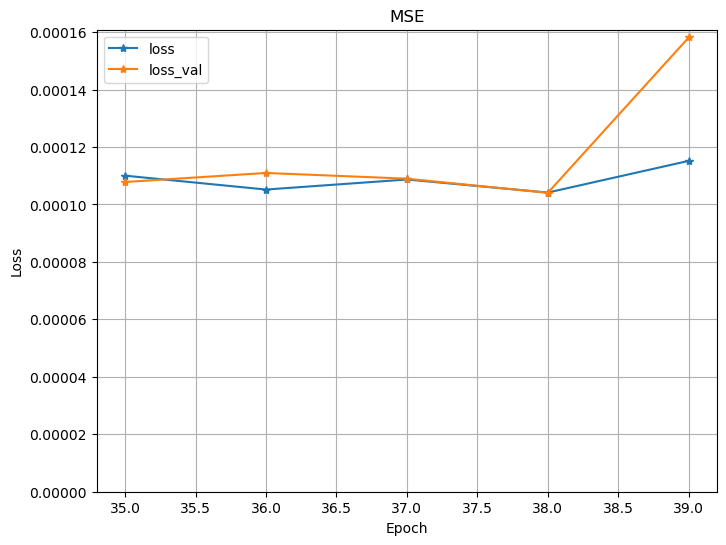

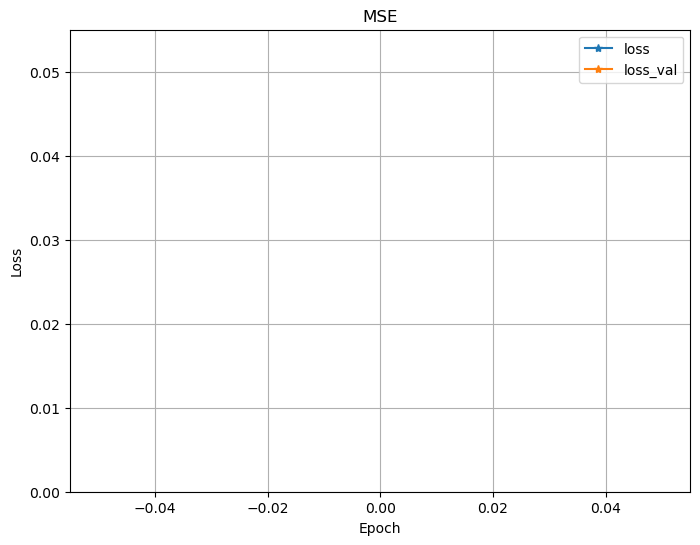

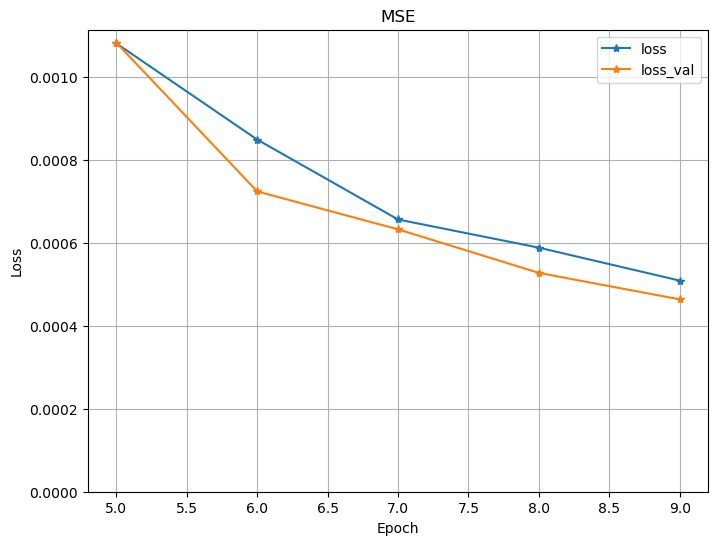

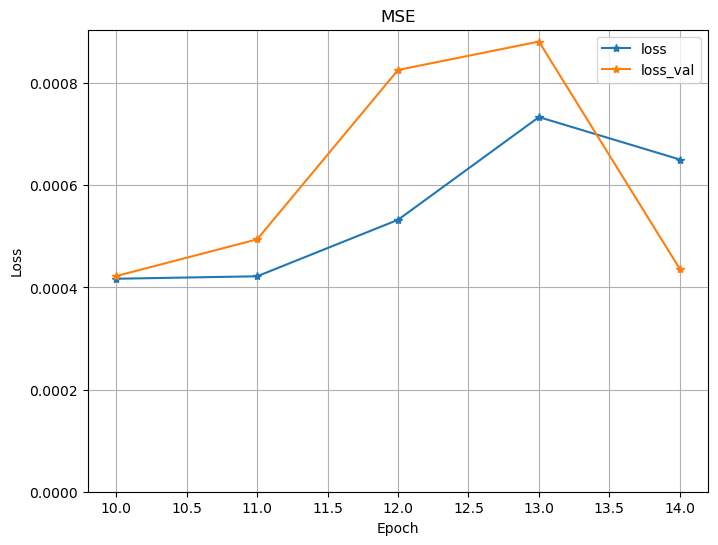

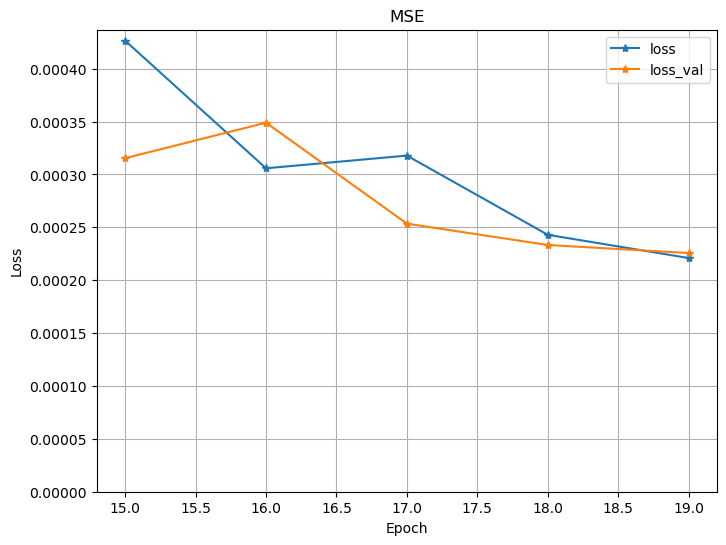

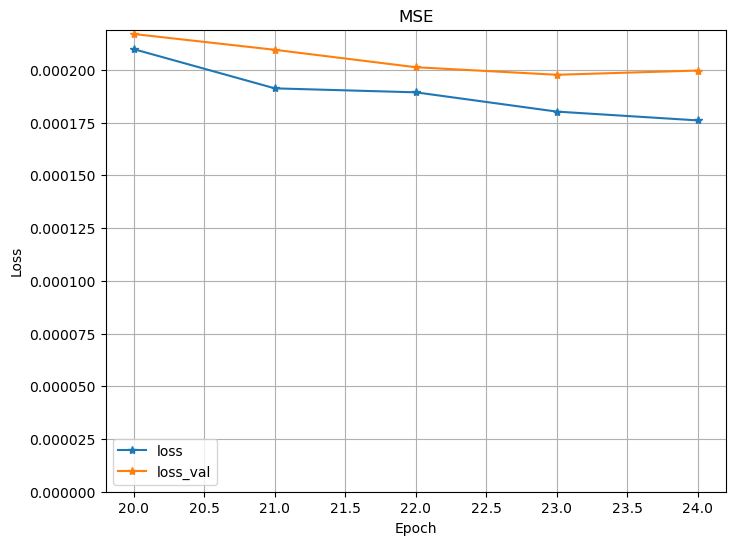

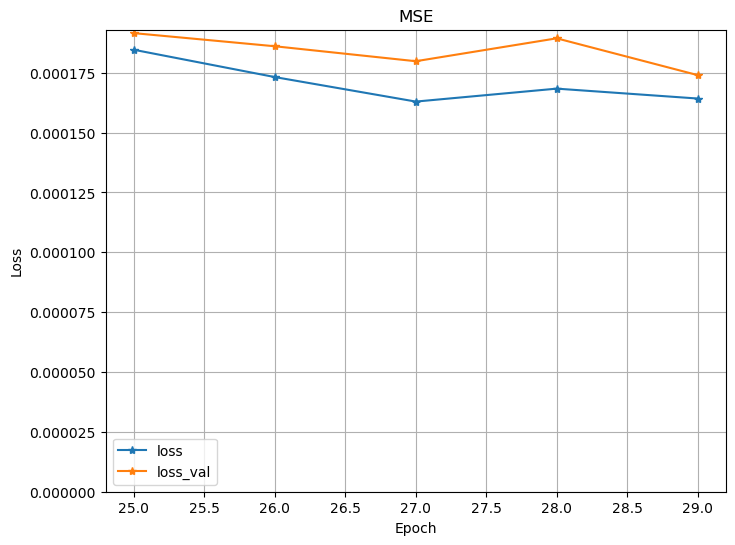

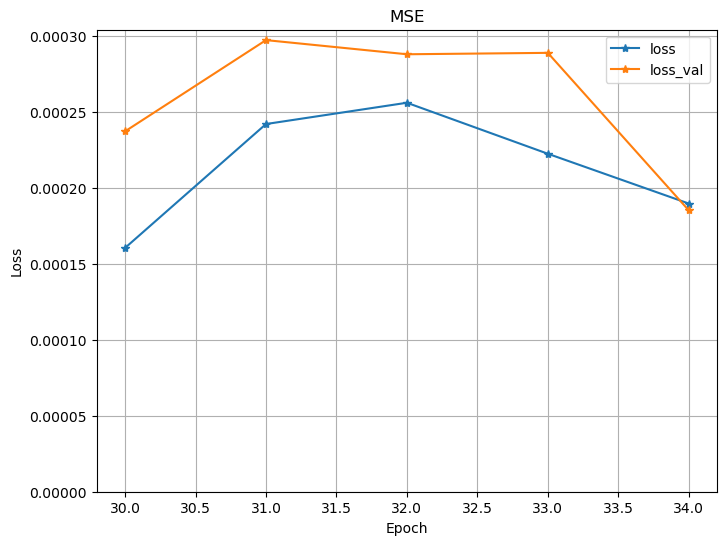

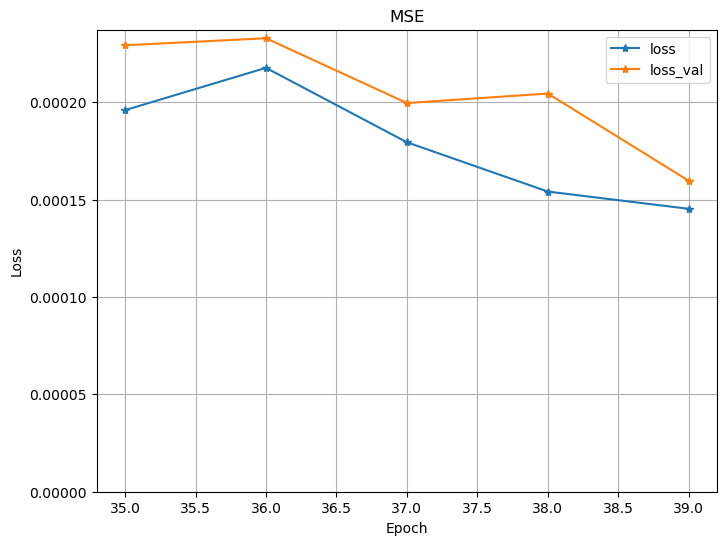

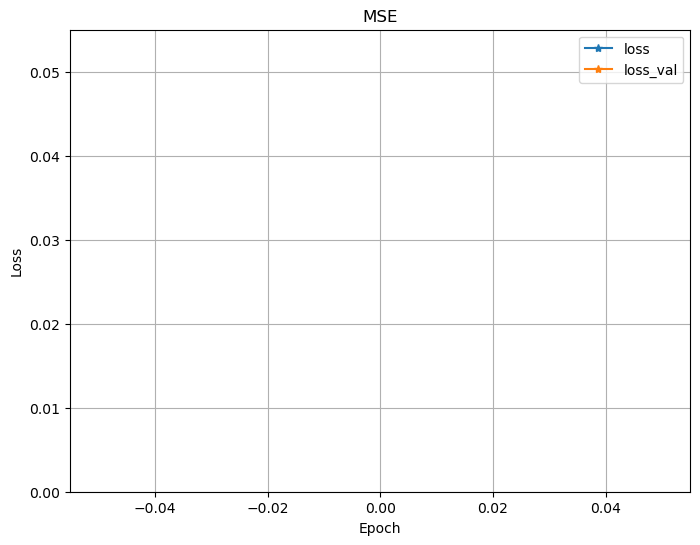

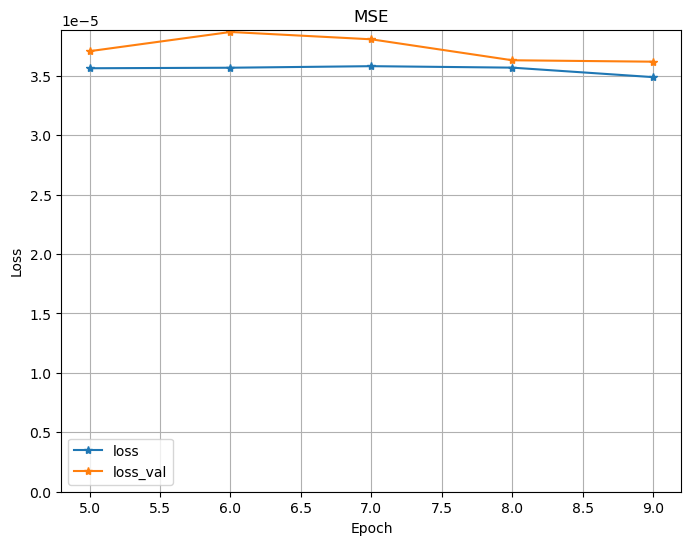

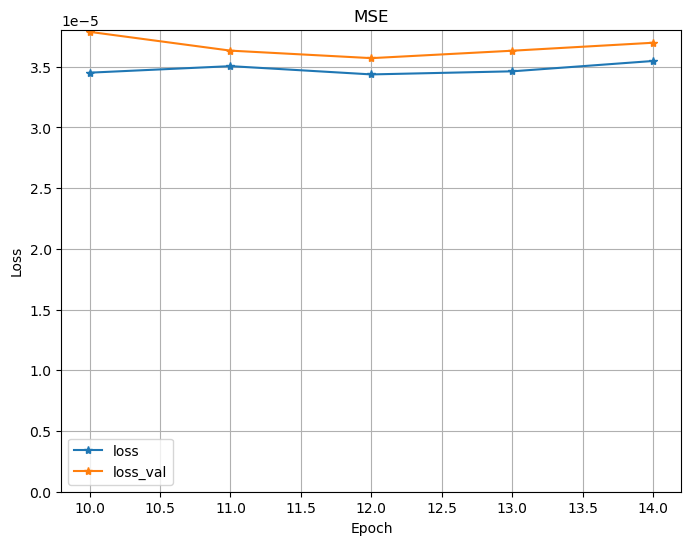

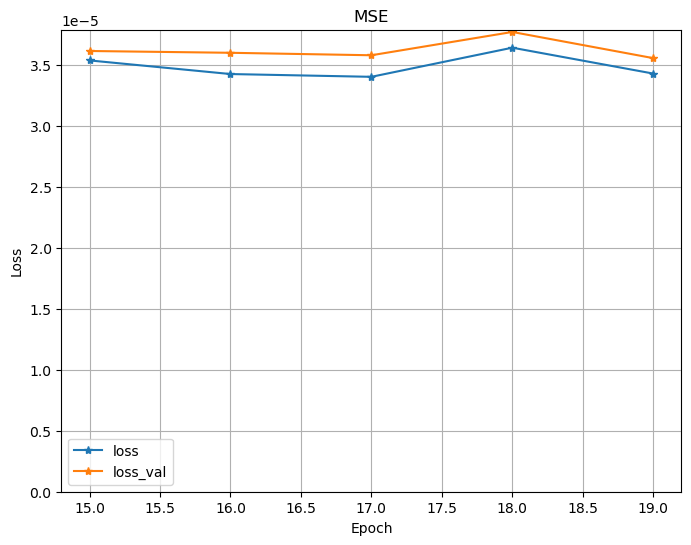

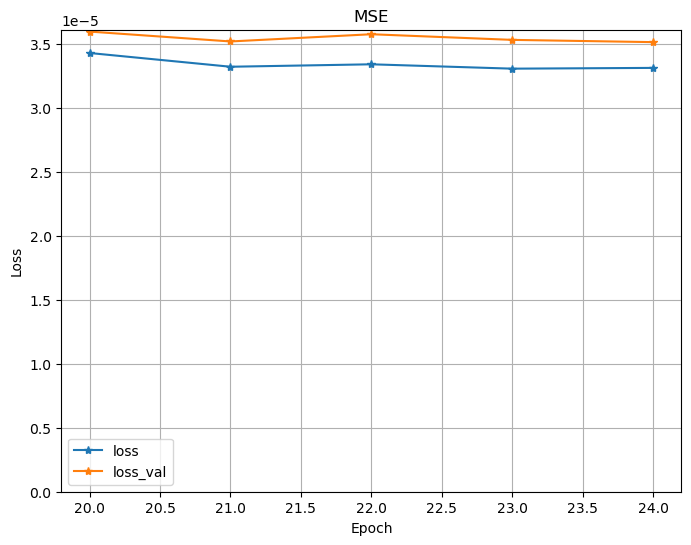

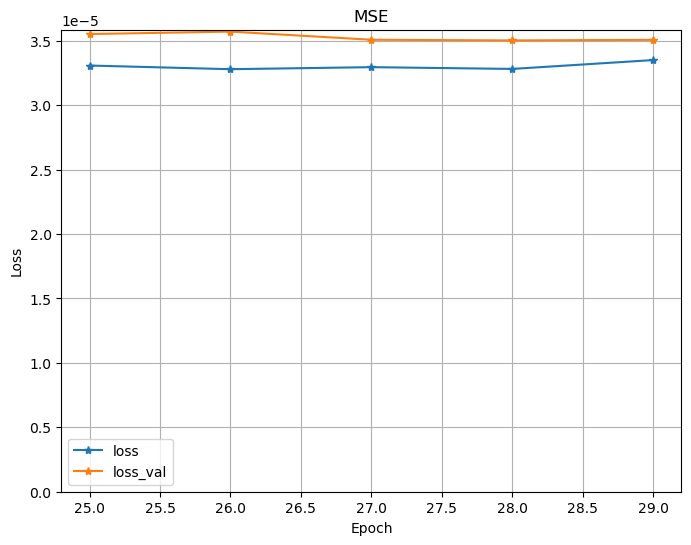

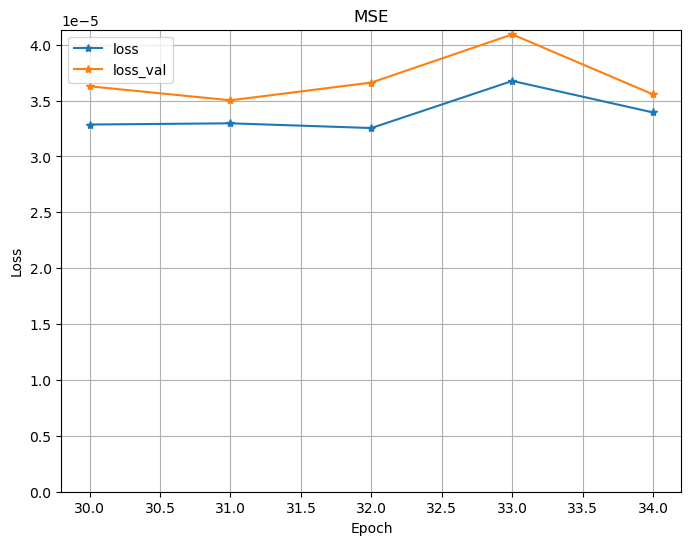

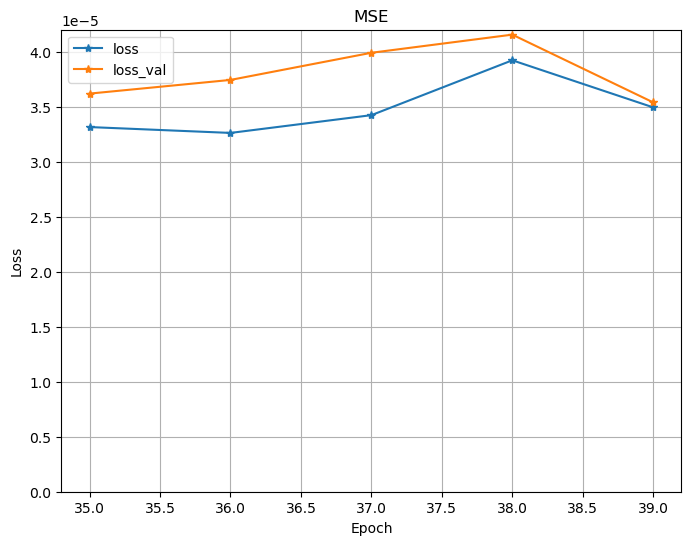

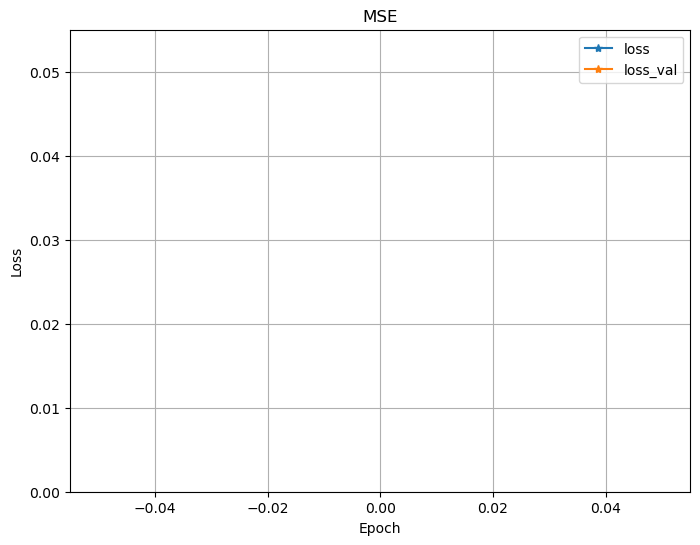

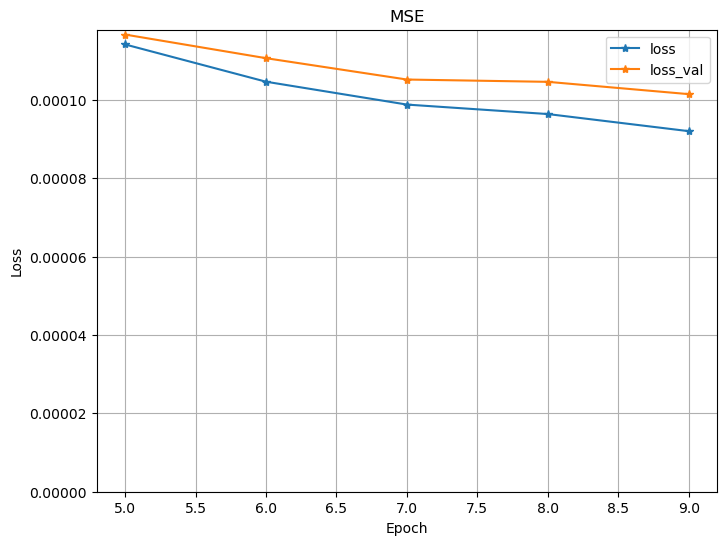

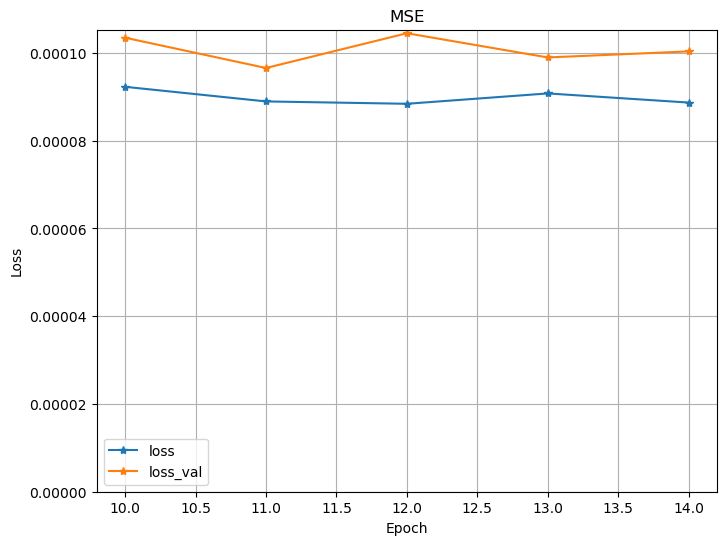

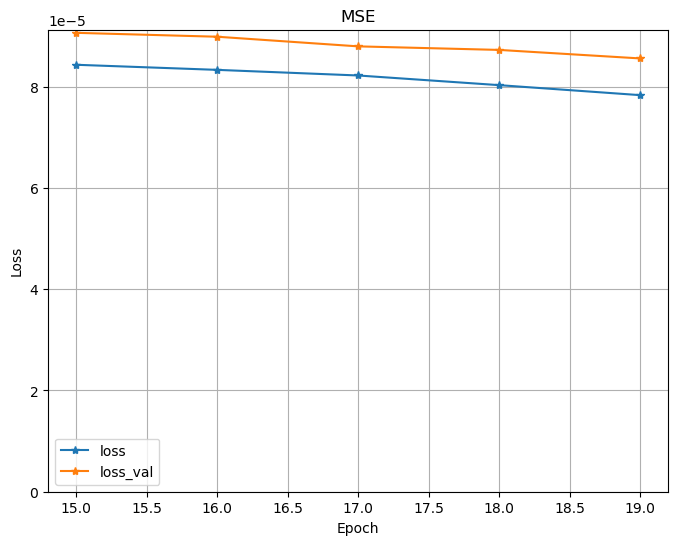

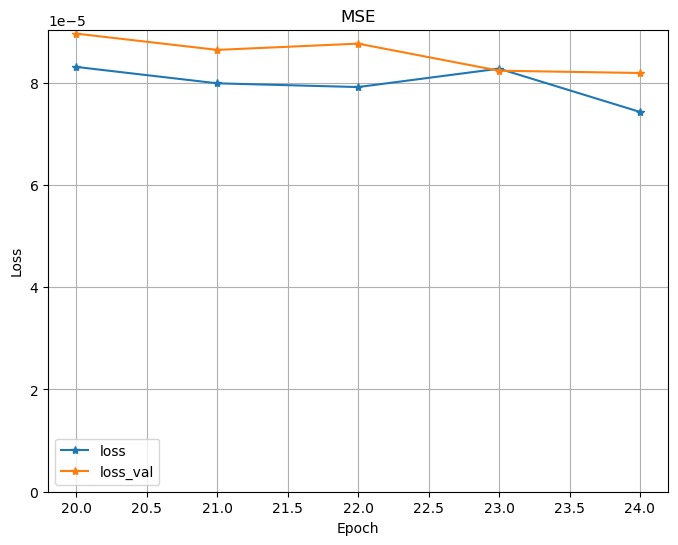

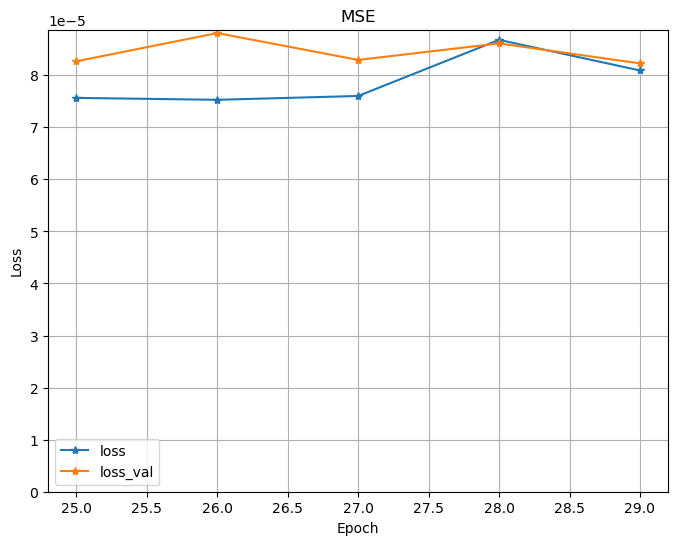

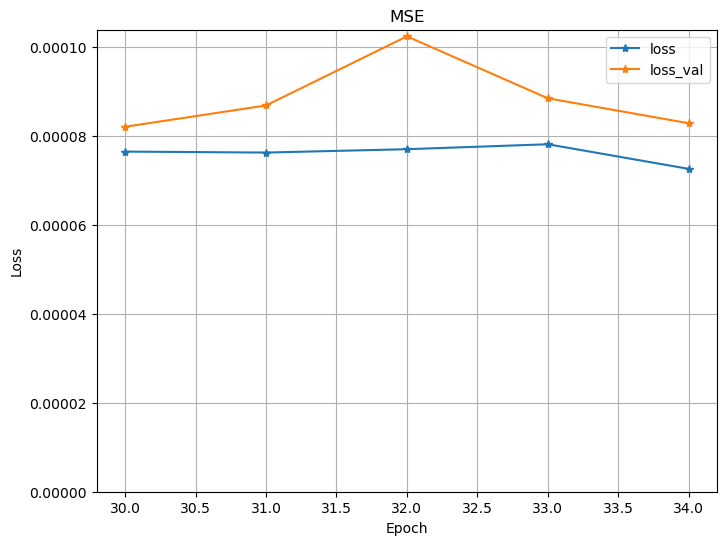

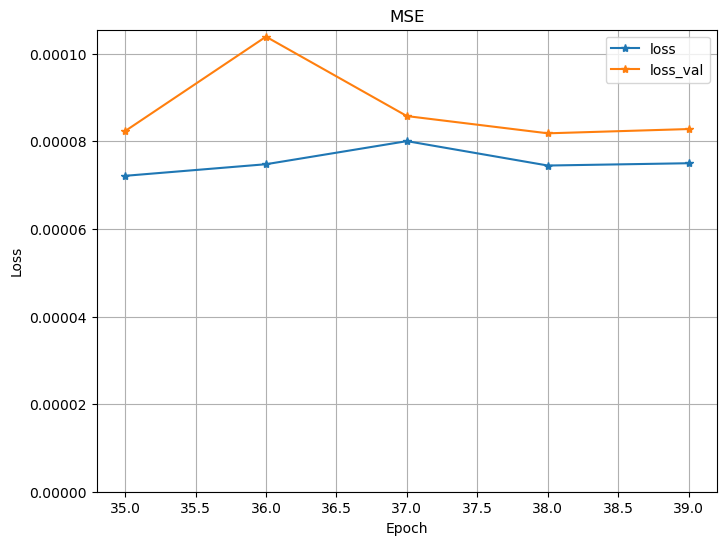

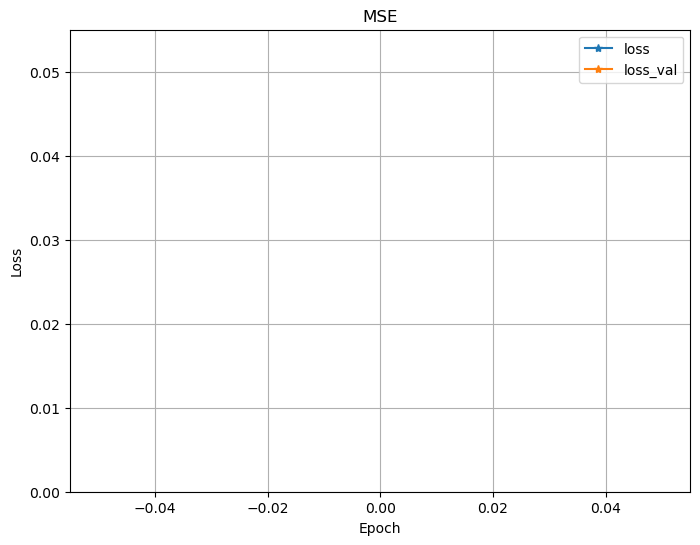

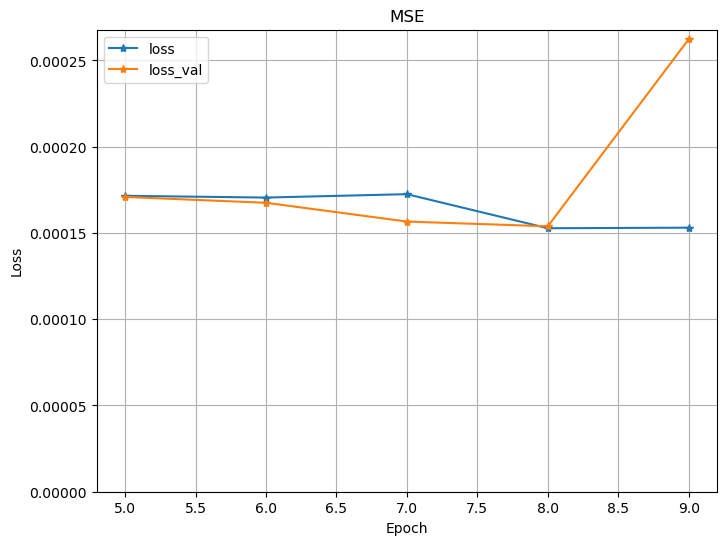

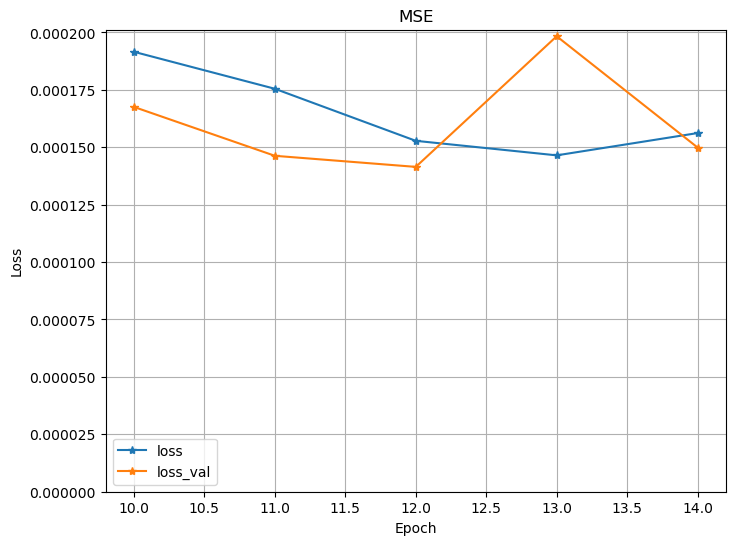

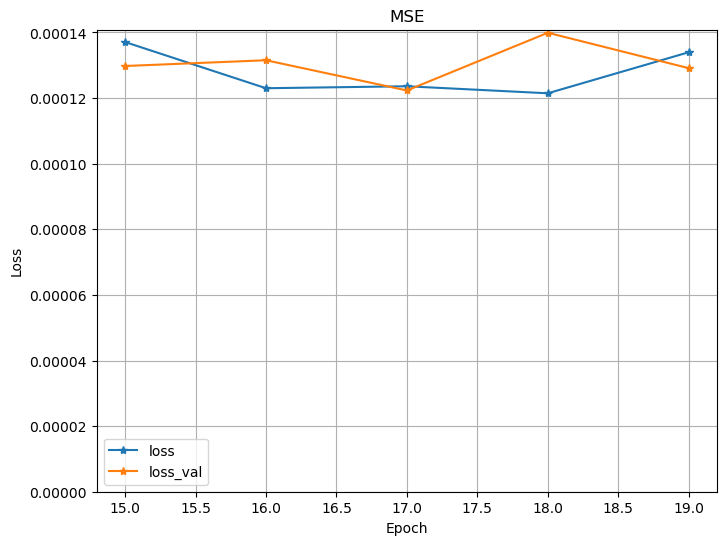

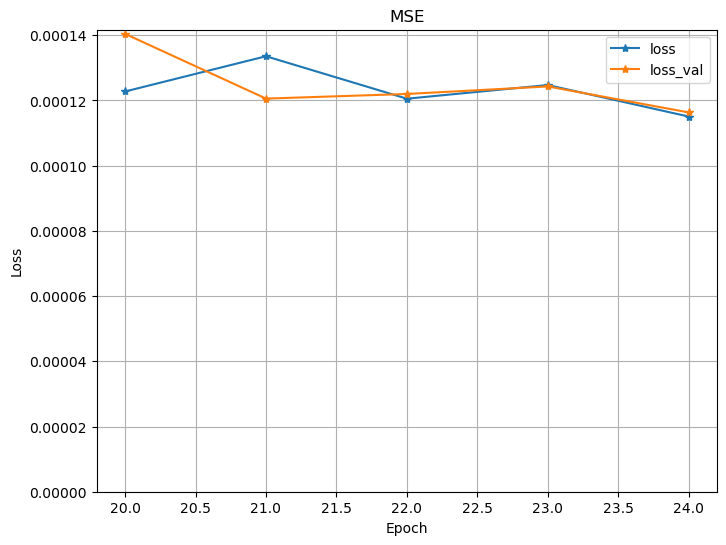

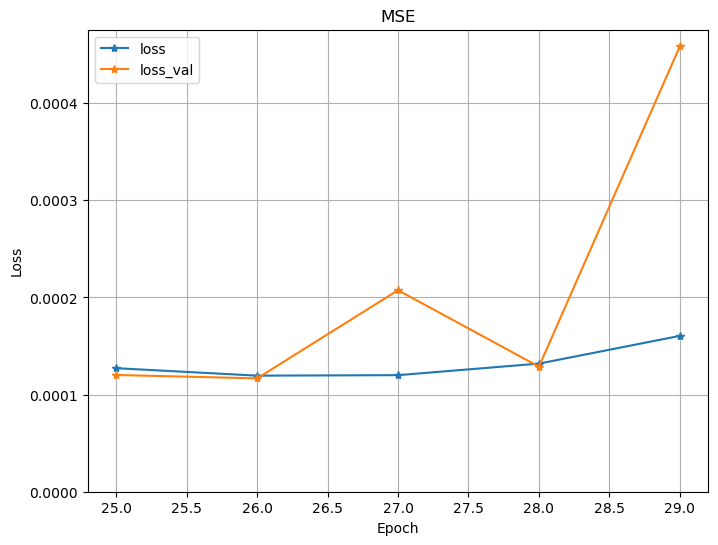

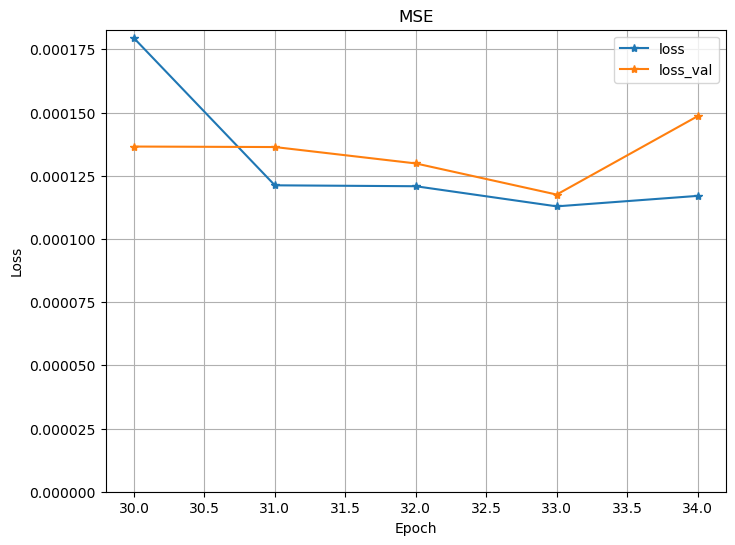

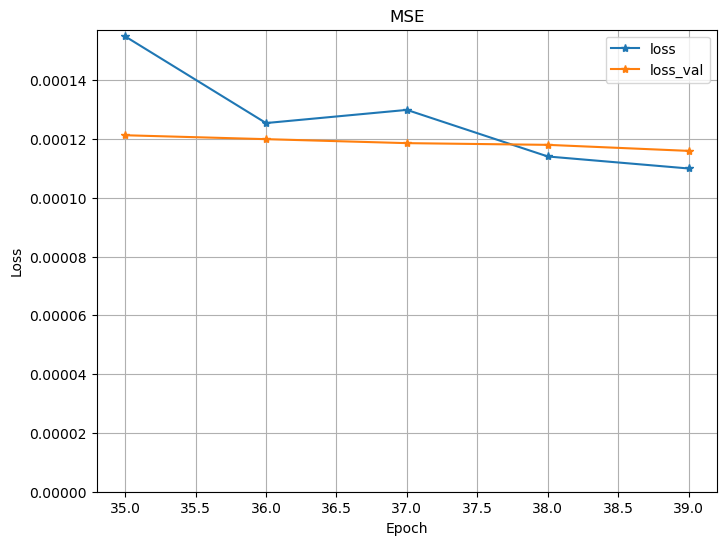

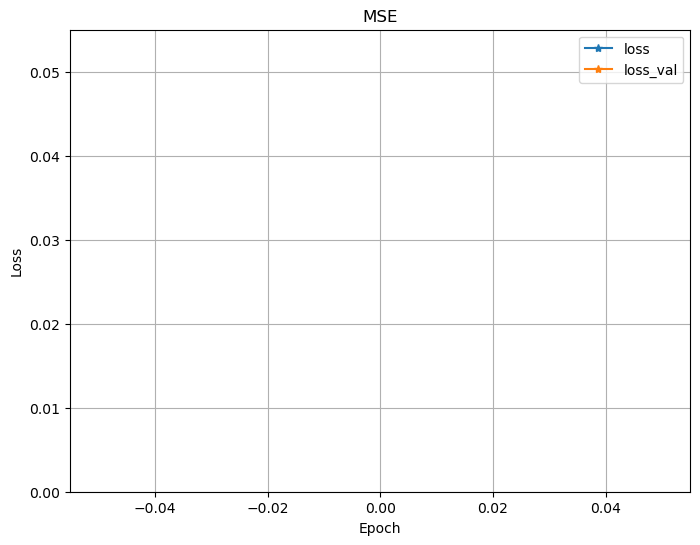

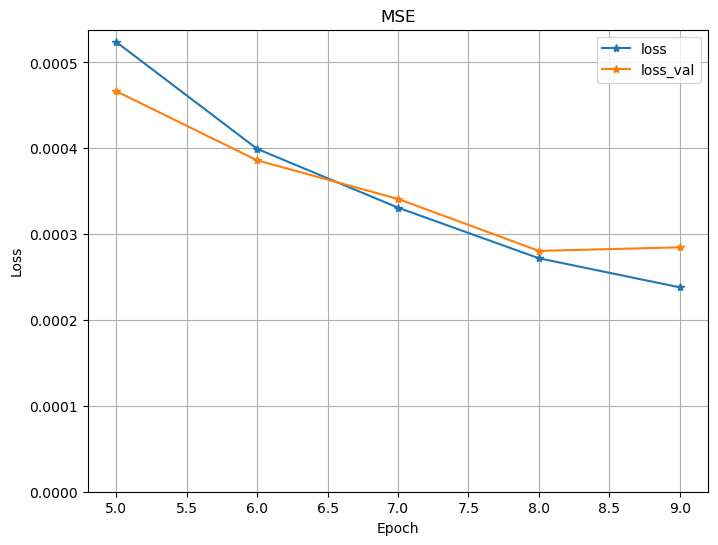

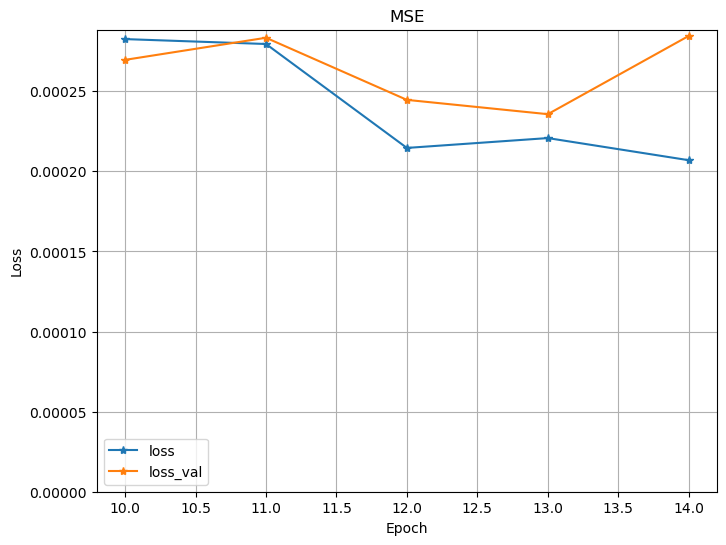

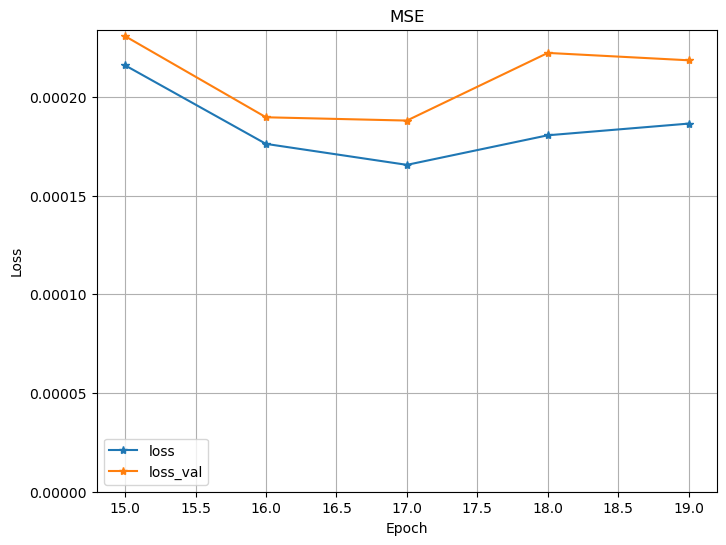

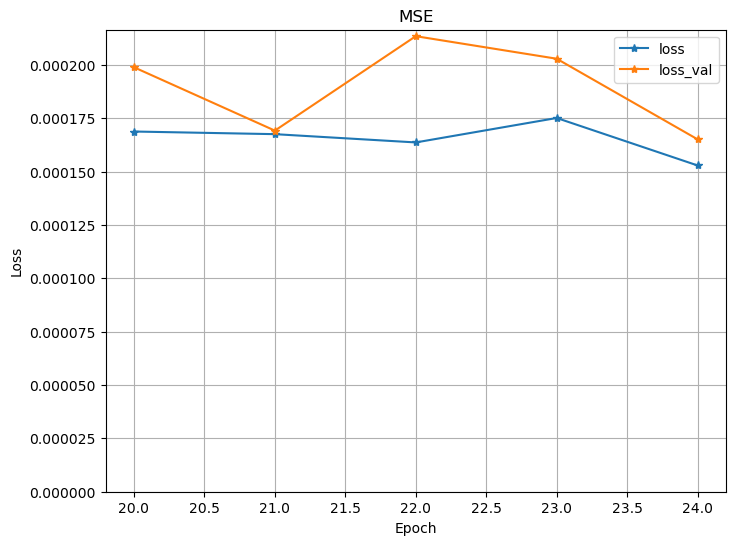

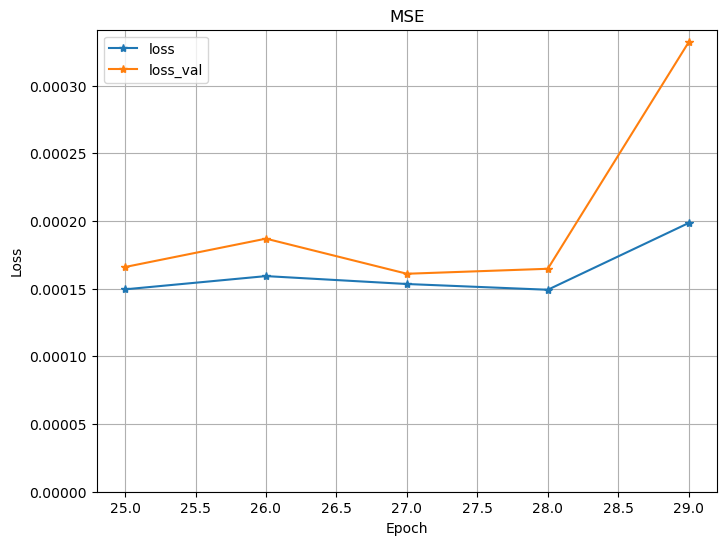

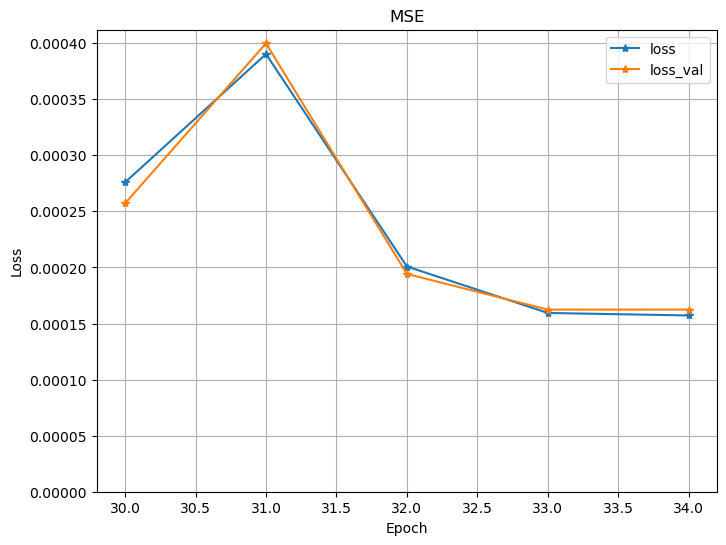

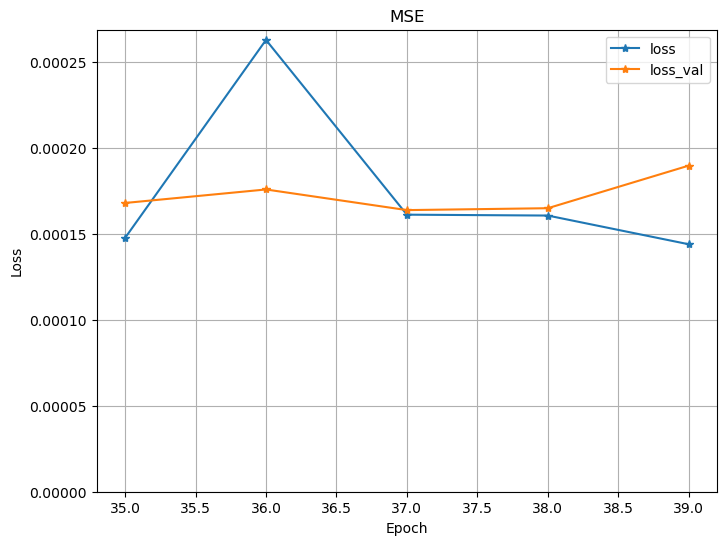

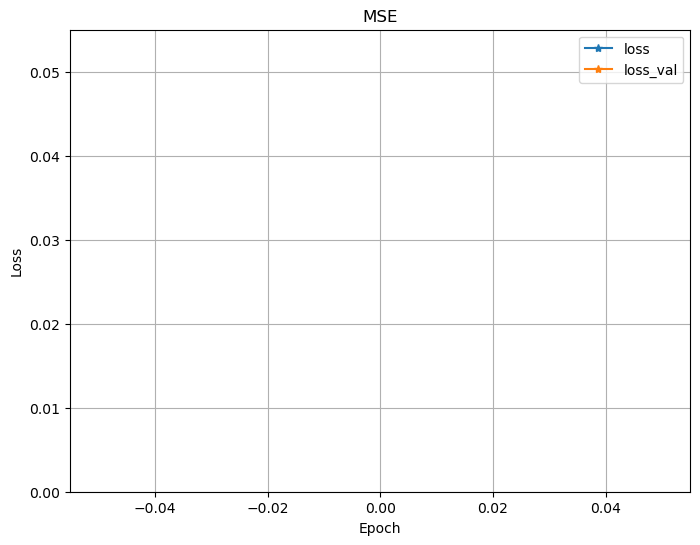

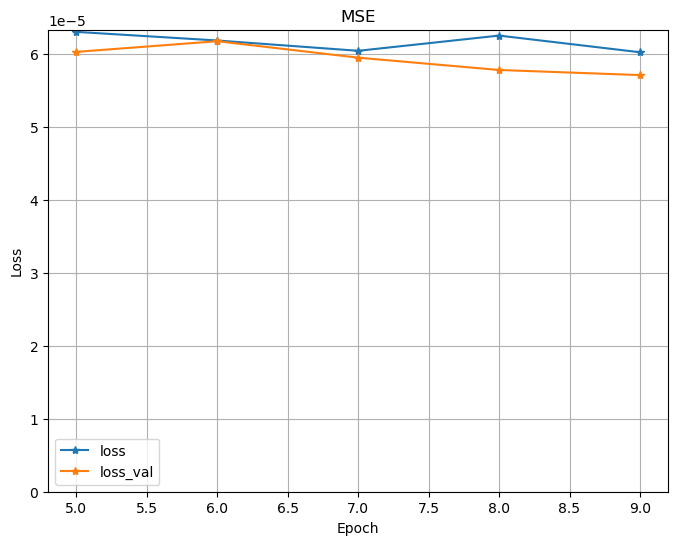

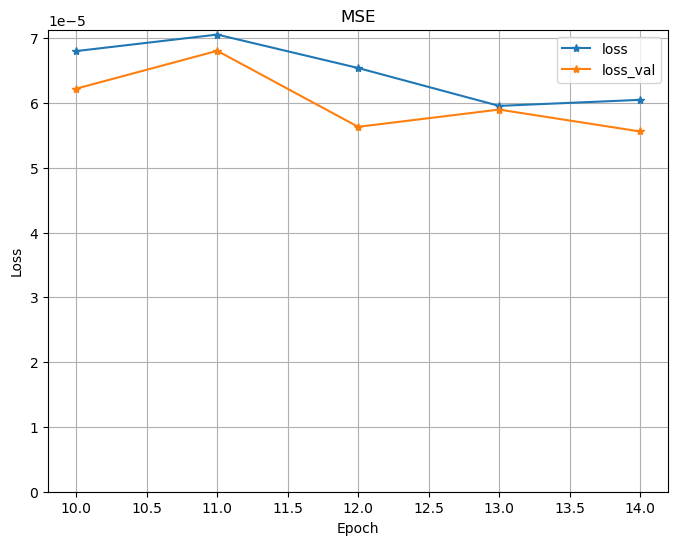

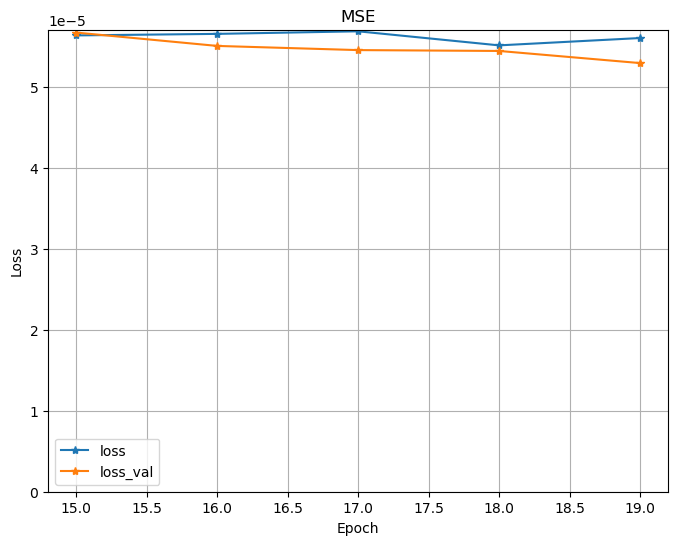

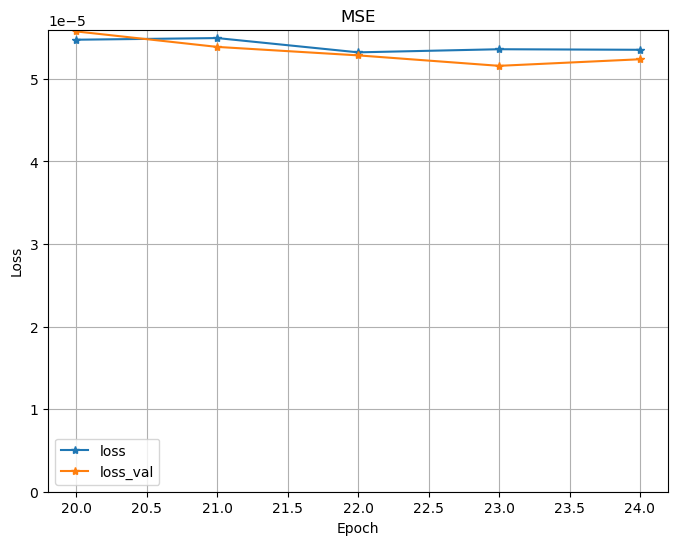

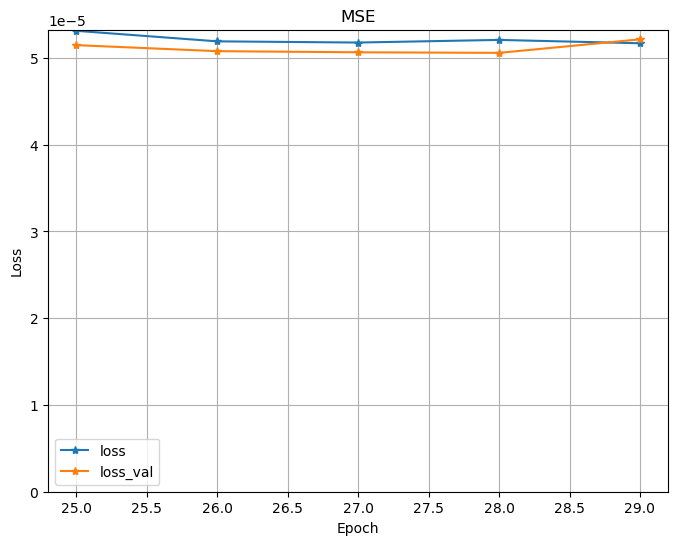

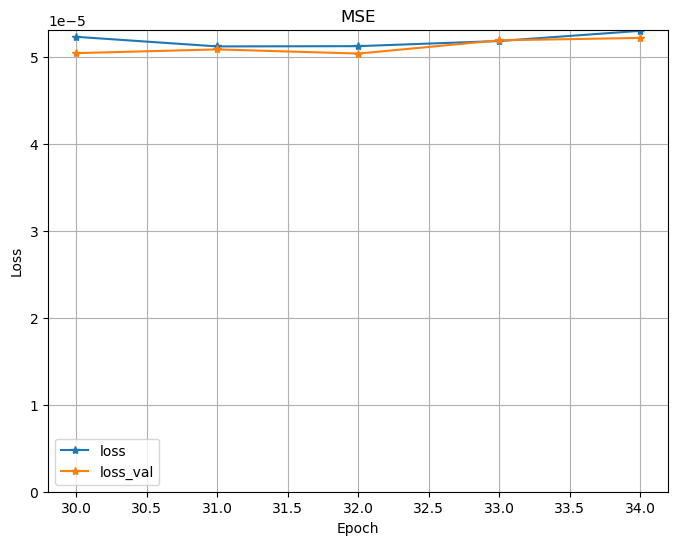

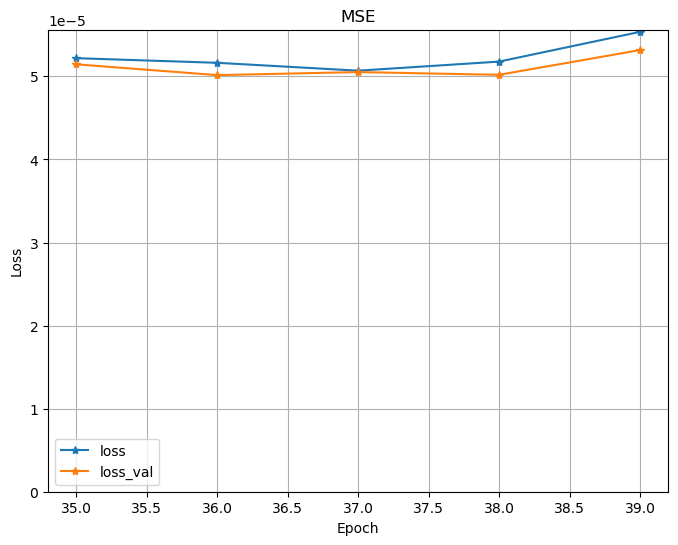

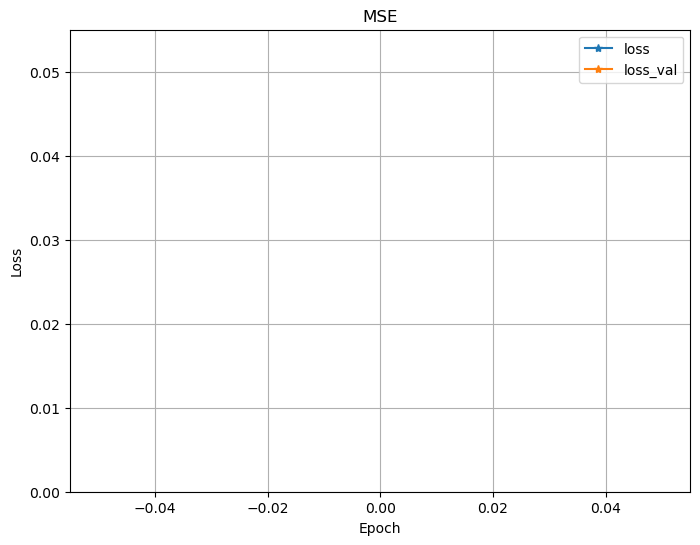

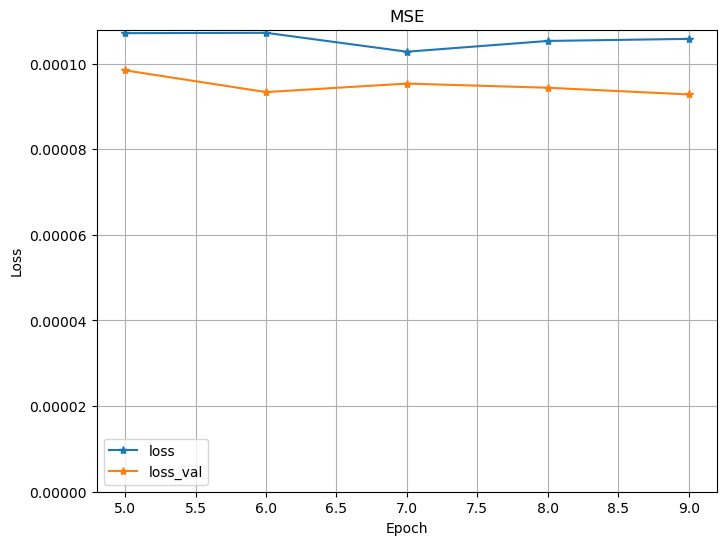

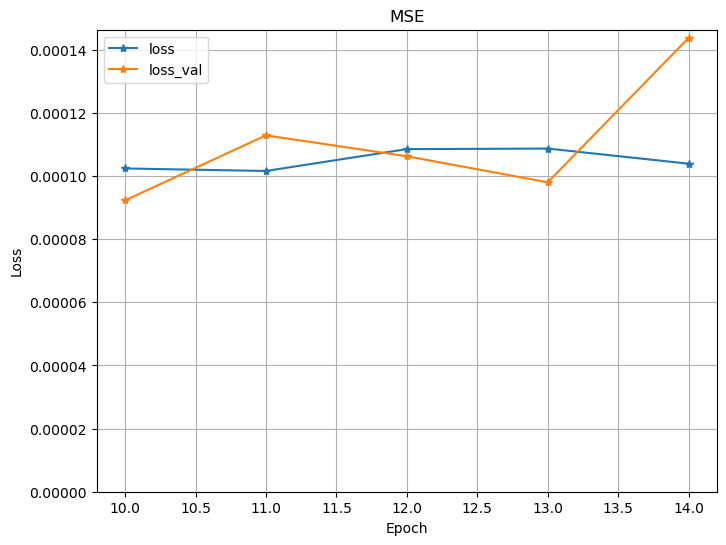

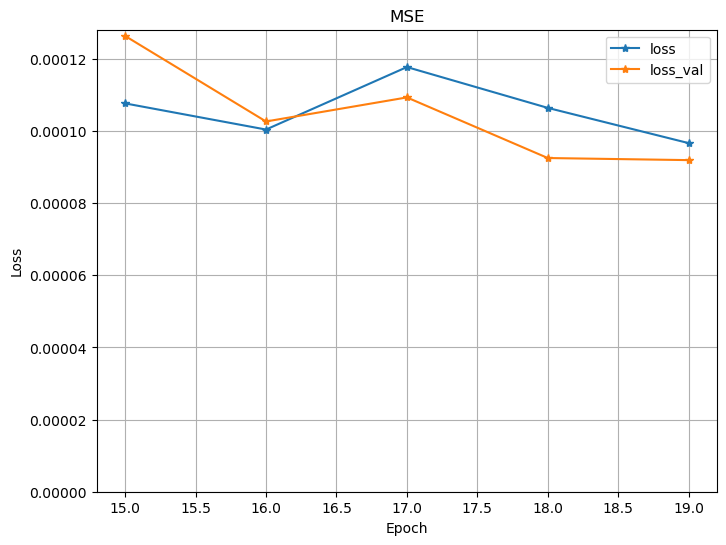

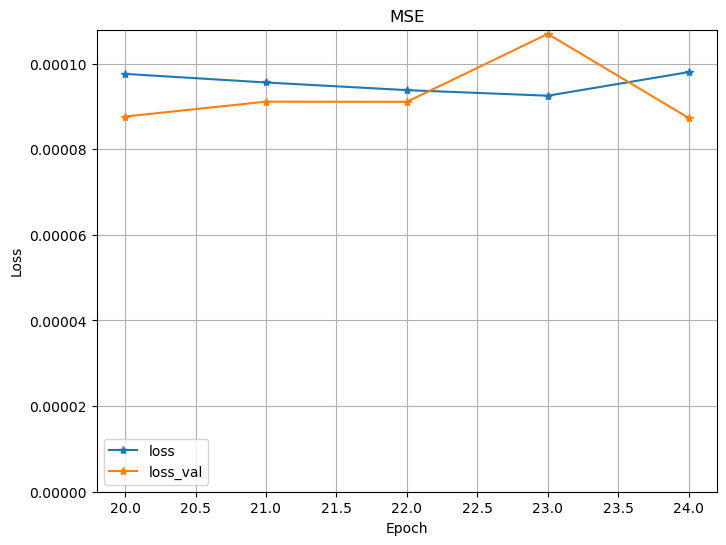

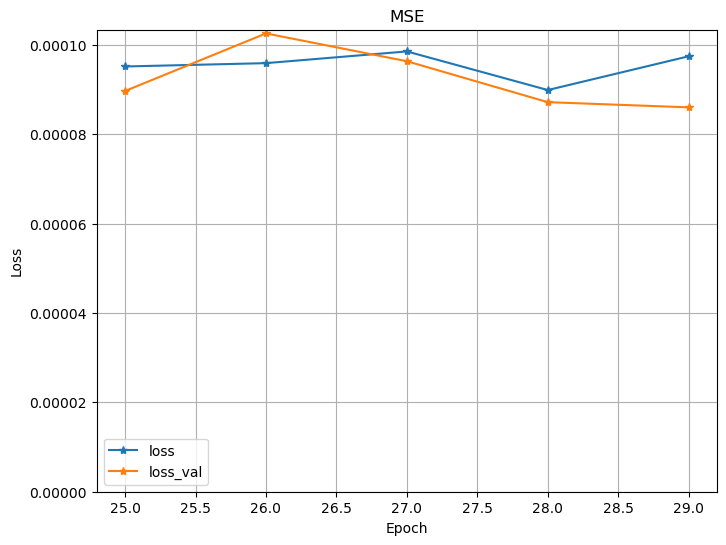

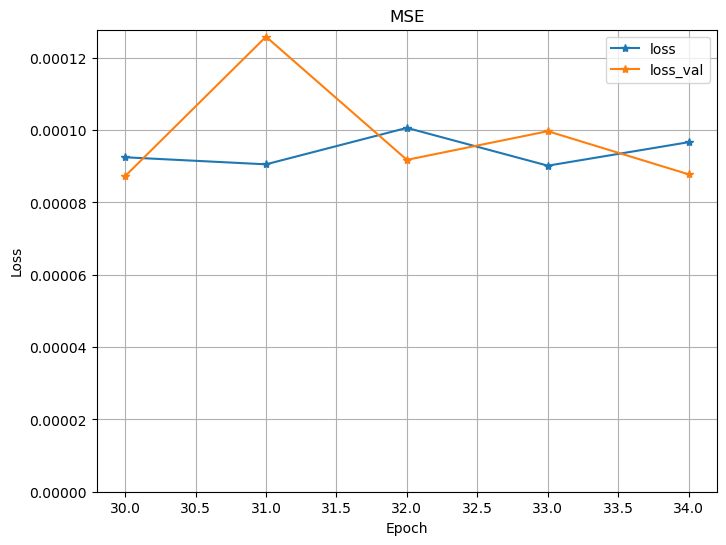

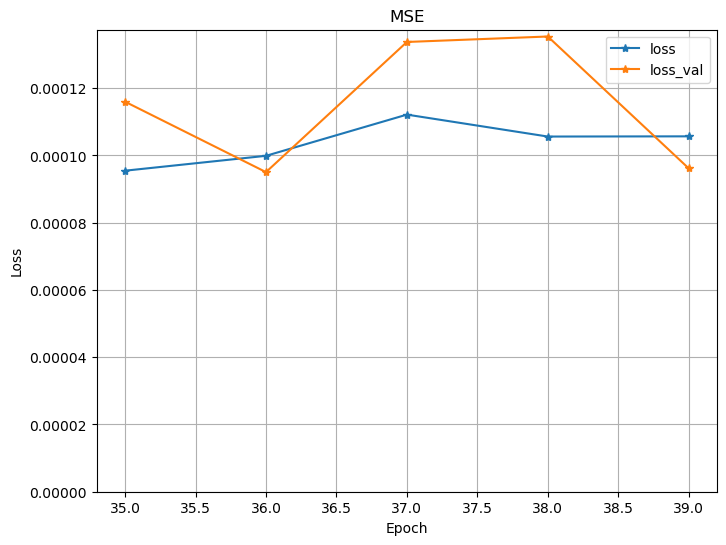

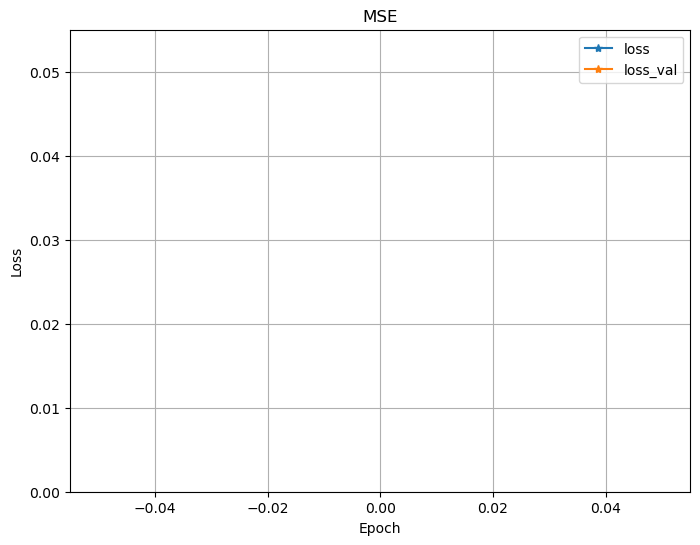

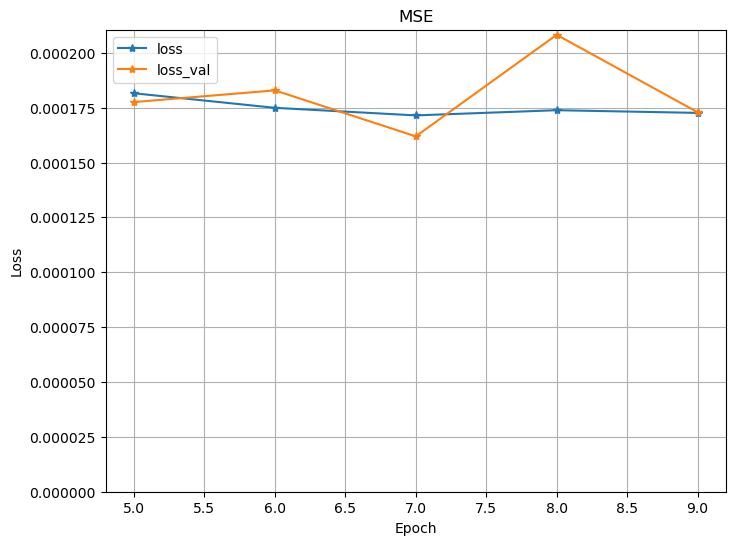

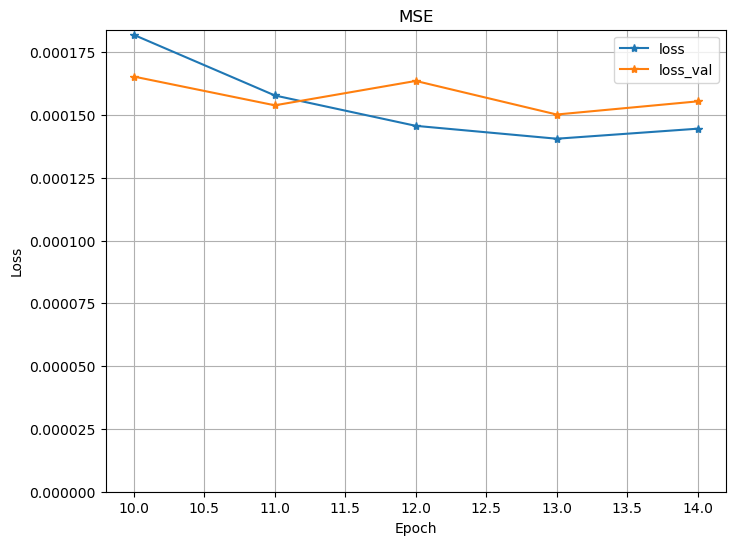

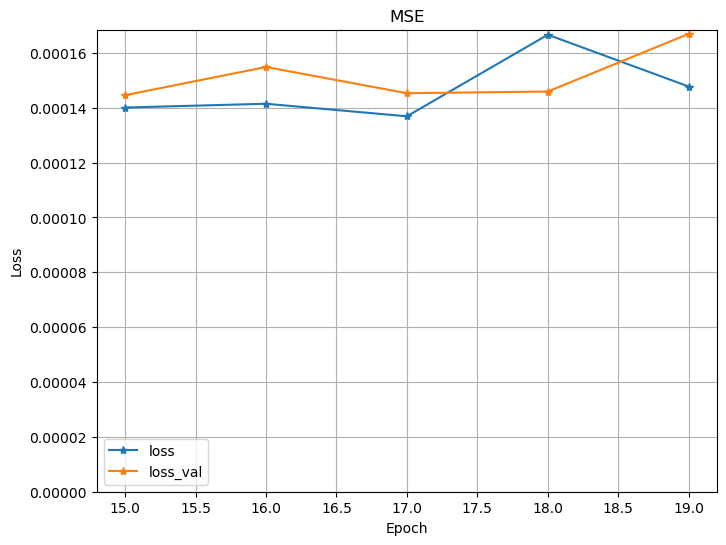

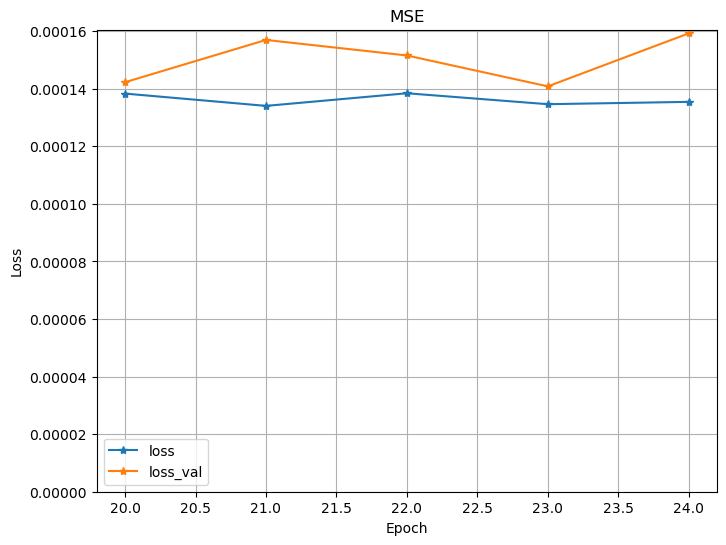

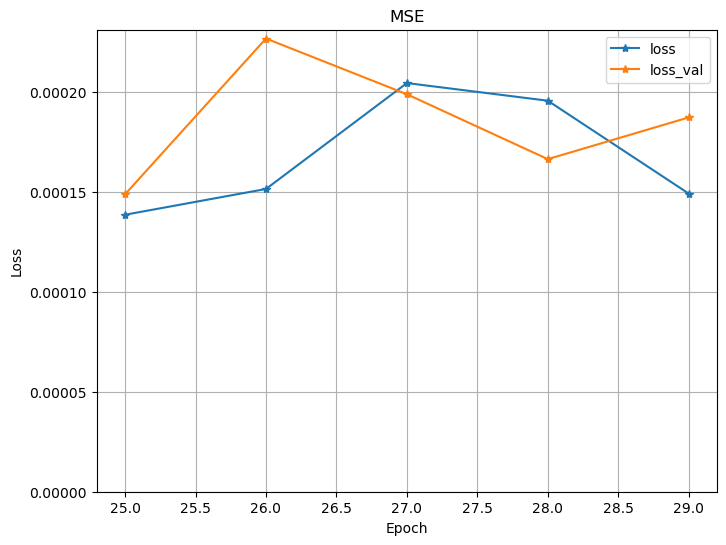

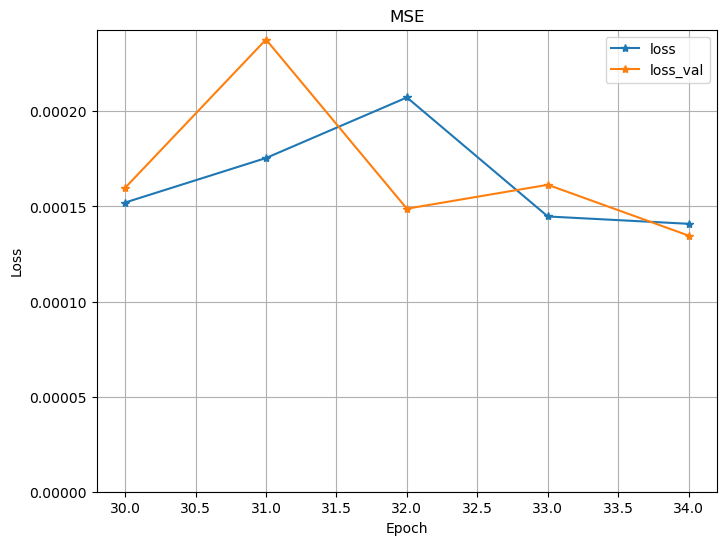

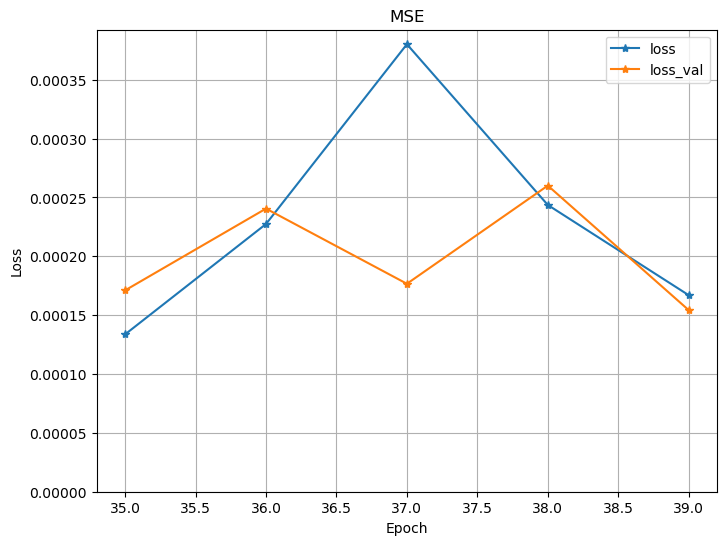

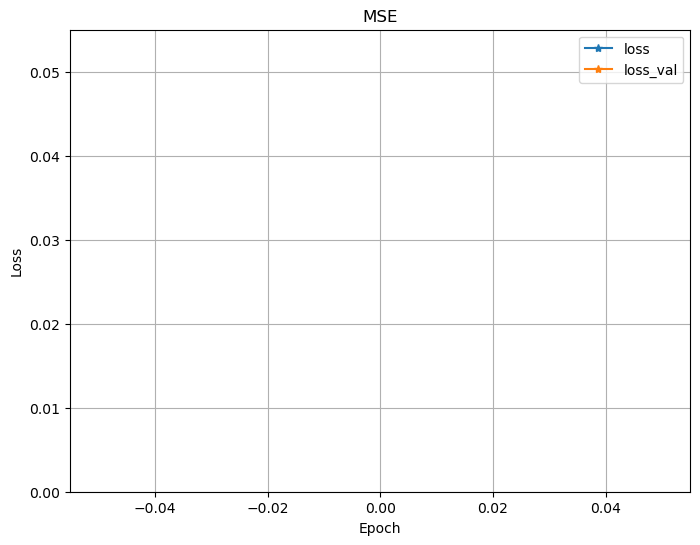

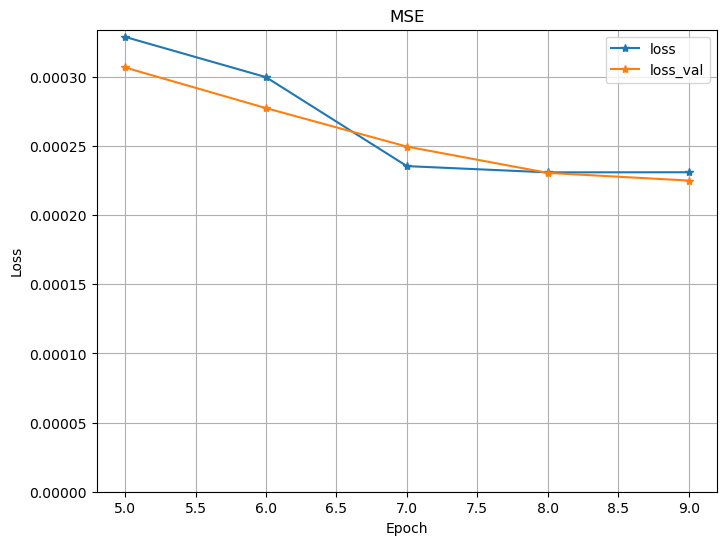

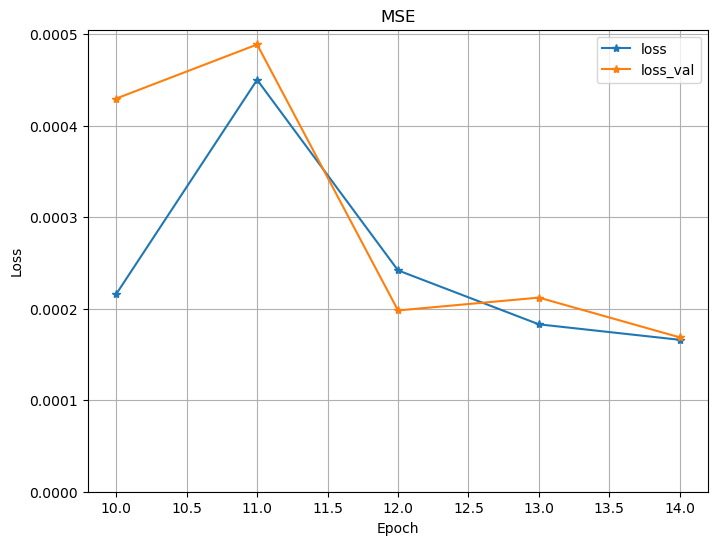

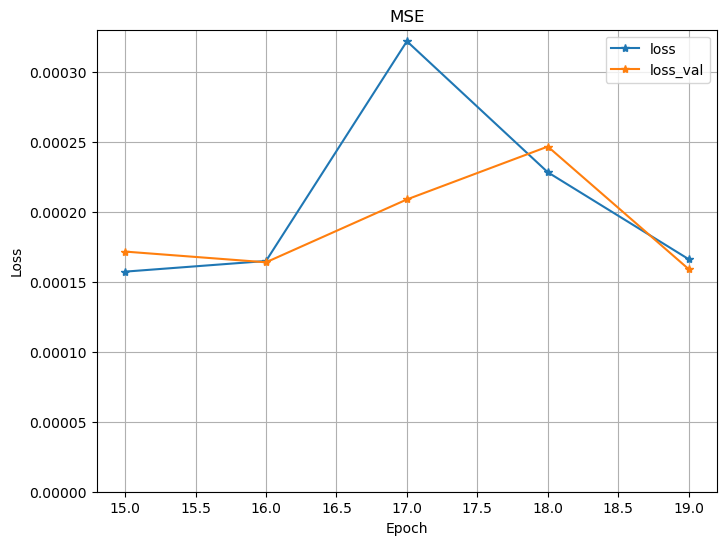

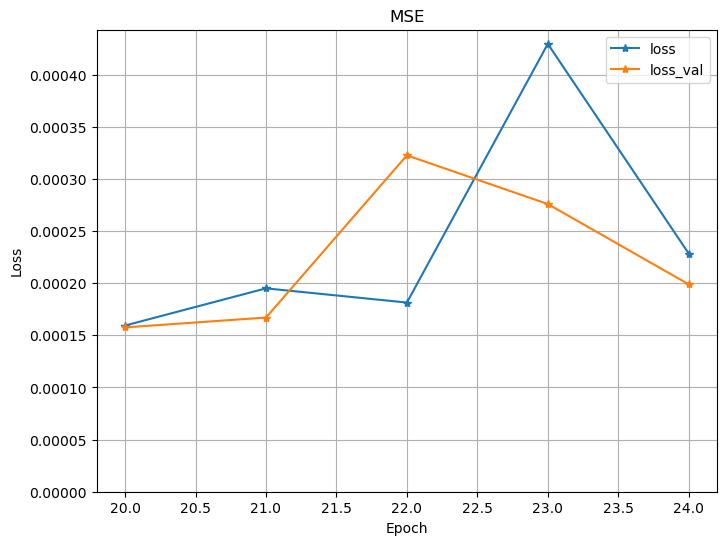

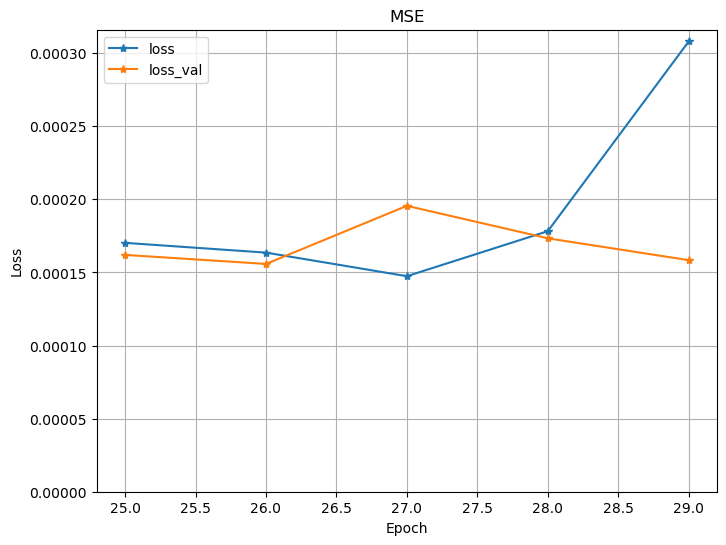

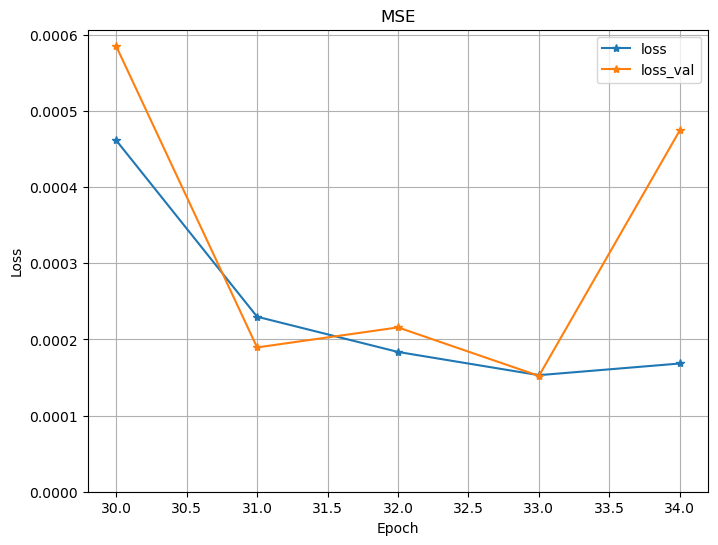

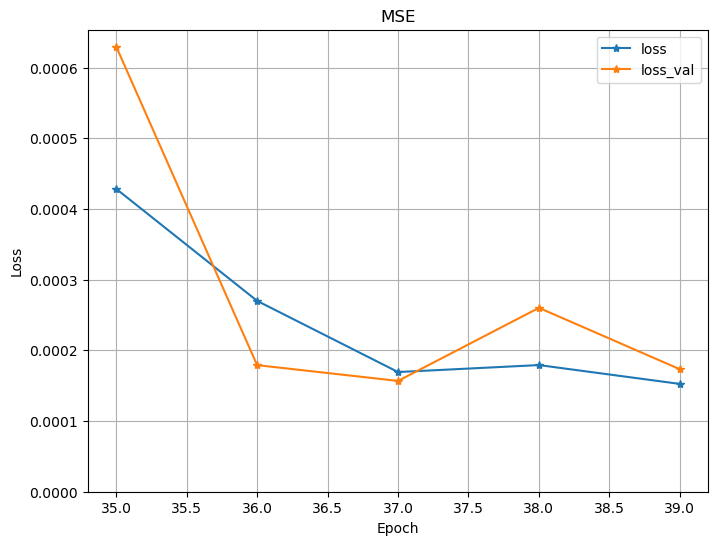

In [7]:
# Some settings for visualisation
matplotlib.use('Agg')
%matplotlib inline

seed = 123
torch.manual_seed(seed)

# Set parameters (including hyperparameters) and setting for saving/logging data

hyper_param_net = training.get_hyperparameter_grid('ConvMC-Net', TrainInstances = 400, ValInstances = 68, BatchSize = 20, ValBatchSize = 4, Alpha = 1.0, num_epochs = 40, learning_rate = 0.012)

params_net = get_default_param(hyper_param_net, True)

CalInGPU = params_net['CalInGPU']

q_list = [0.1, 0.3, 0.5, 0.7, 0.9]
sigma_list = [0.0, 3.0, 7.0, 10.0]

for q in q_list:
  for sigma in sigma_list:
    ProjectName = TRY + ' ' + logs_and_results.get_current_time() + ' ' + hyper_param_net['Model'] + ' ' + 'Sampling Rate: ' + logs_and_results.get_q_str(q) + ' and Noise Variance ' + logs_and_results.get_noise_str(sigma)

    # Get log file
    logfile = logs_and_results.get_modularized_record(ProjectName, q, sigma, 'Logs', hyper_param_net, params_net, SESSION)
    log = open(logfile, 'w')
    print('Project Name: %s'%ProjectName)
    log.write('Project Name: %s\n'%ProjectName)

    # Get Model
    net = training.get_model(params_net, hyper_param_net, log)
    print('Parameters = \n%s\n'%str(params_net))
    log.write('params_net=\n%s\n\n'%str(params_net))

    #Loading data and creating dataloader for both test and training
    print('Loading Data phase...')
    print('----------------')
    log.write('Loading phase...\n')
    log.write('----------------\n')
    shape_dset = (params_net['size1'], params_net['size2'])
    train_dataset = dataset_processing.ImageDataset(round(hyper_param_net['TrainInstances']), shape_dset, 0, q, sigma)
    train_loader = data.DataLoader(train_dataset,batch_size = hyper_param_net['BatchSize'], shuffle = True)
    val_dataset = dataset_processing.ImageDataset(round(hyper_param_net['ValInstances']), shape_dset, 1, q, sigma)
    val_loader = data.DataLoader(val_dataset, batch_size = hyper_param_net['ValBatchSize'], shuffle = True)
    print('Finished loading.\n')
    log.write('Finished loading.\n\n');

    # Some additional settings for training including loss, optimizer,
    floss = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = hyper_param_net['Lr'])
    scheduler2 =  torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma = 0.97, verbose = True)

    # Array for recording parameter values after each layer for each epoch etc
    outputs_L = convmc.to_var(torch.zeros([shape_dset[0], shape_dset[1]]), CalInGPU)
    lossmean_vec = np.zeros((hyper_param_net['Epochs'], ))
    lossmean_val_vec = np.zeros((hyper_param_net['Epochs'], ))

    mu_inverse, y1, exp_L = net.getexp_LS()

    mu_inverse_vec = np.zeros((hyper_param_net['Epochs'], net.layers))
    y1_vec = np.zeros((hyper_param_net['Epochs'], net.layers,params_net['size1'], params_net['size2']))
    exp_L_vec = np.zeros((hyper_param_net['Epochs'], net.layers))

    # dummy variable to monitor and record progress for loss
    minloss = np.inf

    for epoch in range(hyper_param_net['Epochs']):
      print(f'Epoch: {epoch + 1}, {logs_and_results.get_current_time()}, \n')
      log.write('\n' + logs_and_results.get_current_time() + '\n')

      # Train and Test Steps. (Record every 5 epochs)
      if (epoch + 1) % 5 == 0:
          print('Loading and calculating training batches...')
          log.write('Loading and calculating training batches...\n')
          startime = time.time()
          loss_mean, loss_lowrank_mean = training.train_step(net, train_loader, floss, optimizer, CalInGPU, hyper_param_net['Alpha'], hyper_param_net['TrainInstances'], hyper_param_net['BatchSize'])
          endtime = time.time()
          print('Training time is %f'%(endtime - startime))
          log.write('Training time is %f\n'%(endtime - startime))

          print('Loading and calculating validation batches...')
          log.write('Loading and calculating validation batches...\n')
          startime = time.time()
          loss_val_mean, loss_val_lowrank_mean = training.test_step(net, val_loader, floss, optimizer, CalInGPU, hyper_param_net['Alpha'], hyper_param_net['ValInstances'], hyper_param_net['ValBatchSize'])
          endtime = time.time()
          print('Test time is %f'%(endtime - startime))
          log.write('Test time is %f\n'%(endtime - startime))
      else:
        loss_mean, loss_lowrank_mean = training.train_step(net, train_loader, floss, optimizer, CalInGPU, hyper_param_net['Alpha'], hyper_param_net['TrainInstances'], hyper_param_net['BatchSize'])
        loss_val_mean, loss_val_lowrank_mean = training.test_step(net, val_loader, floss, optimizer, CalInGPU, hyper_param_net['Alpha'], hyper_param_net['ValInstances'], hyper_param_net['ValBatchSize'])

      # Update Record and Parameters
      lossmean_vec[epoch] = loss_mean
      lossmean_val_vec[epoch] = loss_val_mean

      mu_inverse, y1, exp_L = net.getexp_LS()

      mu_inverse_vec[epoch, :] = mu_inverse
      y1_vec[epoch] = y1
      exp_L_vec[epoch, :] = exp_L

      # Update Log after every 5 epochs. Make a plot of MSE against epochs every 5 epochs. Save Model in whole/dict form every five epochs.
      if (epoch + 1) % 5 == 0:
        print(f"Saving Whole Model at Epochs: [{epoch + 1}/{hyper_param_net['Epochs']}]")
        model_whole_path = logs_and_results.get_modularized_record(ProjectName, q, sigma, 'Saved Models - Whole', hyper_param_net, params_net, SESSION, current_epoch = epoch + 1)
        torch.save(net, model_whole_path)
        print(f"Saving Model Dict at Epochs: [{epoch + 1}/{hyper_param_net['Epochs']}]")
        model_state_dict_path = logs_and_results.get_modularized_record(ProjectName, q, sigma, 'Saved Models - Dict', hyper_param_net, params_net, SESSION, current_epoch = epoch + 1)
        torch.save(net.state_dict(), model_state_dict_path)

        print('Epoch [%d/%d], Lossmean:%.5e, Validation lossmean:%.5e'
              %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))
        print('loss_lowrank_mean', loss_lowrank_mean)
        print('loss_val_lowrank_mean', loss_val_lowrank_mean)

        log.write('loss_lowrank_mean %.5e\n' %(loss_lowrank_mean))
        log.write('loss_val_lowrank_mean %.5e\n' %(loss_val_lowrank_mean))
        log.write('Epoch [%d/%d], Lossmean:%.5e, Validation lossmean:%.5e\n'
              %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))
        np.set_printoptions(precision = 3)

        print('mu_inverse:', mu_inverse)

        print('torch.mean(y1)', np.mean(y1))
        print('y1:', y1)
        print('exp_L:', exp_L)

        log.write('mu_inverse: '+ str(mu_inverse)+'\n')
        log.write('y1: '+ str(y1)+'\n')
        log.write('exp_L: '+ str(exp_L) + '\n')

        if True or loss_val_mean<minloss:
          print('saved at [epoch%d/%d]'%(epoch + 1, hyper_param_net['Epochs']))
          log.write('saved at [epoch%d/%d]\n' %(epoch + 1, hyper_param_net['Epochs']))
          minloss = min(loss_val_mean, minloss)

        # Plotting MSE vs Epoch and Saving it

        # Get Directory where we have to save the plot
        dir = logs_and_results.get_modularized_record(ProjectName, q, sigma, 'Plots', hyper_param_net, params_net, SESSION, current_epoch = epoch + 1)
        epochs_vec = np.arange(0, hyper_param_net['Epochs'], 1)
        logs_and_results.plot_and_save_mse_vs_epoch(epochs_vec, lossmean_vec, hyper_param_net, lossmean_val_vec, dir, epoch)

    # Finish off by observing the minimum loss on validation set

    #Print min loss
    print('\nmin Loss = %.4e'%np.min(lossmean_val_vec))
    log.write('\nmin Loss = %.4e\n'%np.min(lossmean_val_vec))
    log.close()